# Technical appendix - UNIVARIATEYEARLY

## A. Scope & assumptions

* **Problem:** rigorous exploratory analysis of a **single yearly time series** (e.g., 2000–2024) with attention to data quality, trend regimes, anomalies, and stationarity—foundations for downstream modelling.
* **Granularity:** one observation per **calendar year**; no intra-year seasonality (m=1). Focus on trend, structural breaks, and volatility shifts over years.

## B. Data contract

* **Required columns:** `year: int` **or** `date: datetime64[ns]` (normalized to year-start), `value: float`, optional `unit: str`, `entity: str`.
* **Constraints:** unique `(entity?, year)` after prep; years strictly increasing; `value` finite (no ±inf), NA rate ≤ threshold in `quality.yaml`.
* **Schema enforcement:** `schemas.py` validates dtypes, uniqueness, monotonicity, and allowable ranges (optional min/max).

## C. Data quality checks (`quality.py`)

* Missingness profile (overall and per-year).
* Duplicate years and gaps detection (e.g., 2008 missing).
* Monotonicity tests (strict/non-strict) with violation counts.
* Out-of-domain values (negative where not allowed).
* Coverage KPI exported to `reports/tables/quality_summary.csv`.

## D. Descriptive profiling (`profiling.py`)

* Shape, time span, count of gaps.
* Moments: mean/median, variance, skew, kurtosis (Fisher).
* Distribution diagnostics: kernel density snapshot, **QQ-plot** vs. normal/log-normal.
* Growth descriptors: **YoY** changes, cumulative growth, **CAGR**.
* Rolling summaries over configurable windows (e.g., 3y MA).

## E. Transformations (`transforms.py`)

* Stabilize variance: Box–Cox / Yeo–Johnson with λ recorded (invertible).
* Detrending: linear or LOESS; residual extraction.
* Differences: first and second difference; back-transform helpers.
* Winsorization/trimming policies for robust stats.

## F. Stationarity & dependence (`stationarity.py`)

* **ADF**, **KPSS**, **Phillips–Perron** tests with:

  * automatic lag selection (AIC/BIC/max rule),
  * deterministic terms (constant, trend).
* Autocorrelation diagnostics (ACF up to reasonable lags given few years).
* Decision table: raw vs. transformed vs. differenced stationarity.

## G. Structural breaks (`changepoints.py`)

* Backends: **ruptures** (`Pelt`, `Binseg`, `Dynp`) with costs:

  * `l2`, `rbf`, or linear trend cost for mean/variance/regime shifts.
* Penalty calibration via BIC-like rules or manual penalty from `changepoints.yaml`.
* Minimum segment length to avoid overfitting on short histories.
* Outputs:

  * Segment index with start/end years, mean, slope.
  * Break uncertainty via simple ±1 year tolerance band (documented caveat).

## H. Anomaly detection (`anomalies.py`)

* **ESD/Generalized ESD** for global outliers (low N guard).
* **Hampel filter** (window k, threshold t) robust local outlier flags.
* Residual-based anomalies after detrending.
* Export `reports/tables/anomalies.csv` with reason codes (ESD/Hampel/Residual).

## I. Feature derivation (`features.py`)

* `yoy`, `yoy_pct`, `cagr(start, end)`, standardized growth (`z_yoy`).
* Regime-aware features: segment slope, segment index.
* Lagged deltas: `Δ1`, `Δ2` for quick correlation checks.

## J. Visualization (`plotting.py`)

* Theme helper (`set_theme()`): consistent fonts, grids, figure sizes.
* Core figures saved to `reports/figures/`:

  * Yearly series with annotated **changepoints** and **anomalies**.
  * YoY bar chart (positive/negative).
  * Rolling mean/variance overlays.
  * QQ-plot and histogram with fitted distribution.
  * ACF stem plot (informative even with low N, but cautioned in report).
  * Waterfall chart explaining cumulative change (start→end with contributions).

## K. Reporting (`reporting.py`)

* Generates `report.html` (optionally PDF) with:

  * Executive summary (span, growth headline, #breaks, #anomalies).
  * Quality section with rules triggered.
  * Statistical tests (ADF/KPSS/PP) with p-values and interpretation.
  * Changepoint table and regime-wise trends.
  * Anomaly table with justification and recommended actions.
* Embeds `artefacts/metadata.json` (config hash, git SHA, runtime, library versions).

## L. CLI workflow

* **Prep:**
  `python -m yearly_eda.cli.prep --config configs/data.yaml --quality configs/quality.yaml`
* **Analyze:**
  `python -m yearly_eda.cli.analyze --transforms configs/transforms.yaml --changepoints configs/changepoints.yaml`
* **Report:**
  `python -m yearly_eda.cli.report --reporting configs/reporting.yaml --out reports/report.html`

## M. Testing strategy

* Synthetic fixtures (piecewise-linear with known breaks/anomalies).
* Invertibility property tests for transforms (Box–Cox/YJ).
* ADF/KPSS expected outcomes on:

  * constant series (non-stationary under KPSS’s null),
  * white noise (stationary under ADF alternative).
* Changepoint recall on synthetic data with jitter.
* Anomaly precision/recall on injected outliers.
* Plot smoke tests ensure files are written and non-empty.

## N. Performance & limitations

* Yearly data ⇒ small sample sizes; tests have **low power**. Report includes caution badges.
* Avoid over-segmentation; enforce `min_segment_years` and penalty floors.
* Prefer robust statistics (median, MAD) where appropriate.

## O. Reproducibility & ops

* `seed_everywhere(seed)` seeds NumPy/random.
* Dependencies pinned in `pyproject.toml`; nbstripout to keep notebooks clean.
* CI runs ruff+black+pytest; on tags, exports `reports/` & `artefacts/` as build artefacts.

## P. Migration from notebook

* Map notebook code blocks to modules:

  * EDA cells → `profiling.py`, `quality.py`, `plotting.py`.
  * Any ad-hoc changepoint/anomaly logic → `changepoints.py` / `anomalies.py`.
  * Narrative/fig assembly → `reporting.py`.
* Replace global params with YAML-driven configs.
* Keep the notebook for interactive exploration; run nbstripout to strip outputs.


In [1]:

# =============================================================================
# Project Structure
# =============================================================================

# univariate-yearly-eda/
# ├── pyproject.toml                   # Build + deps (poetry/pip-tools). Python ≥3.10
# ├── README.md                        # Overview, assumptions, quickstart
# ├── .env.example                     # Runtime switches (e.g., plots DPI, cache flags)
# ├── .gitignore                       # Ignore data/artefacts/logs, *.ipynb_checkpoints
# ├── .pre-commit-config.yaml          # Ruff, Black, isort, nbstripout hooks
# ├── Makefile                         # make setup|prep|profile|analyze|report|test
# ├── configs/                         # YAML/TOML configs for reproducible runs
# │   ├── data.yaml                    # Input paths, column mapping, date parsing rules
# │   ├── quality.yaml                 # Validation thresholds (missingness, duplicates)
# │   ├── transforms.yaml              # Box-Cox/Yeo-Johnson, winsorization, outlier policy
# │   ├── changepoints.yaml            # Cost functions, penalties, min-seg-len
# │   └── reporting.yaml               # Plot/theme toggles, DPI, top-N tables
# ├── data/                            # Data Lake-ish layout (read-only except interim)
# │   ├── raw/                         # Immutable source extracts (CSV/Parquet) + checksums
# │   ├── interim/                     # Typed/cleaned tables (reversible)
# │   └── processed/                   # Feature-enriched, analysis-ready yearly series
# ├── notebooks/                       # Research & interactive analysis
# │   └── EDA - UnivariateYearly.ipynb # (uploaded) yearly EDA: profiling→QC→stats→viz
# ├── src/
# │   └── yearly_eda/
# │       ├── __init__.py              # Version, public API
# │       ├── logging.py               # Structured logging (JSON) + rich console
# │       ├── io.py                    # Robust CSV/Parquet IO; date parsing; schema locks
# │       ├── schemas.py               # Pandera/pyarrow schemas for yearly series
# │       ├── utils.py                 # seed_everywhere, timer, rolling helpers
# │       ├── quality.py               # Data quality checks (NAs, dup years, monotonicity)
# │       ├── profiling.py             # Summary stats, moments, distribution fit, QQ
# │       ├── transforms.py            # Detrend, differencing, Box-Cox/YJ, winsorize
# │       ├── stationarity.py          # ADF, KPSS, PP tests + interpretation
# │       ├── changepoints.py          # ruptures wrappers (Pelt, Binseg, Dynp) + costs
# │       ├── anomalies.py             # IQR/ESD/ STL-residual outliers, Hampel filter
# │       ├── features.py              # YoY%, CAGR, moving averages, lagged deltas
# │       ├── plotting.py              # Theme + figures: lines, step, heatmaps, waterfall
# │       ├── reporting.py             # Assemble HTML/PDF report; tables & fig manifests
# │       └── cli/                     # Typer CLIs for one-command EDA
# │           ├── prep.py              # Clean/validate → data/interim + processed
# │           ├── analyze.py           # Run full EDA pipeline and persist artefacts
# │           └── report.py            # Build shareable report.html from artefacts
# ├── scripts/
# │   ├── export_summary_csv.py        # Flattened metrics → reports/tables/summary.csv
# │   └── export_waterfall.py          # YoY contribution waterfall chart CSV
# ├── reports/
# │   ├── figures/                     # Trend, YoY, changepoints, anomalies, QQ, ACF
# │   ├── tables/                      # Summary stats, tests, changepoint segments
# │   └── report.html                  # Single-file HTML report for stakeholders
# ├── artefacts/                       # JSON metadata: configs, git SHA, runtime stats
# ├── tests/                           # Pytest suite (fast, deterministic)
# │   ├── test_quality.py              # Missingness/duplicate detection
# │   ├── test_transforms.py           # Box-Cox/YJ invertibility, differencing round-trip
# │   ├── test_stationarity.py         # ADF/KPSS edge cases (const trend, random walk)
# │   ├── test_changepoints.py         # Segmentation invariants, min-seg-len respected
# │   ├── test_anomalies.py            # ESD/Hampel flag correctness on synthetic data
# │   └── test_plotting.py             # Figure generation smoke tests (no GUI)
# └── ci/
#     └── pipeline.yaml                # Lint→Test→Build; cache deps; publish report artefacts


/var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/ipykernel_98206/1865939937.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


📂 loading & preprocessing serl data...
✅ combined shape: (1961280, 26)

📊 running univariate analysis...

📊 basic stats by year:
2020 → records=490,320 | energy mean=206.541 | energy median=39.033
2021 → records=490,320 | energy mean=205.758 | energy median=39.491
2022 → records=490,320 | energy mean=175.066 | energy median=38.731
2023 → records=490,320 | energy mean=170.053 | energy median=37.140


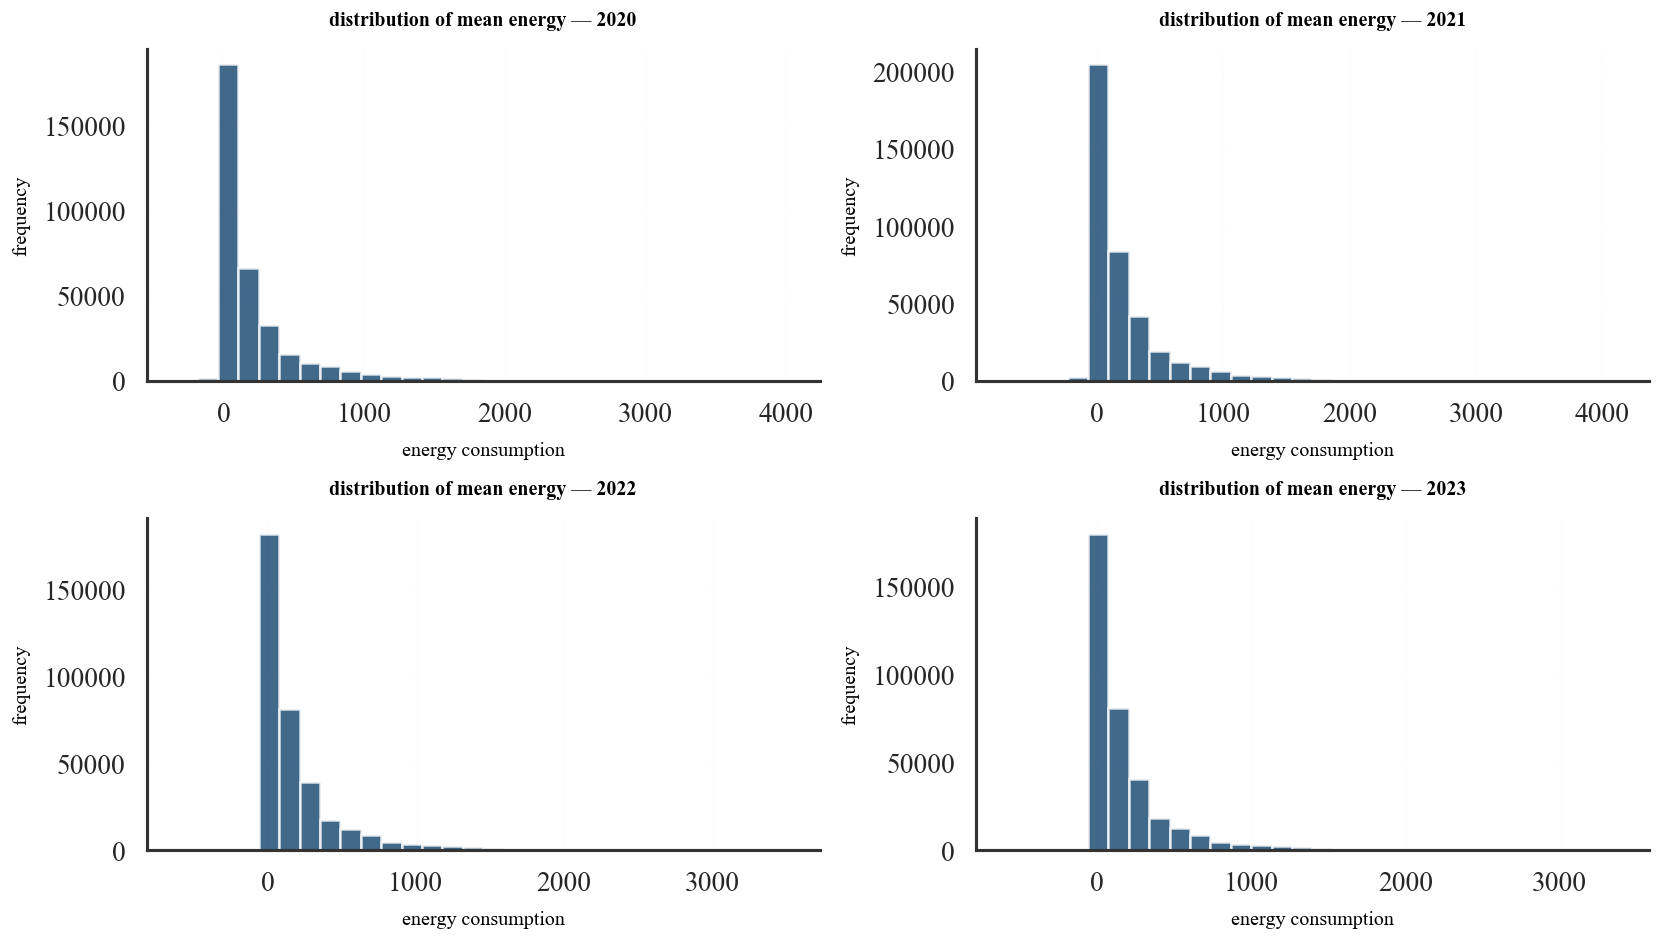

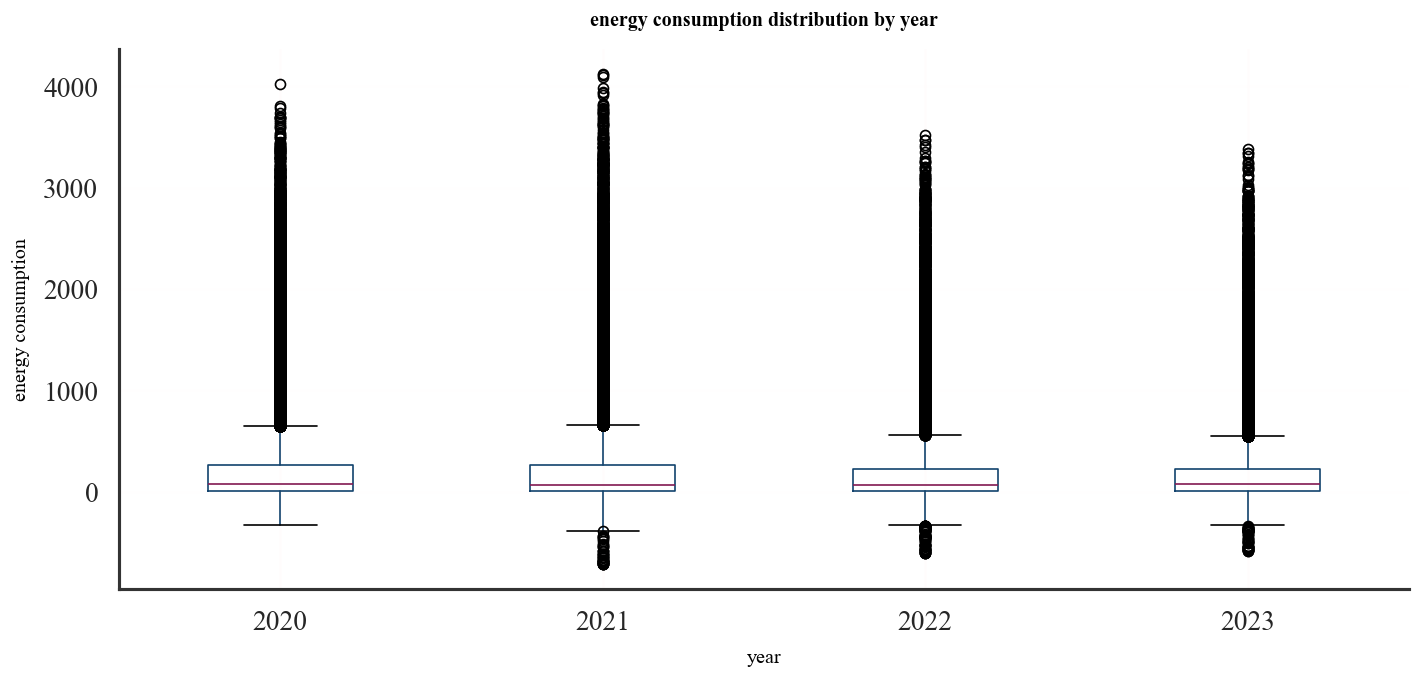


📈 creating cross-year visuals...


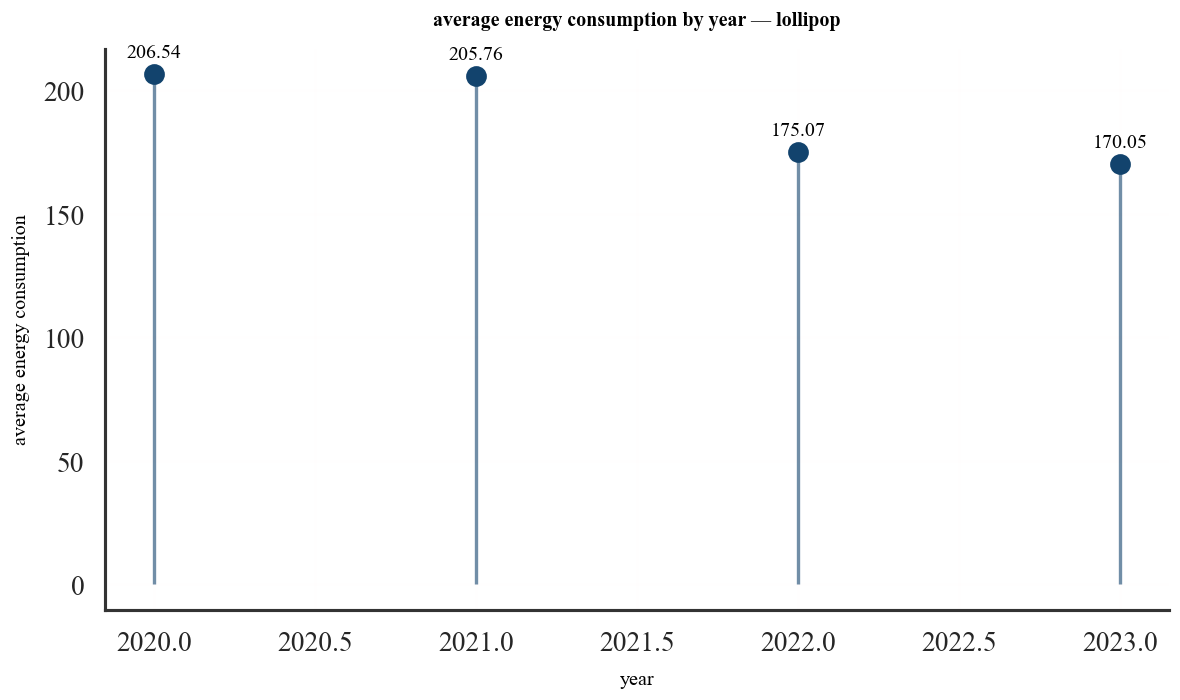

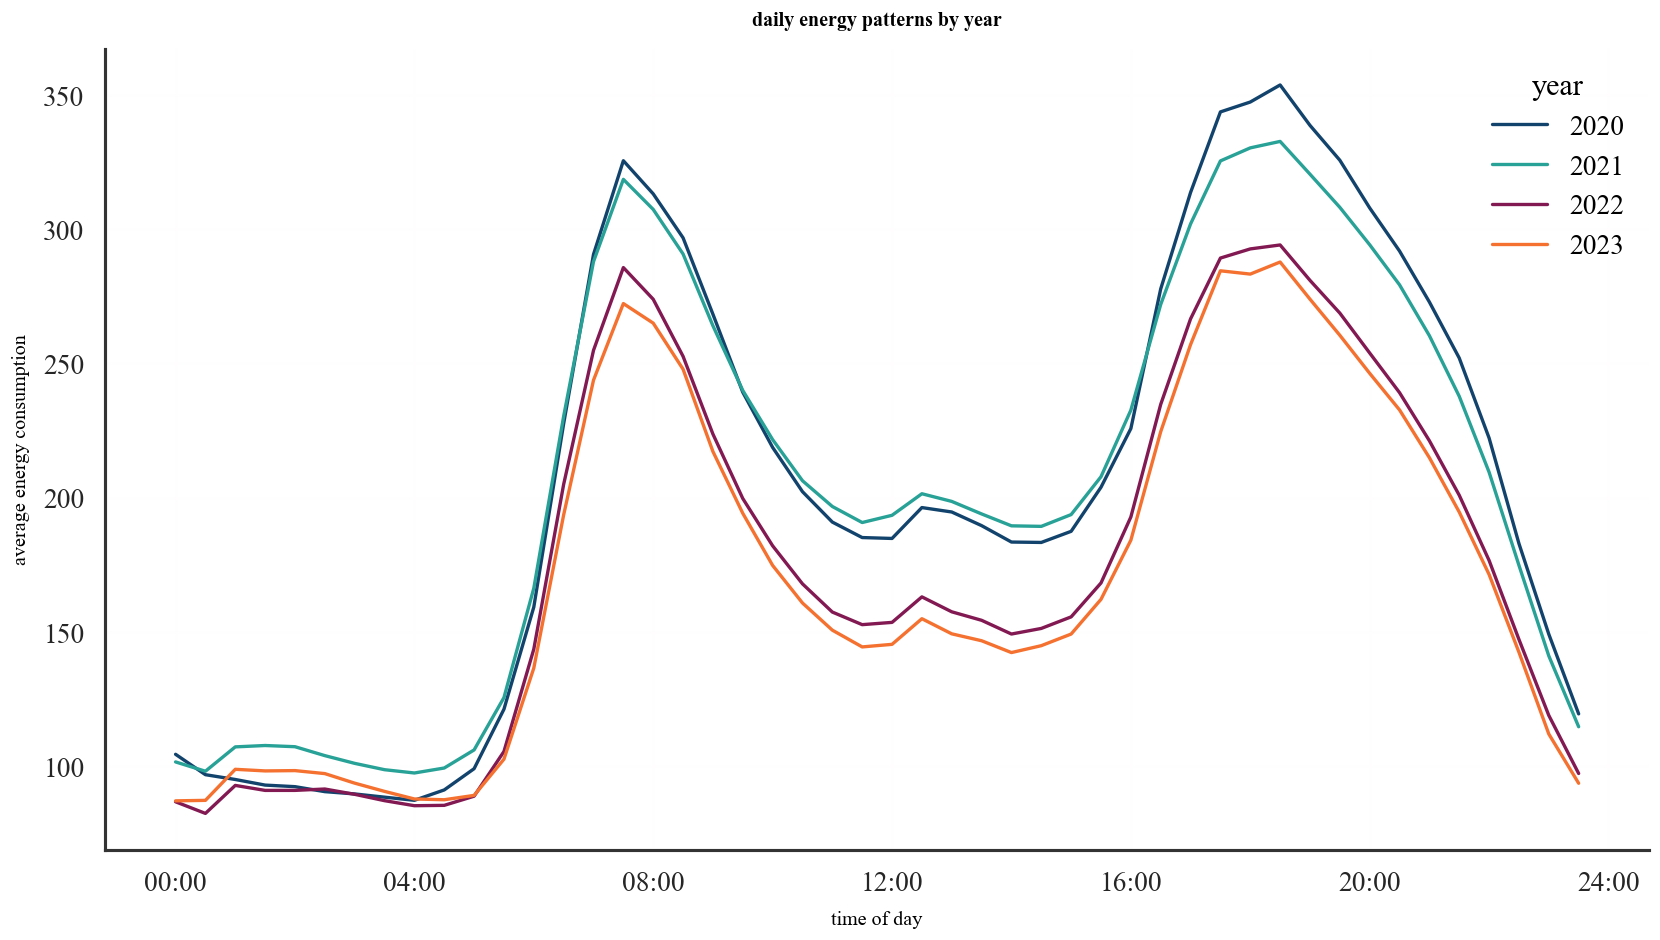

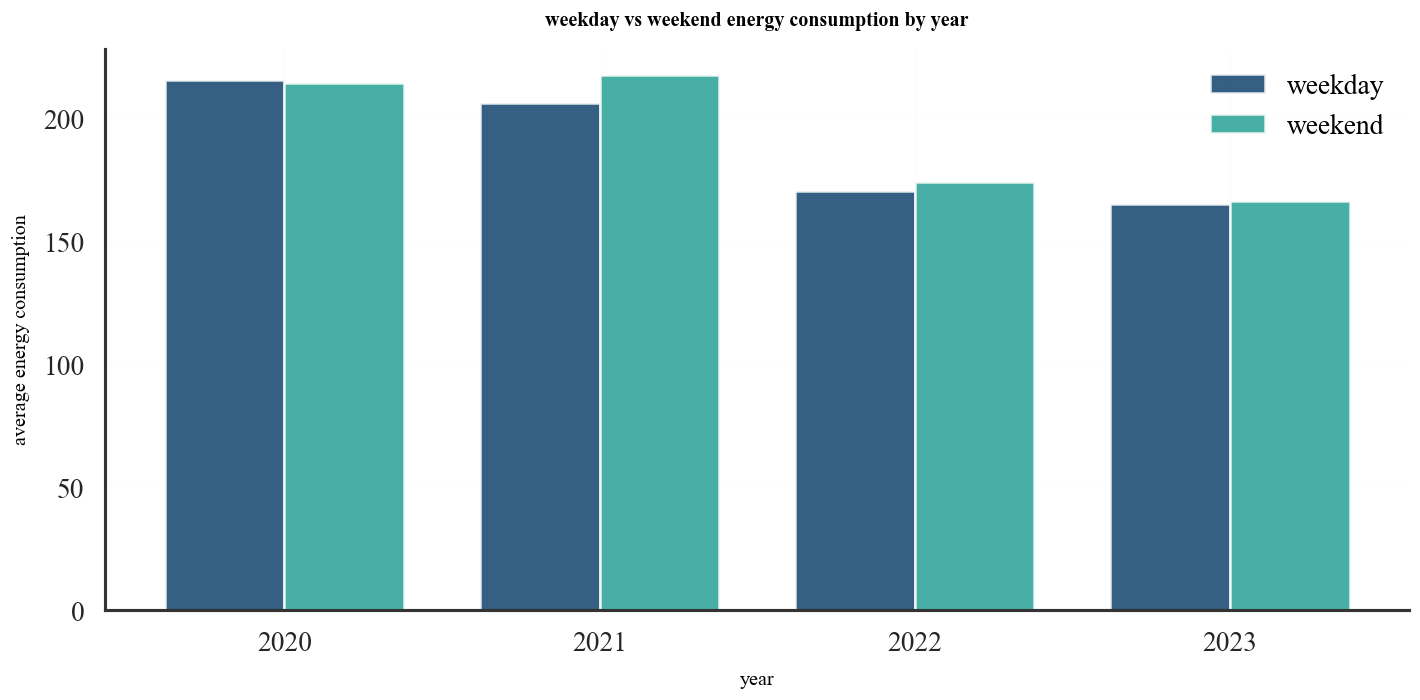

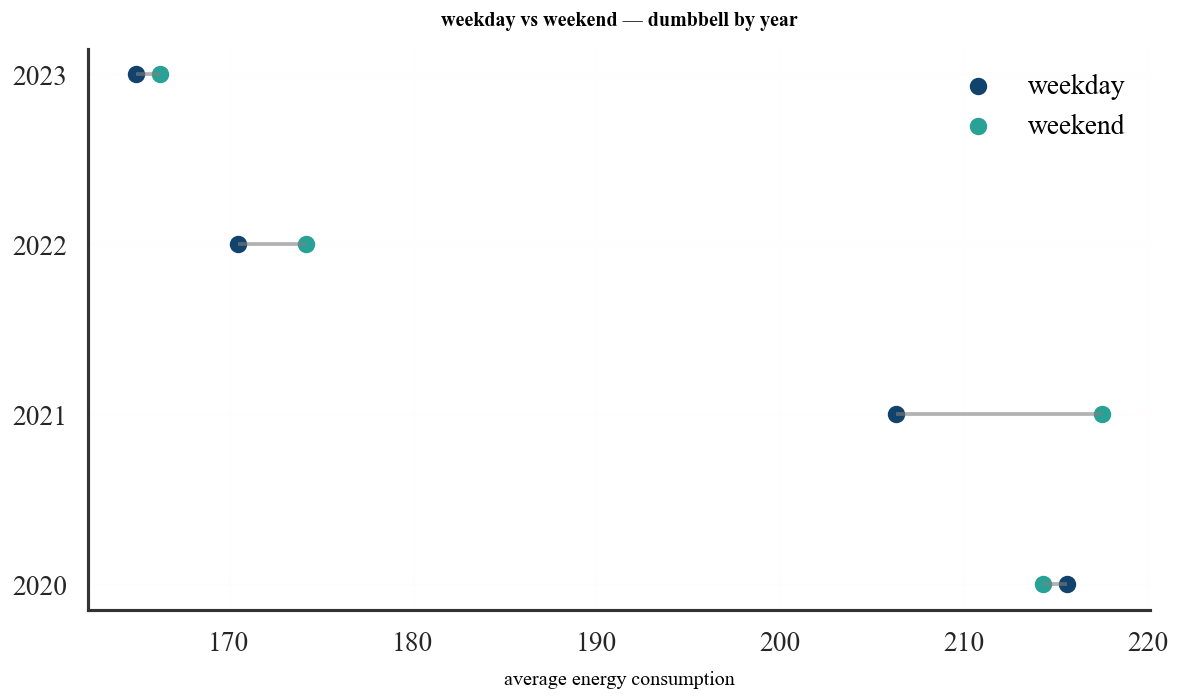

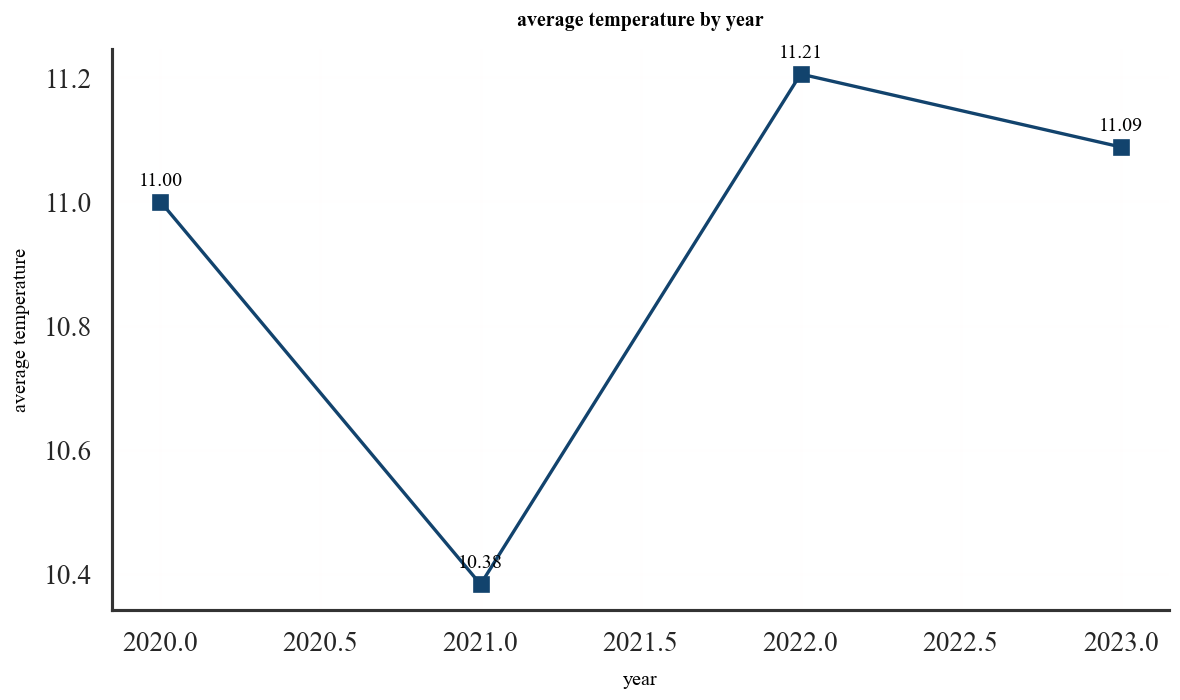


🎨 adding diverse visuals...


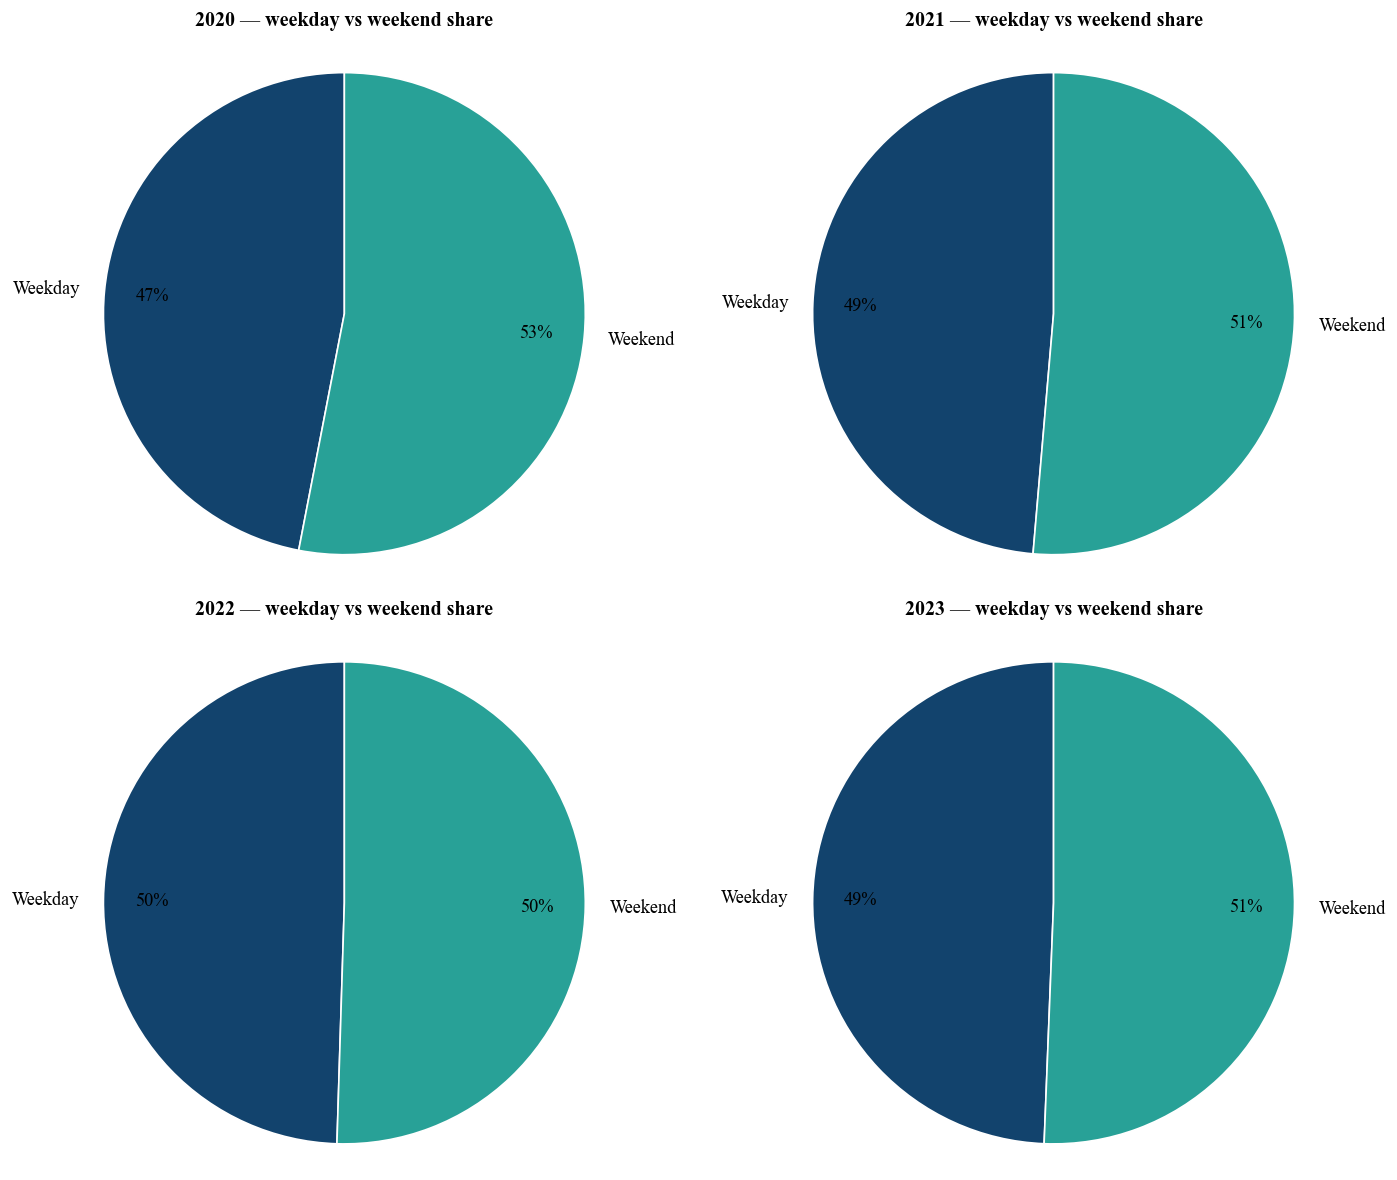

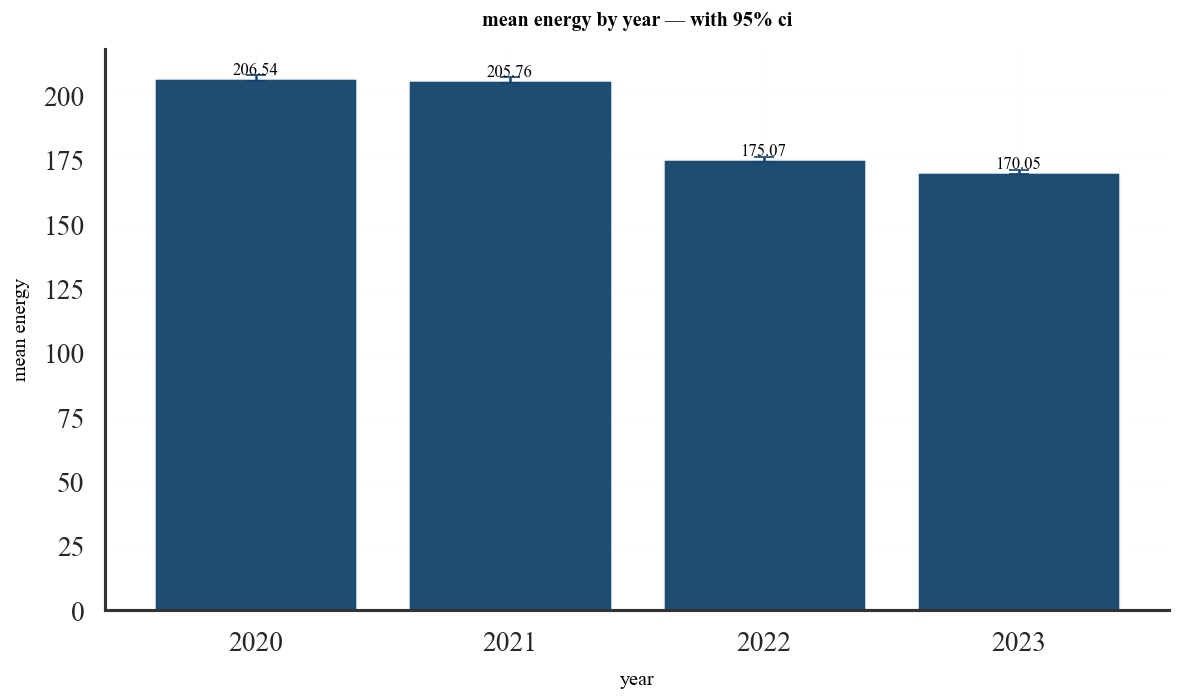

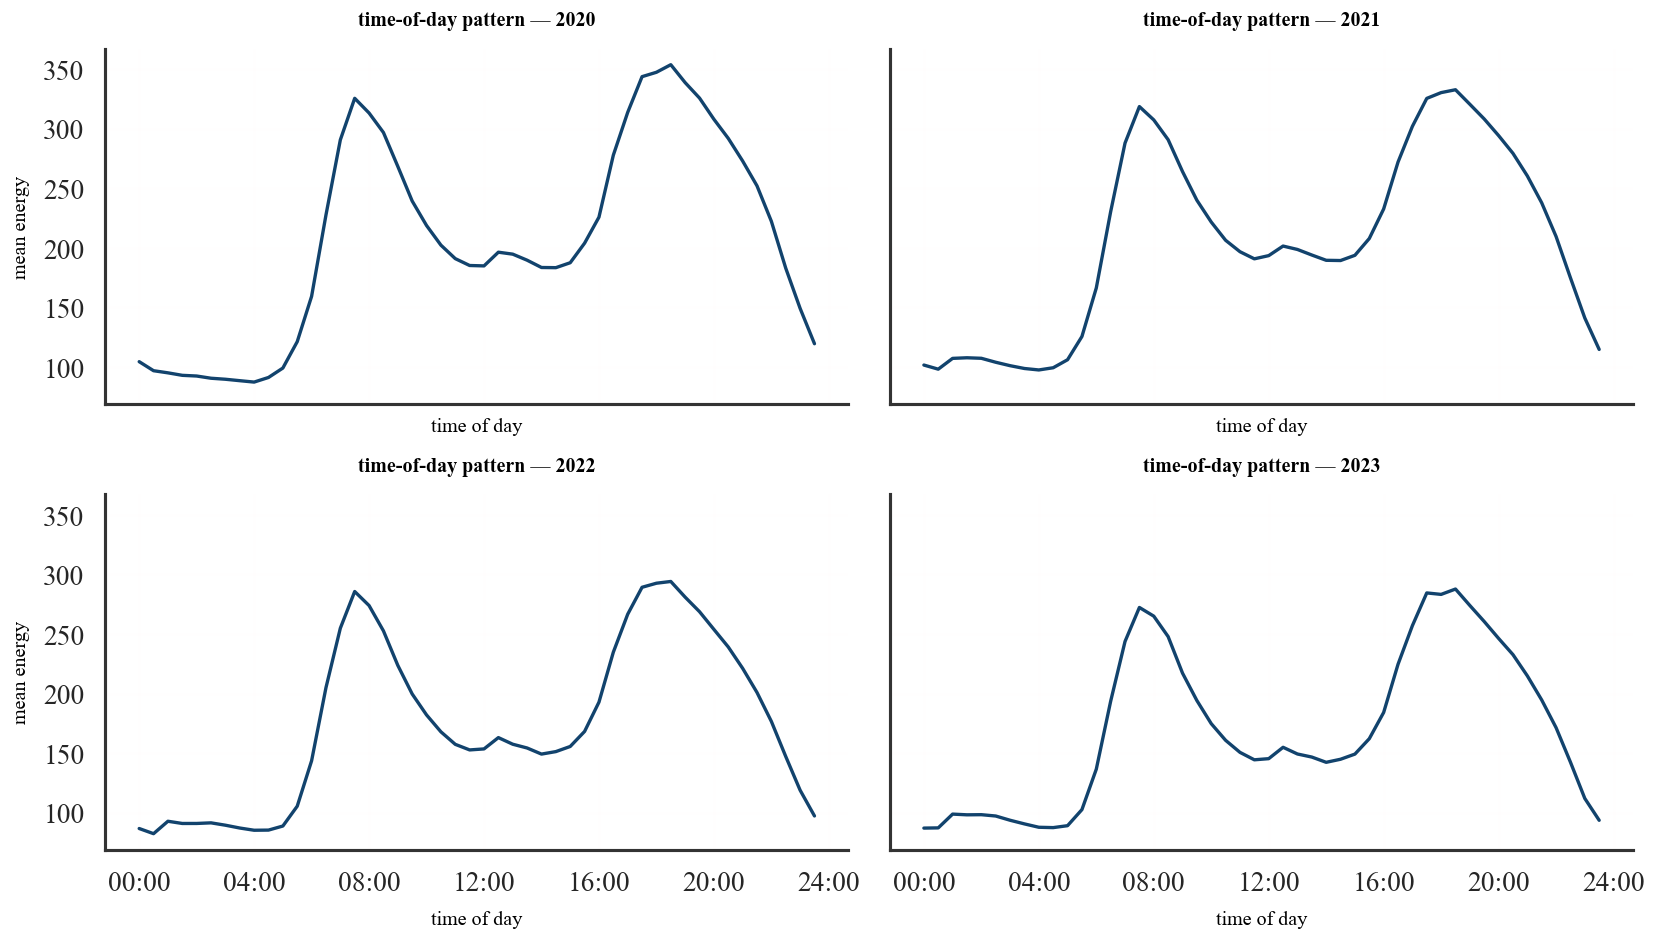

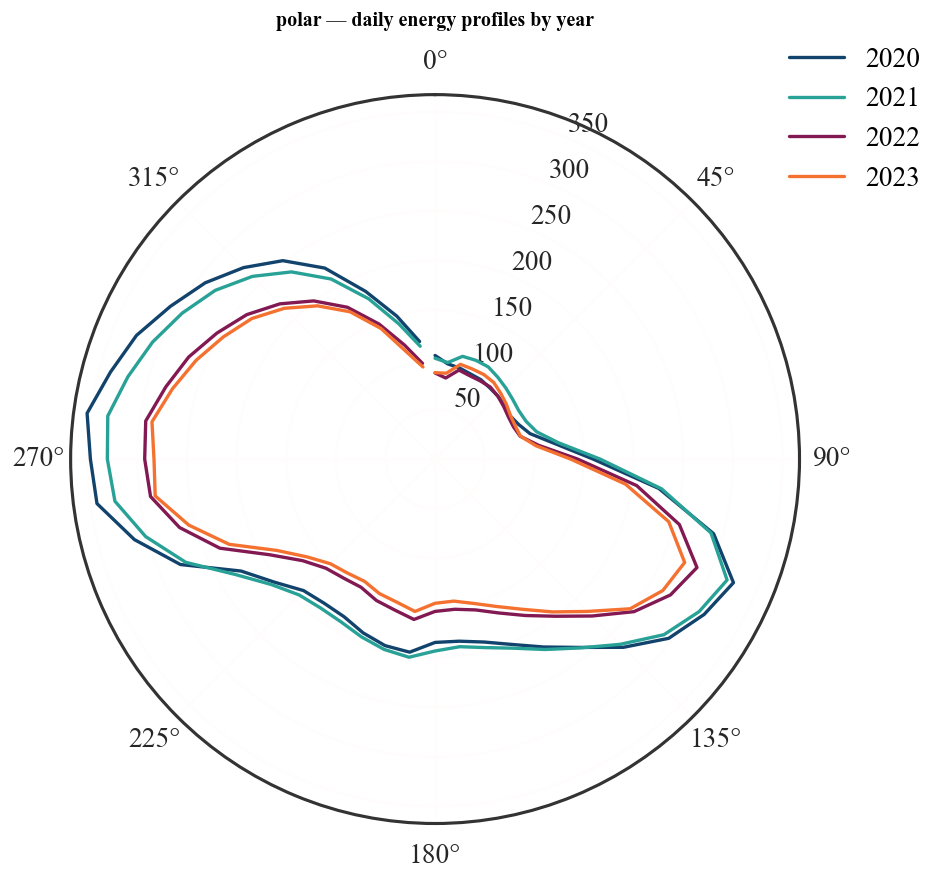


🔍 analyzing top quantities...

✨ deep-dive: electricity imports (wh)


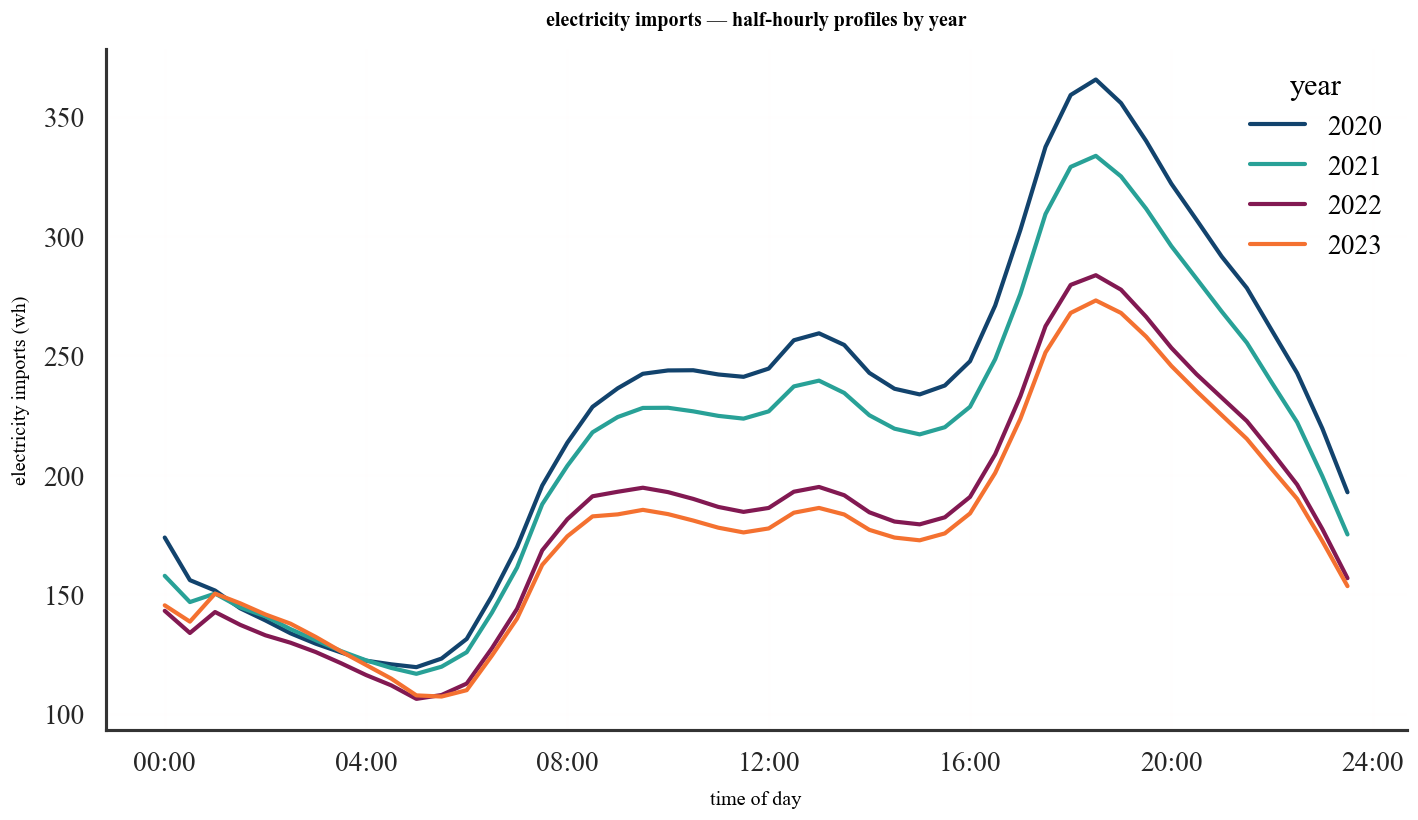

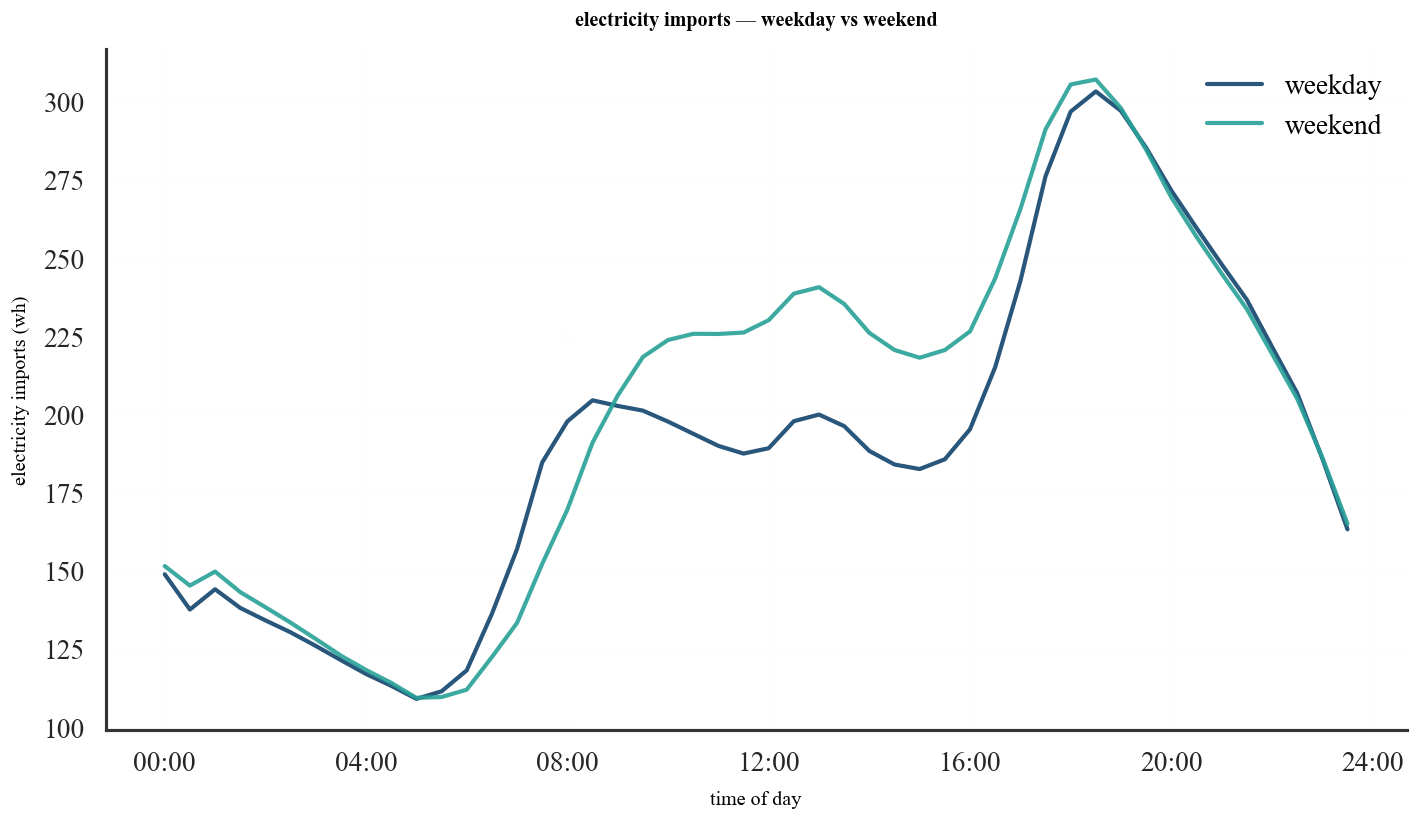

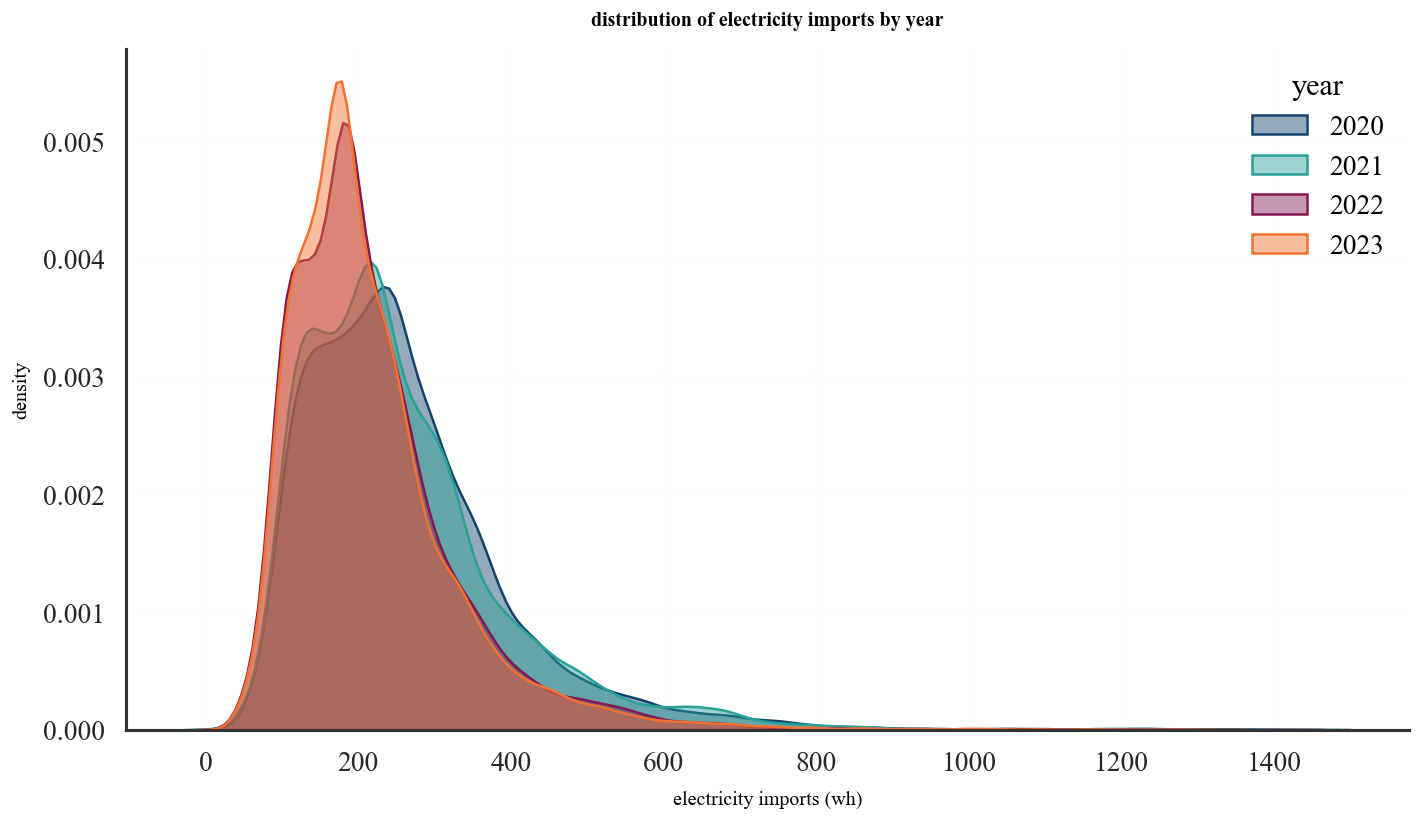

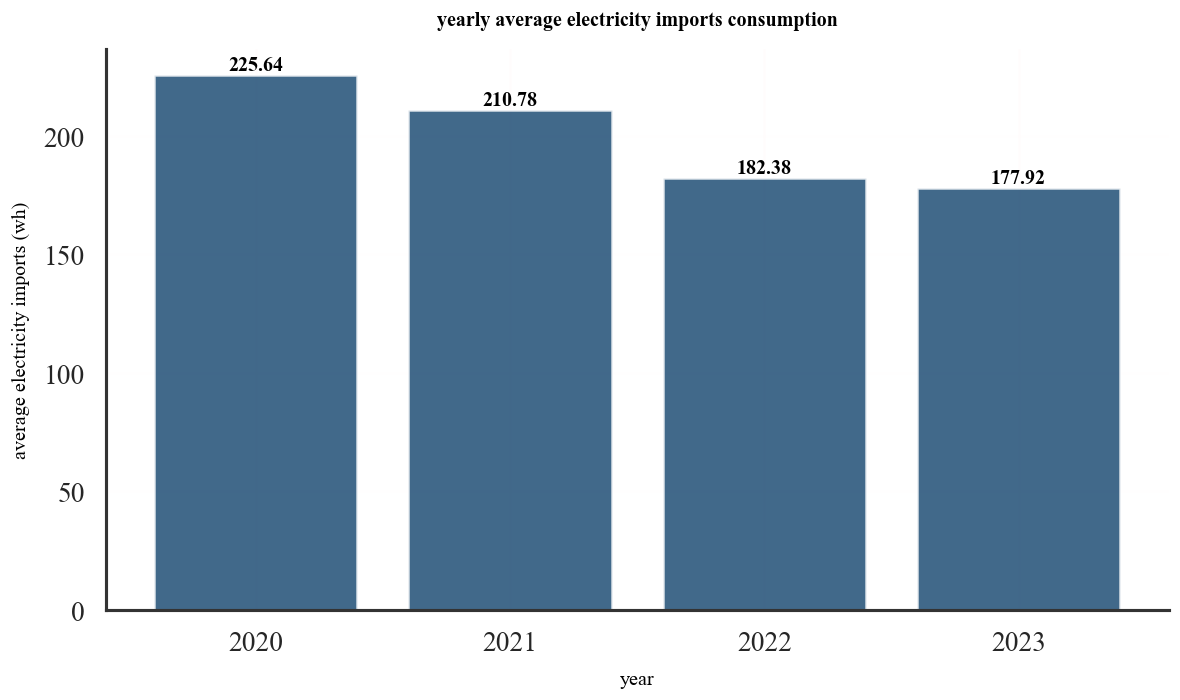

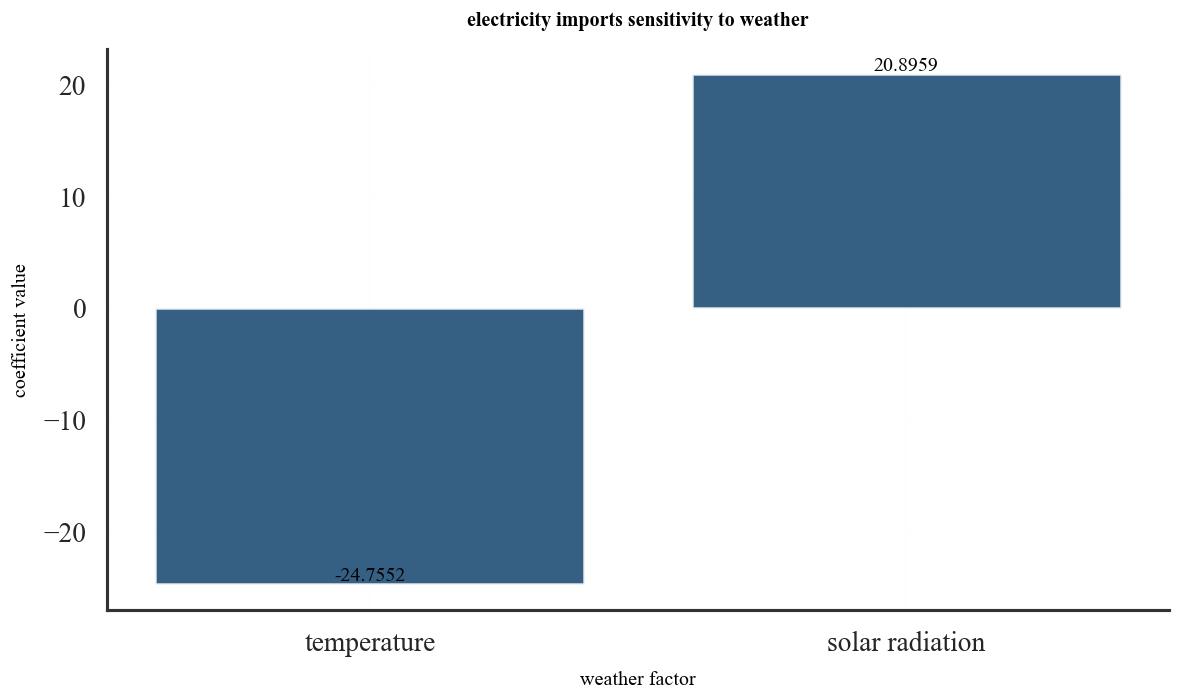

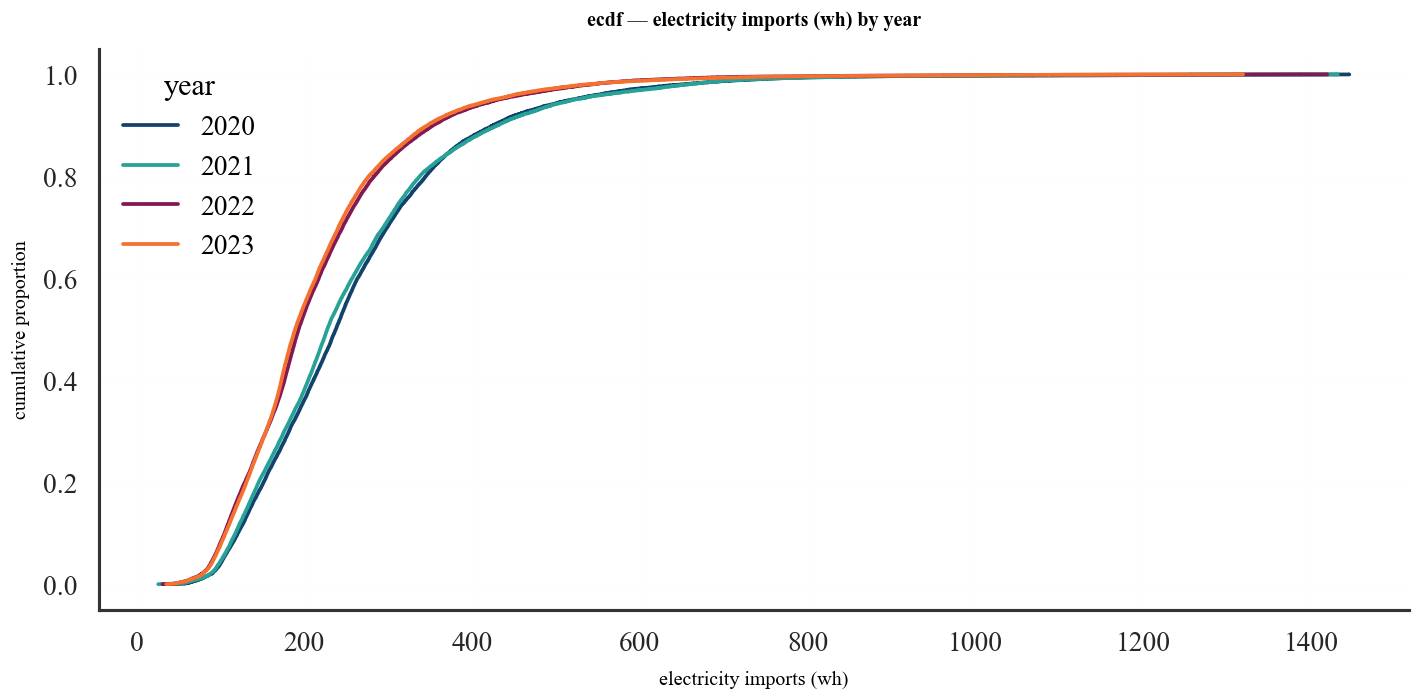

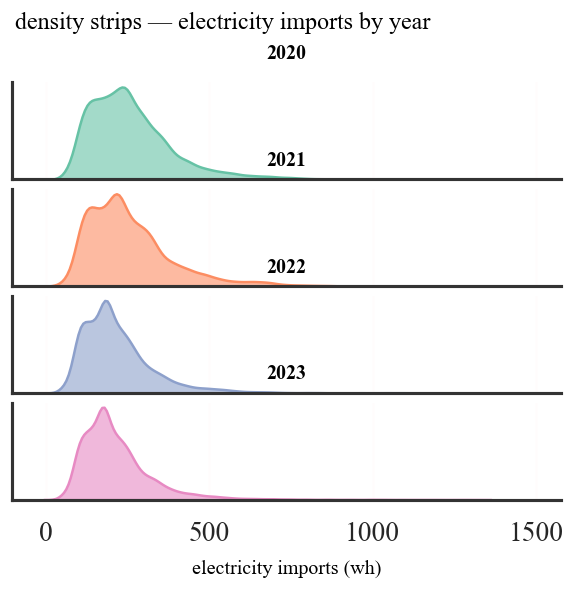


✨ deep-dive: electricity imports (wh/m2)


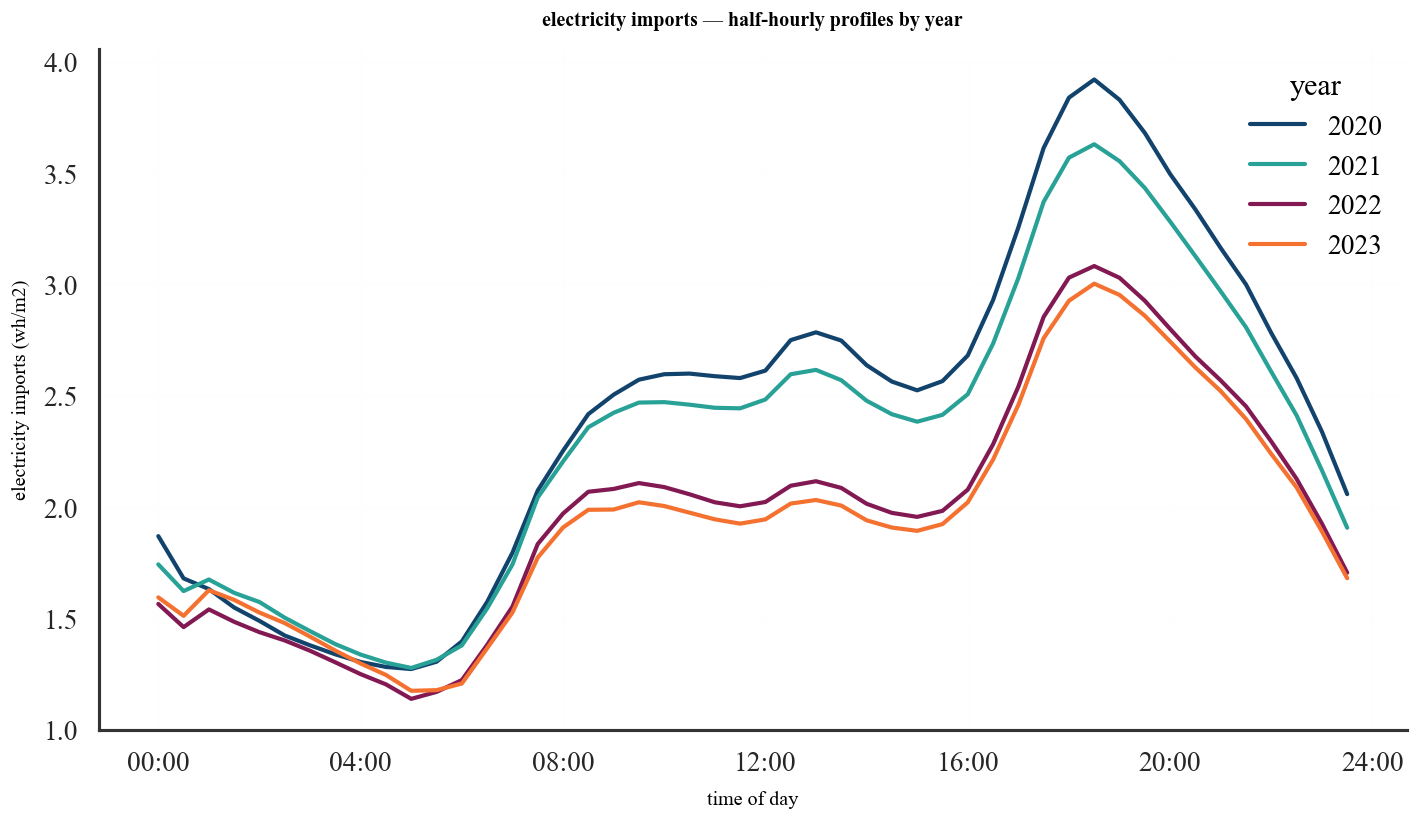

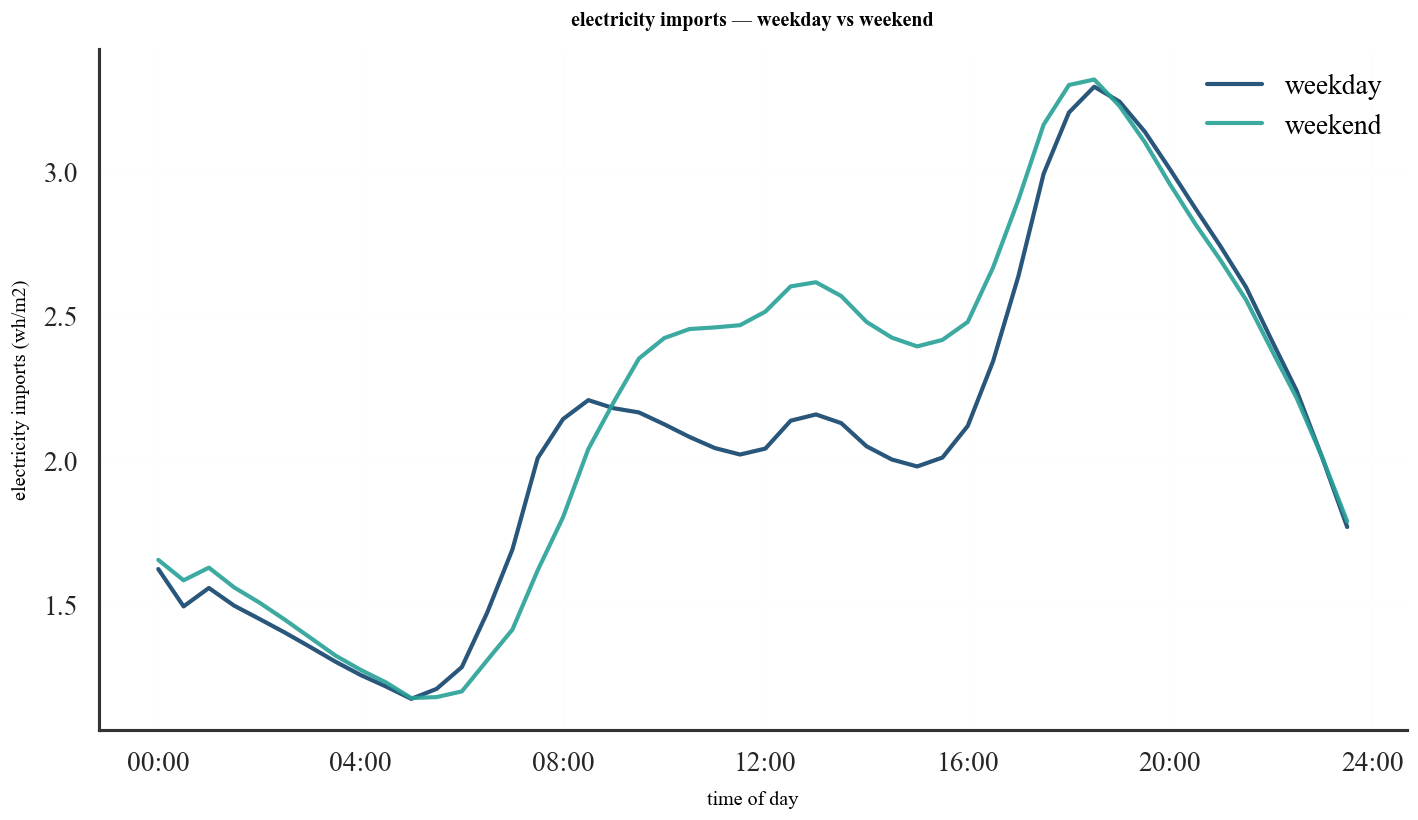

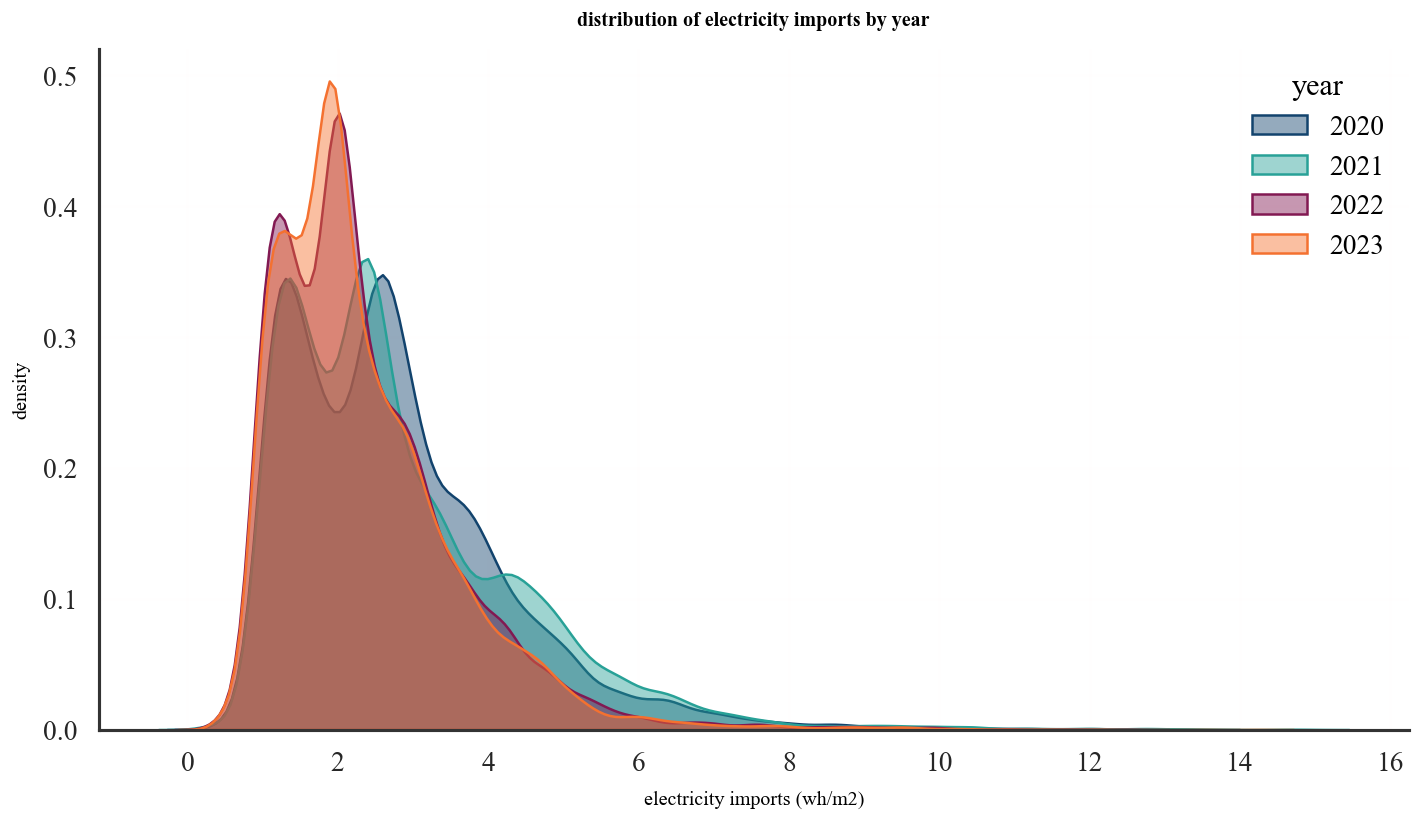

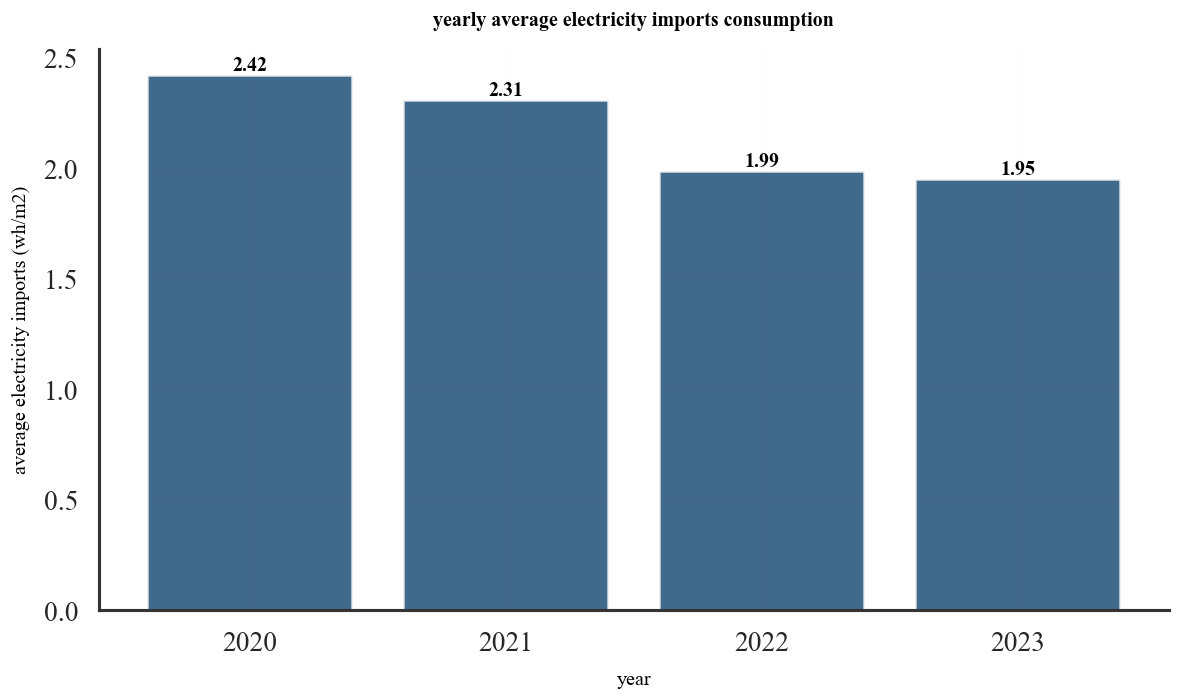

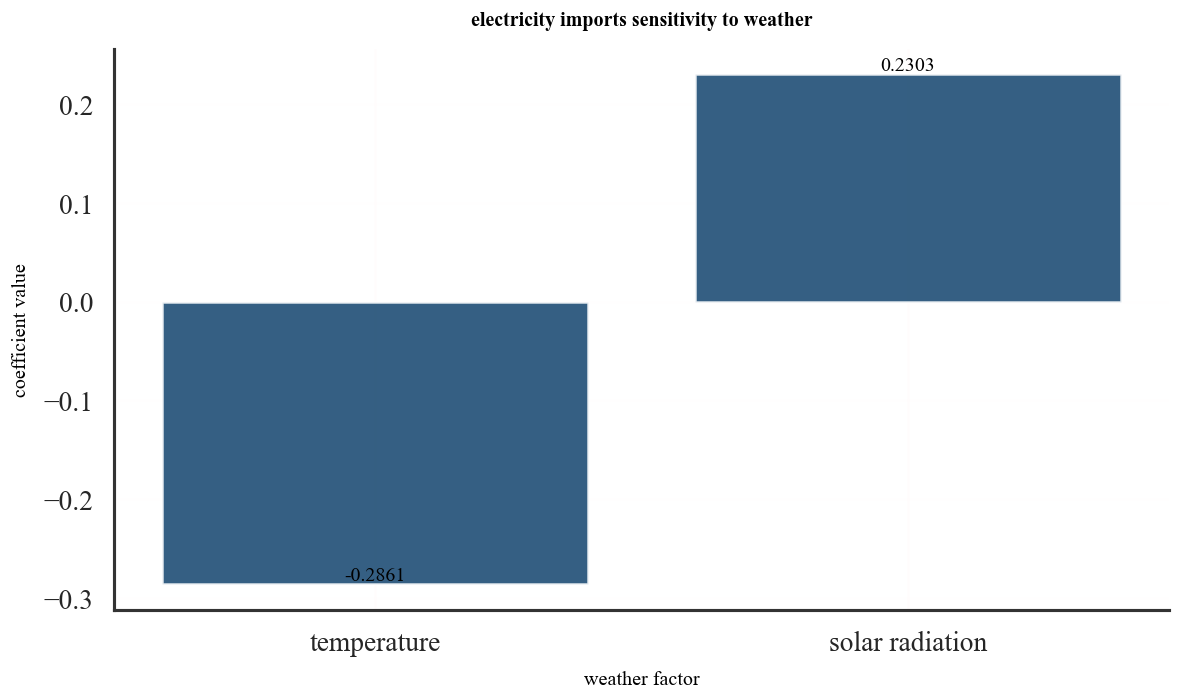

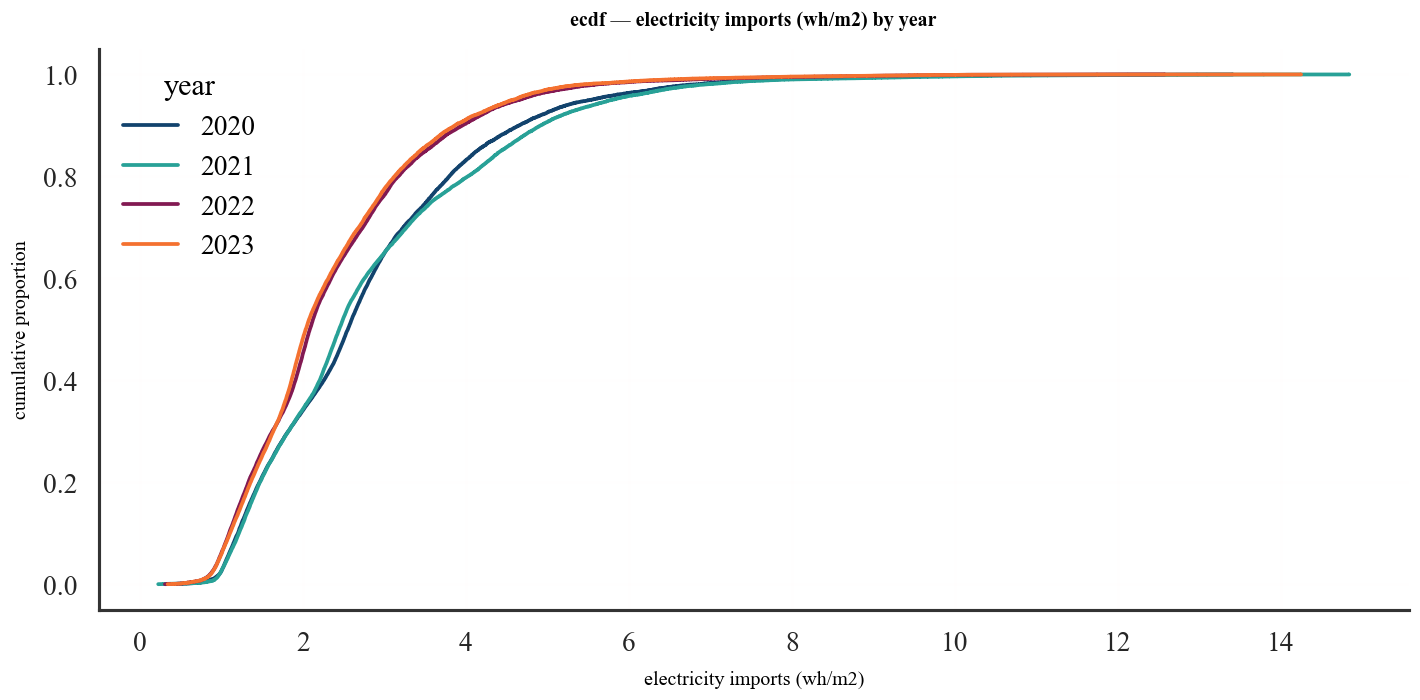

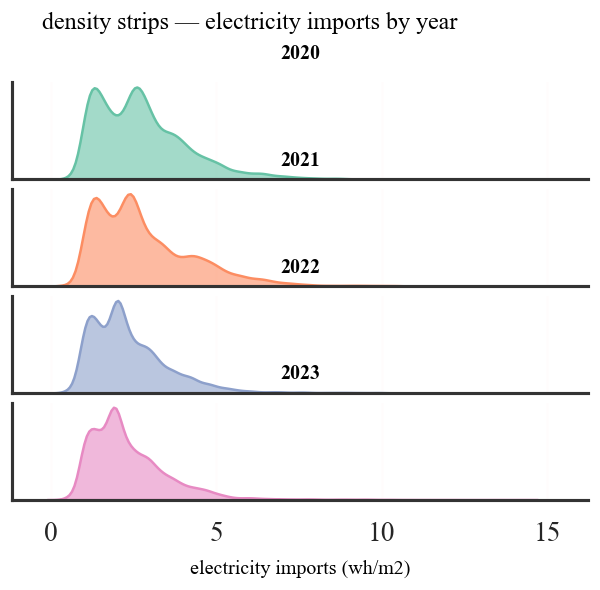


✨ deep-dive: electricity imports (wh/person)


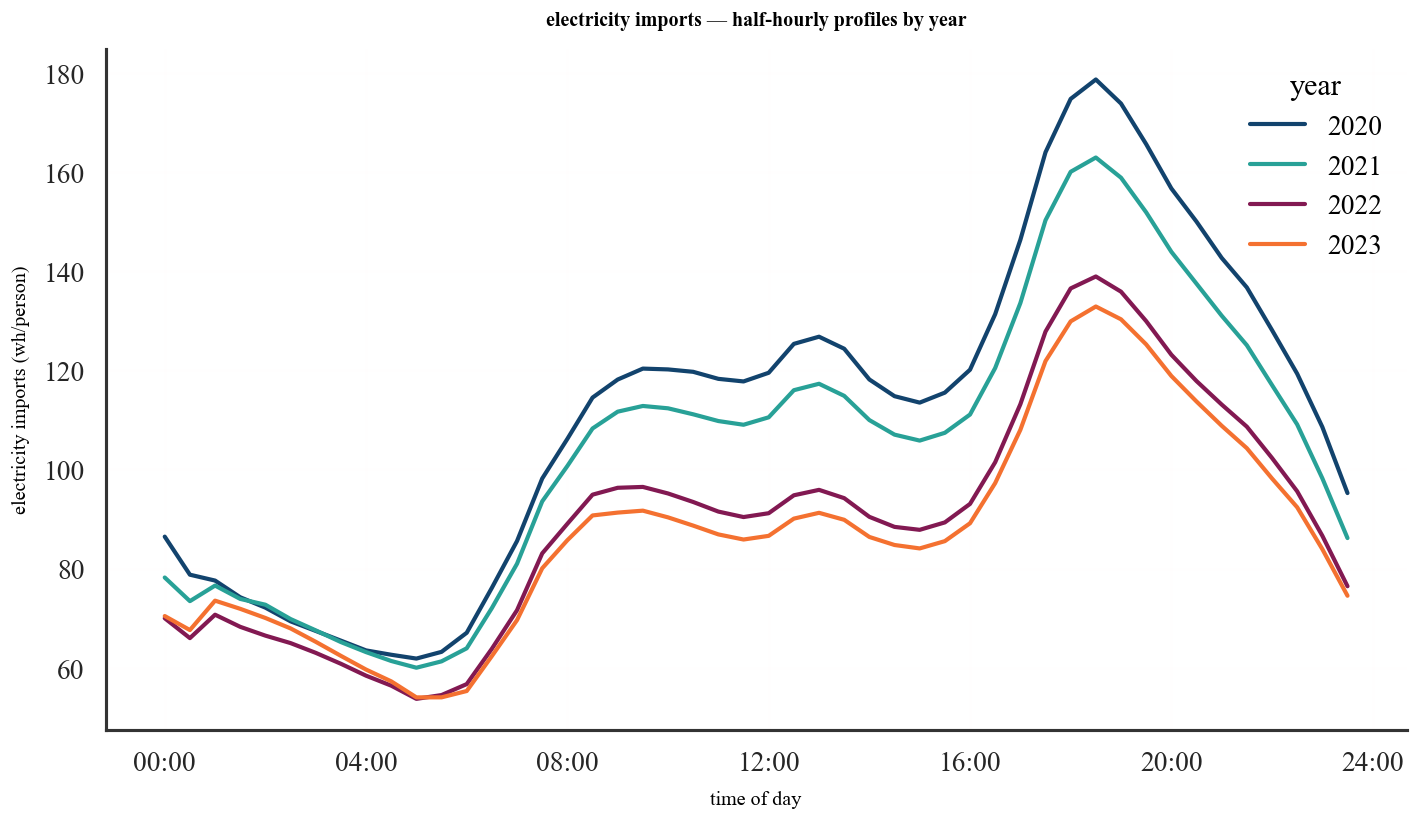

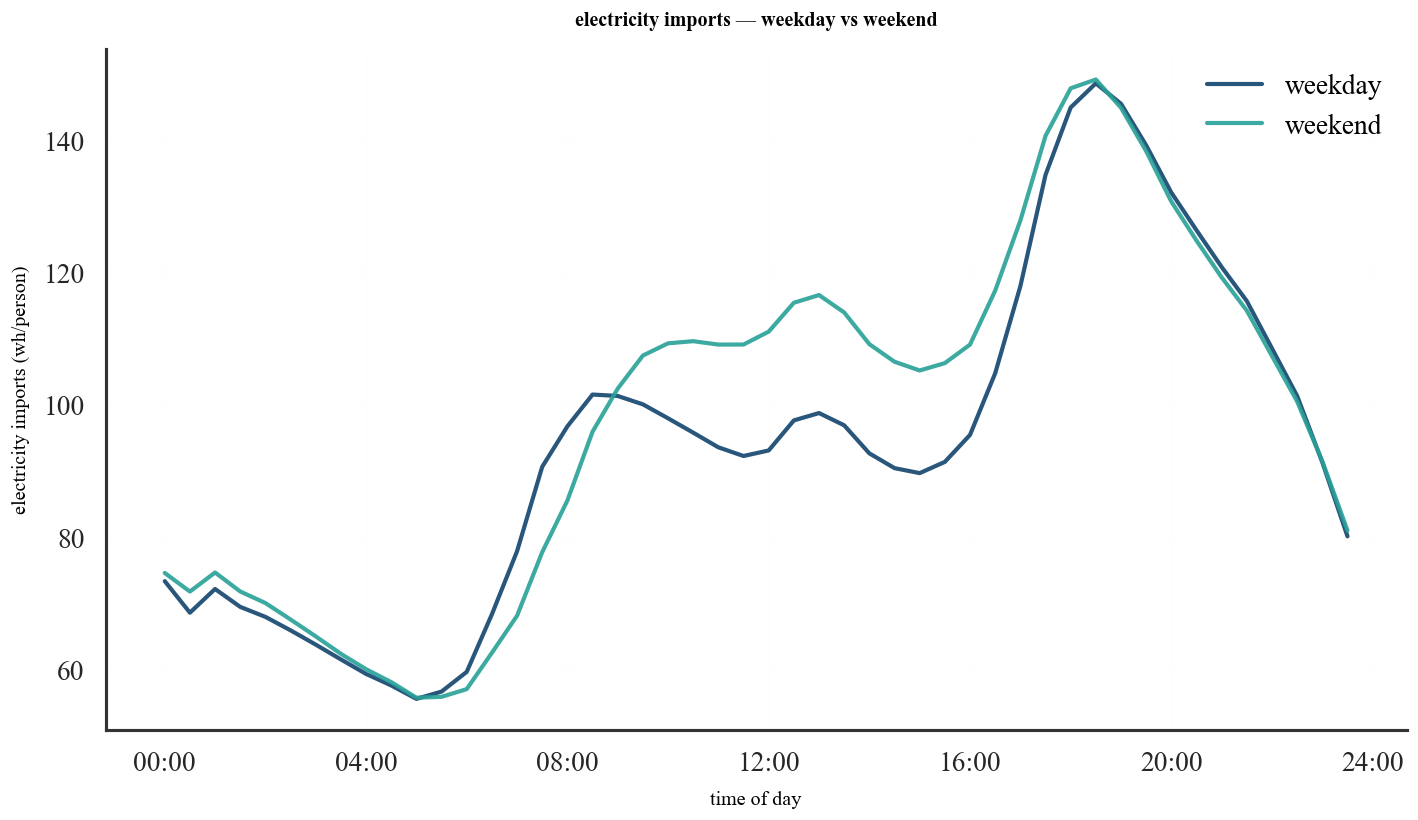

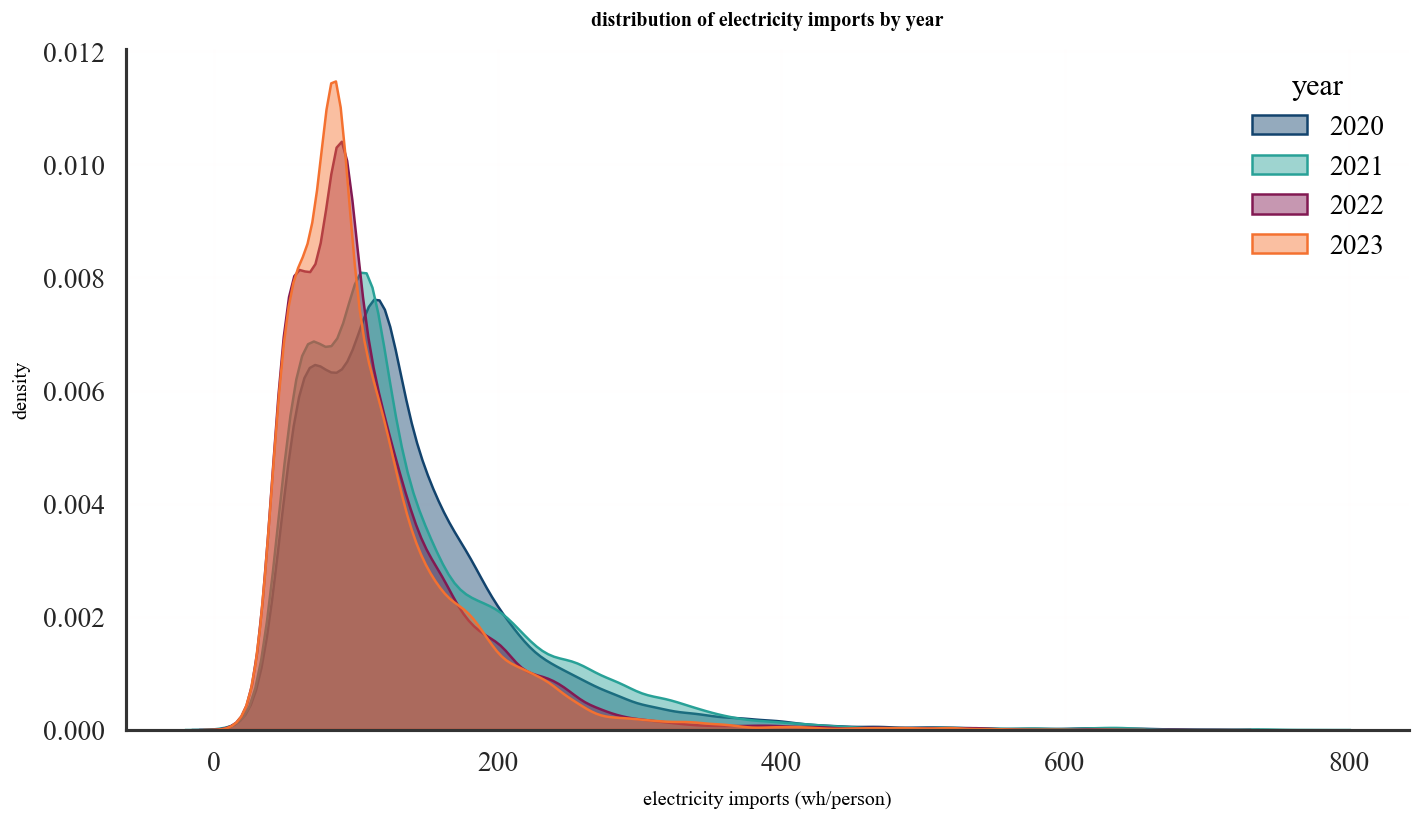

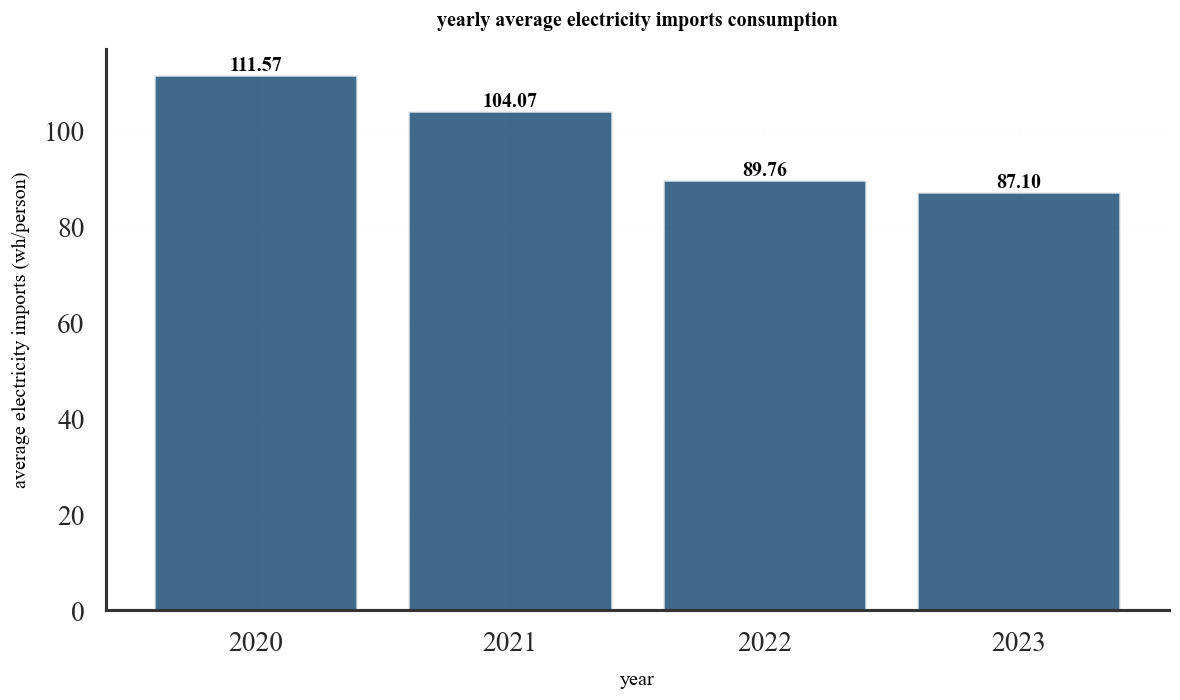

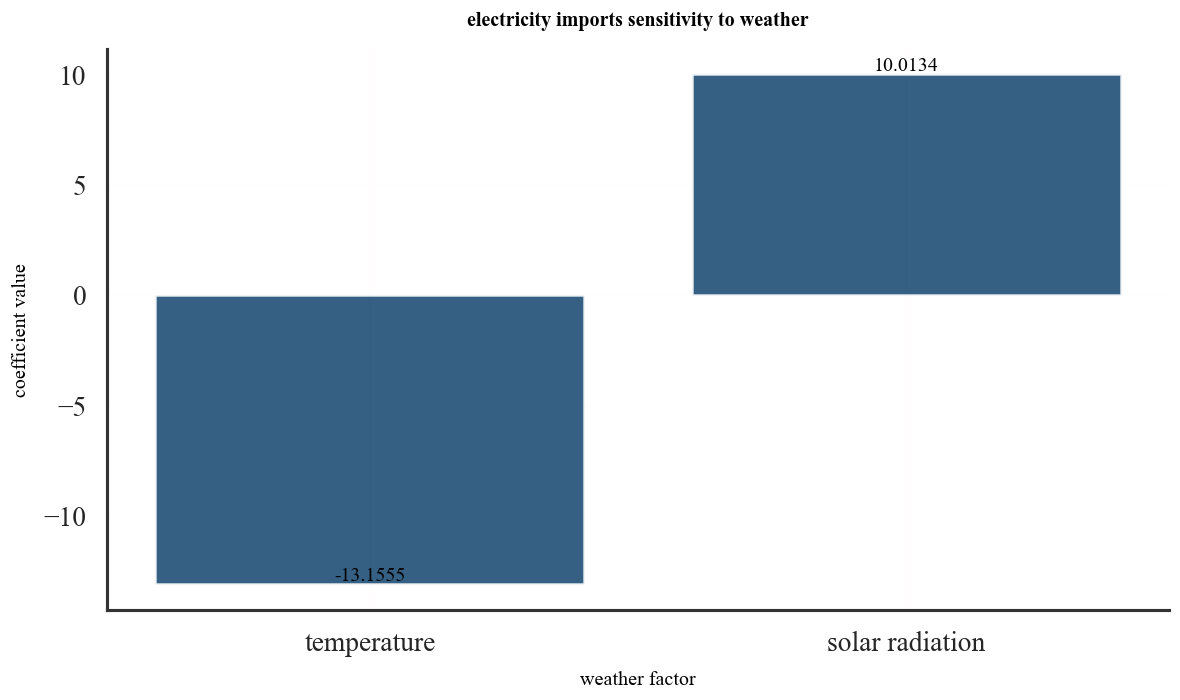

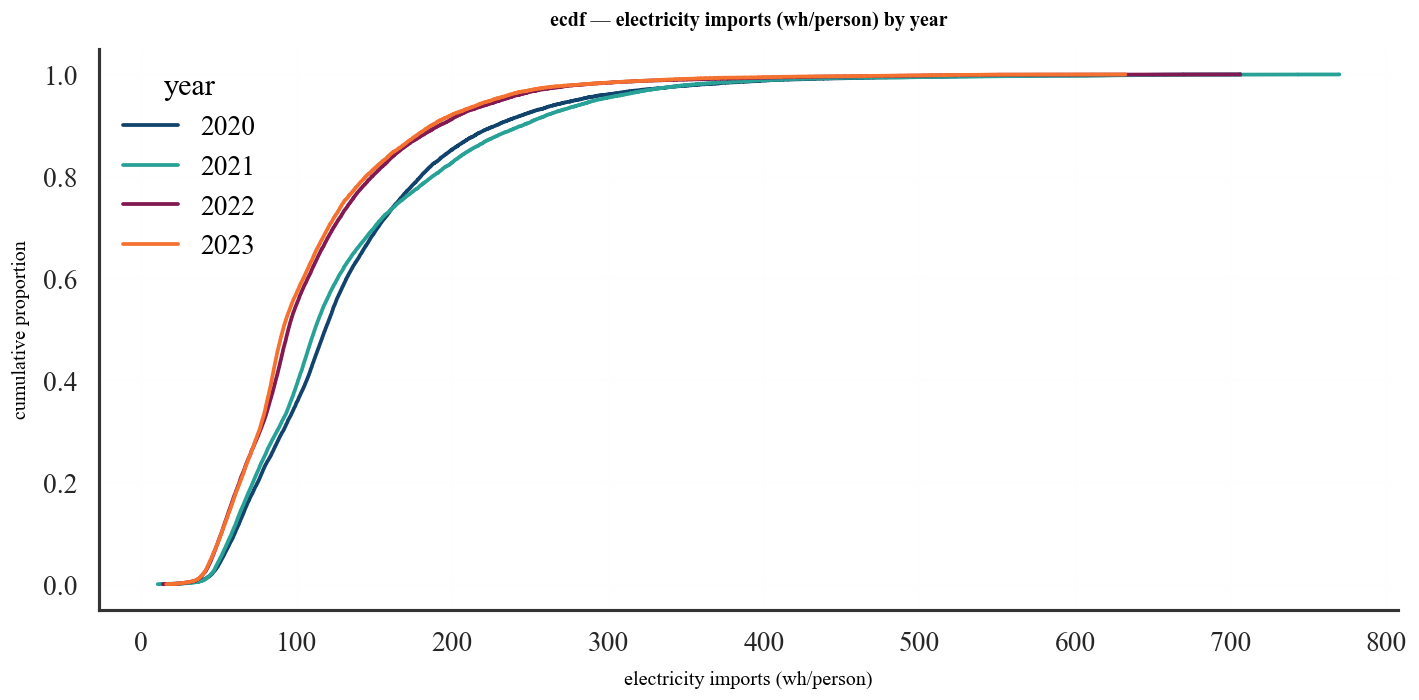

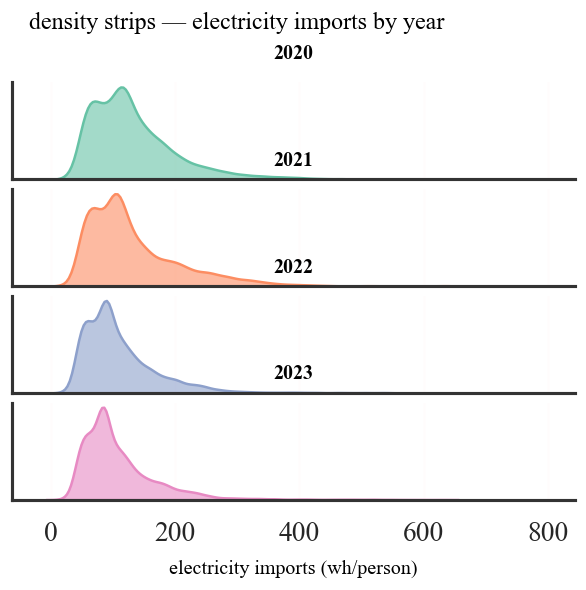


🧩 computing correlations...


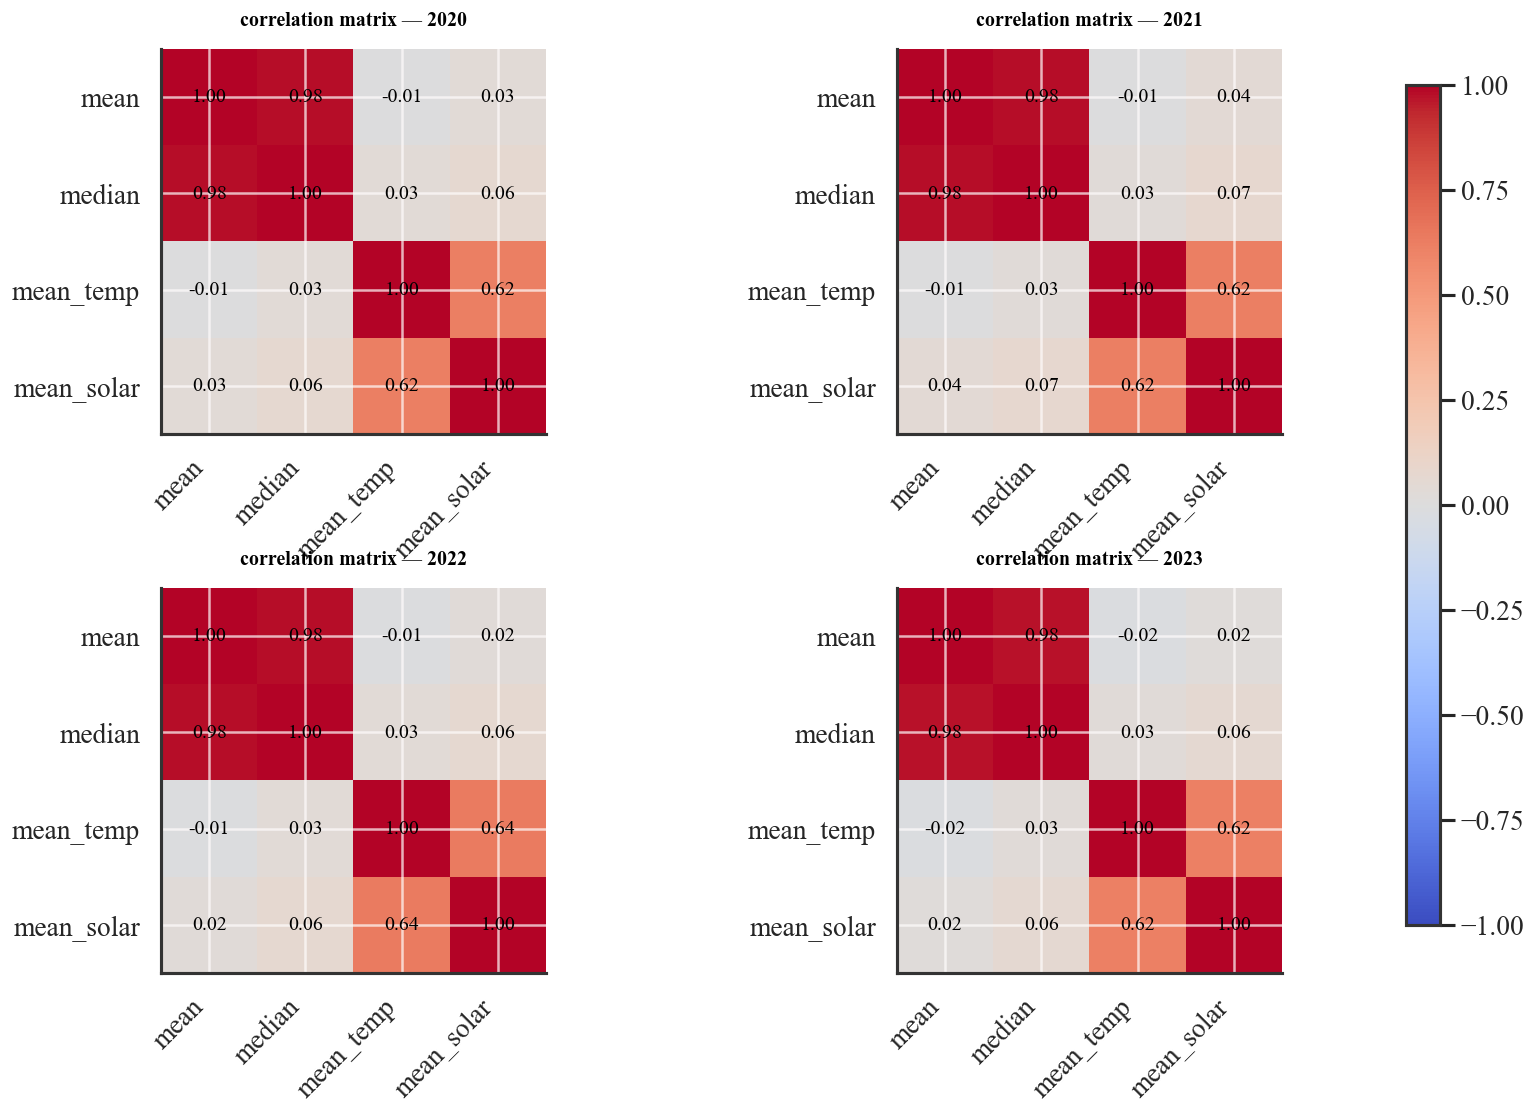


🌡️ temp vs energy structure...


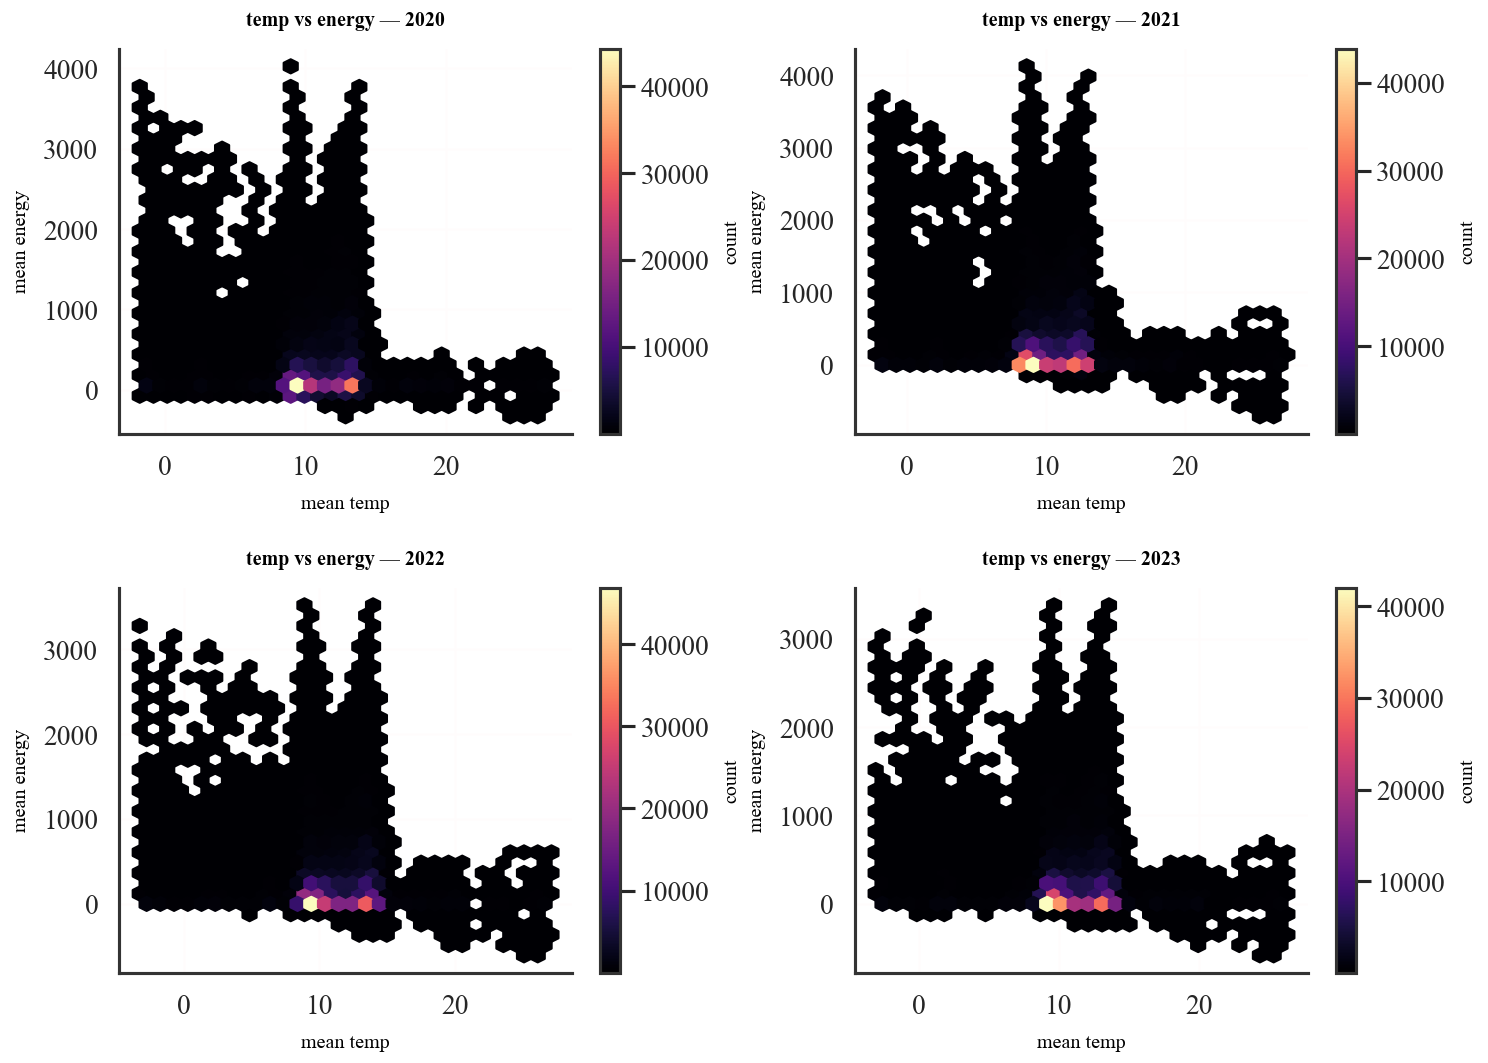


✅ analysis complete. figures saved to: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/figures


In [ ]:
# -*- coding: utf-8 -*-
"""serl multi-year energy analysis — unified, *and* visually diverse.

this script merges both of your earlier analysis scripts, **keeps every original
visualization**, and adds a bunch of new, more diverse charts (not just lines).
plots are styled consistently and saved under `figures/`.

google-style docstrings. lots of lowercase comments explaining intent.
"""

# =============================================================================
# setup & environment check
# =============================================================================

# seed first for reproducibility
import os
import sys
import random
import json
import platform
from datetime import datetime

SEED = 42  # keep runs deterministic enough
random.seed(SEED)

ENV_SNAPSHOT = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "seed": SEED,
}

# core libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# optional modelling
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from matplotlib.colors import LinearSegmentedColormap

# ---- Clean, neutral plotting defaults (white background, subtle grid) ----
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "figure.facecolor": "#ffffff",
    "axes.facecolor": "#ffffff",
    "axes.edgecolor": "#333333",
    "grid.color": "#FFFCFC",
    "grid.alpha": 0.7,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "legend.frameon": False,
    "text.color": "#000000",        # (optional) any free text black
    "axes.titlecolor": "#000000",   # make all axes titles black
    "axes.labelcolor": "#000000",   # make all axes labels black

})
# Pastel palette + Times New Roman headings
COLORS = [
    "#12436D",  # dark blue
    "#28A197",  # teal
    "#821952",  # maroon
    "#F47130",  # orange
    "#8B8888",  # dark gray
    "#A285D1",  # lavender
    "#7DA7D9",  # periwinkle
    "#E6A0B6",  # blush
    "#9B72CF",  # orchid
    "#A7C7A5",  # sage
]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.family':'serif','font.serif':['Times New Roman','Times','serif']})

BRAND_CMAP = LinearSegmentedColormap.from_list("brand", COLORS, N=256)

# =============================================================================
# configuration
# =============================================================================

BASE_DIR = Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025")
DATA_DIR = BASE_DIR / "data" / "csv"
FIGURES_DIR = BASE_DIR / "figures"
REPRO_DIR = BASE_DIR / "repro"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPRO_DIR.mkdir(parents=True, exist_ok=True)

YEAR_FILES = {
    2020: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv",
    2021: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv",
    2022: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv",
    2023: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv",
}



# =============================================================================
# utilities
# =============================================================================

def write_env_snapshot(path: Path) -> None:
    """Write environment snapshot for reproducibility.

    Args:
        path: destination json file path.

    Returns:
        None.
    """
    # we log env info so results can be reproduced later.
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(ENV_SNAPSHOT, f, indent=2)
    except Exception as e:
        # non-fatal; continue analysis
        print(f"could not write env snapshot: {e}")


def sanitize_filename(name: str) -> str:
    """Return a filesystem-safe version of `name`.

    Args:
        name: arbitrary string (e.g., quantity or unit).

    Returns:
        A sanitized string with unsafe characters replaced.
    """
    # filenames must be safe across platforms.
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))


def _savefig(fig: plt.Figure, name: str) -> None:
    """Save figure to FIGURES_DIR with a clean filename.

    Args:
        fig: matplotlib figure.
        name: base filename without extension.

    Returns:
        None.
    """
    # consistent saving improves findability.
    safe = sanitize_filename(name)
    out = FIGURES_DIR / f"{safe}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")


def _format_time_axis(ax: plt.Axes) -> None:
    """Standardize x ticks to 00:00–24:00, 4h step.

    Args:
        ax: target axis.

    Returns:
        None.
    """
    # uniform time axis helps compare charts.
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])


# =============================================================================
# data loading & preprocessing
# =============================================================================

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and enrich a serl aggregated dataframe.

    Args:
        df: raw dataframe for a single or multiple years.

    Returns:
        A cleaned dataframe with normalized categories and time features.
    """
    # keep original intact while we transform.
    dfc = df.copy()

    # normalize text categories to lowercase for stable grouping.
    cat_cols = [
        "quantity",
        "unit",
        "weekday_weekend",
        "segmentation_variable_3",
        "segment_3_value",
    ]
    for col in cat_cols:
        if col in dfc.columns:
            dfc[col] = dfc[col].astype(str).str.strip().str.lower()

    # parse time from 'summary_time' like 'HH:MM' to hour / minute / half_hour.
    if "summary_time" in dfc.columns:
        tp = dfc["summary_time"].astype(str).str.extract(r"(\d{1,2}):(\d{2})")
        dfc["hour"] = pd.to_numeric(tp[0], errors="coerce")
        dfc["minute"] = pd.to_numeric(tp[1], errors="coerce")
        dfc["half_hour"] = dfc["hour"] * 2 + (dfc["minute"] >= 30).astype(int)
        dfc["time_index"] = dfc["half_hour"] / 2.0  # hours since midnight for plots

    # coerce known numeric columns
    num_cols = ["mean", "median", "standard_deviation", "mean_temp", "mean_solar", "n_rounded"]
    for col in num_cols:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc


def load_all_years() -> pd.DataFrame:
    """Load 2020–2023 csvs, tag with year, and preprocess.

    Returns:
        Combined tidy dataframe across available years.

    Raises:
        FileNotFoundError: if none of the files are found.
    """
    # we load lazily and tolerate missing years.
    dfs = []
    for year, path in YEAR_FILES.items():
        if not path.exists():
            print(f"⚠️ missing file for {year}: {path}")
            continue
        dfi = pd.read_csv(path)
        dfi["year"] = int(year)
        dfs.append(dfi)

    if not dfs:
        raise FileNotFoundError("no serl csv files found — check DATA_DIR paths")

    df_all = pd.concat(dfs, ignore_index=True)
    df_all = preprocess_data(df_all)
    print(f"✅ combined shape: {df_all.shape}")
    return df_all


# =============================================================================
# original visualizations (kept intact)
# =============================================================================

def yearly_univariate_analysis(df: pd.DataFrame) -> list[int]:
    """Print basic stats per year and plot histograms + boxplot.

    Args:
        df: combined dataframe with 'year' and 'mean'.

    Returns:
        Sorted list of years present in the dataframe.
    """
    # quick sanity summaries build trust in the data.
    years = sorted(df["year"].dropna().unique().tolist())

    # basic stats per year
    print("\n📊 basic stats by year:")
    for y in years:
        yd = df[df["year"] == y]
        print(
            f"{y} → records={len(yd):,} | energy mean={yd['mean'].mean():.3f} | energy median={yd['median'].median():.3f}"
        )

    # distributions (mean) by year — histograms
    nrow = int(np.ceil(len(years) / 2))
    ncol = 2
    fig, axes = plt.subplots(nrow, ncol, figsize=(14, 4 * nrow))
    axes = np.ravel(axes)

    for i, y in enumerate(years):
        yd = df[df["year"] == y]["mean"].dropna()
        axes[i].hist(yd, bins=30, alpha=0.8)
        axes[i].set_title(f"distribution of mean energy — {y}")
        axes[i].set_xlabel("energy consumption")
        axes[i].set_ylabel("frequency")
        axes[i].grid(True, axis="y", alpha=0.3)

    # hide empty axes if any
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    _savefig(fig, "yearly_energy_distributions")
    plt.show()

    # boxplot of mean by year
    fig, ax = plt.subplots(figsize=(12, 6))
    df.boxplot(column="mean", by="year", ax=ax)
    ax.set_title("energy consumption distribution by year")
    plt.suptitle("")  # remove default pandas title
    ax.set_ylabel("energy consumption")
    ax.set_xlabel("year")
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    _savefig(fig, "yearly_energy_boxplots")
    plt.show()

    return years


def plot_yearly_comparisons(df: pd.DataFrame, years: list[int]) -> None:
    """Cross-year comparisons: trend, daily pattern, weekday/weekend, temperature."""
    # 1) trend: average energy per year (lollipop instead of plain line)
    yearly_avg = df.groupby("year")["mean"].mean().reset_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.vlines(yearly_avg["year"], 0, yearly_avg["mean"], linewidth=2, alpha=0.6)  # stems
    ax.scatter(yearly_avg["year"], yearly_avg["mean"], s=120, zorder=3)
    ax.set_title("average energy consumption by year — lollipop")
    ax.set_xlabel("year")
    ax.set_ylabel("average energy consumption")
    ax.grid(True, alpha=0.3)
    for _, r in yearly_avg.iterrows():
        ax.annotate(f"{r['mean']:.2f}", (r["year"], r["mean"]), textcoords="offset points", xytext=(0, 10), ha="center")
    plt.tight_layout()
    _savefig(fig, "yearly_energy_trend_lollipop")
    plt.show()

    # 2) daily profiles across years (line)
    if "half_hour" in df.columns:
        daily = df.groupby(["year", "half_hour"]) ["mean"].mean().reset_index()
        fig, ax = plt.subplots(figsize=(14, 8))
        for y in years:
            yd = daily[daily["year"] == y]
            ax.plot(yd["half_hour"] / 2.0, yd["mean"], label=str(y), linewidth=2)
        ax.set_title("daily energy patterns by year")
        ax.set_xlabel("time of day")
        ax.set_ylabel("average energy consumption")
        _format_time_axis(ax)
        ax.legend(title="year")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        _savefig(fig, "yearly_daily_patterns")
        plt.show()

    # 3) weekday vs weekend per year (grouped bars kept)
    if "weekday_weekend" in df.columns:
        wd = df[df["weekday_weekend"].str.contains("weekday", na=False)]
        we = df[df["weekday_weekend"].str.contains("weekend", na=False)]
        wd_avg = wd.groupby("year")["mean"].mean().reset_index()
        we_avg = we.groupby("year")["mean"].mean().reset_index()

        fig, ax = plt.subplots(figsize=(12, 6))
        bar_width = 0.38
        x = np.arange(len(years))
        ax.bar(x - bar_width / 2, wd_avg["mean"], bar_width, label="weekday", alpha=0.85)
        ax.bar(x + bar_width / 2, we_avg["mean"], bar_width, label="weekend", alpha=0.85)
        ax.set_title("weekday vs weekend energy consumption by year")
        ax.set_xlabel("year")
        ax.set_ylabel("average energy consumption")
        ax.set_xticks(x)
        ax.set_xticklabels(years)
        ax.legend()
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        _savefig(fig, "yearly_weekday_weekend")
        plt.show()

        # 3b) same story as a dumbbell plot for variety
        merged = wd_avg.merge(we_avg, on="year", suffixes=("_weekday", "_weekend"))
        fig, ax = plt.subplots(figsize=(10, 6))
        y_pos = np.arange(len(merged))
        ax.hlines(y=y_pos, xmin=merged["mean_weekday"], xmax=merged["mean_weekend"], color="gray", alpha=0.6)
        ax.scatter(merged["mean_weekday"], y_pos, label="weekday", s=80)
        ax.scatter(merged["mean_weekend"], y_pos, label="weekend", s=80)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(merged["year"].astype(str))
        ax.set_xlabel("average energy consumption")
        ax.set_title("weekday vs weekend — dumbbell by year")
        ax.legend()
        ax.grid(True, axis="x", alpha=0.3)
        plt.tight_layout()
        _savefig(fig, "yearly_weekday_weekend_dumbbell")
        plt.show()

    # 4) mean temperature by year (line with markers kept)
    if "mean_temp" in df.columns:
        t = df.groupby("year")["mean_temp"].mean().reset_index()
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(t["year"], t["mean_temp"], marker="s", linewidth=2)
        ax.set_title("average temperature by year")
        ax.set_xlabel("year")
        ax.set_ylabel("average temperature")
        ax.grid(True, alpha=0.3)
        for _, r in t.iterrows():
            ax.annotate(f"{r['mean_temp']:.2f}", (r["year"], r["mean_temp"]), textcoords="offset points", xytext=(0, 10), ha="center")
        plt.tight_layout()
        _savefig(fig, "yearly_temperature")
        plt.show()


def analyze_by_quantity(df: pd.DataFrame, max_plots: int = 5) -> None:
    """Run per-quantity/year trend plots for up to `max_plots` quantities."""
    # we limit to avoid plot spam while keeping coverage broad.
    if "quantity" not in df.columns:
        print("❌ 'quantity' column not found")
        return

    topq = (
        df.groupby(["quantity", "unit"]) ["mean"].count().reset_index(name="n").sort_values("n", ascending=False)
    )
    topq = topq.head(max_plots)

    for _, row in topq.iterrows():
        q, u = row["quantity"], row["unit"]
        sub = df[(df["quantity"] == q) & (df["unit"] == u)]
        yr = sub.groupby("year")["mean"].mean().reset_index()
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(yr["year"], yr["mean"], marker="o", linewidth=2)
        ax.set_title(f"{q} — yearly trend")
        ax.set_xlabel("year")
        ax.set_ylabel("average consumption")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"yearly_trend_{sanitize_filename(q)}")
        plt.show()


def yearly_correlations(df: pd.DataFrame, years: list[int]) -> None:
    """Plot correlation heatmaps for selected numeric columns per year."""
    # correlations let us spot simple linear associations.
    num_cols = [c for c in ["mean", "median", "mean_temp", "mean_solar"] if c in df.columns]
    if len(num_cols) < 2:
        print("❌ not enough numeric columns for correlation analysis")
        return

    # plot up to 4 years per grid
    chunks = [years[i : i + 4] for i in range(0, len(years), 4)]
    for idx, block in enumerate(chunks, 1):
        n = len(block)
        nrow = int(np.ceil(n / 2))
        ncol = 2 if n > 1 else 1
        fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol + 2, 5 * nrow))
        axes = np.ravel([axes]) if nrow * ncol == 1 else np.ravel(axes)

        for i, y in enumerate(block):
            yd = df[df["year"] == y]
            corr = yd[num_cols].corr()
            im = axes[i].imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
            axes[i].set_title(f"correlation matrix — {y}")
            axes[i].set_xticks(range(len(num_cols)))
            axes[i].set_yticks(range(len(num_cols)))
            axes[i].set_xticklabels(num_cols, rotation=45, ha="right")
            axes[i].set_yticklabels(num_cols)
            # annotate cells for readability
            for r in range(len(num_cols)):
                for c in range(len(num_cols)):
                    axes[i].text(c, r, f"{corr.iloc[r, c]:.2f}", ha="center", va="center")

        # colorbar on the right
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        fig.subplots_adjust(right=0.9, wspace=0.3, hspace=0.4)
        _savefig(fig, f"yearly_correlations")
        plt.show()


# =============================================================================
# original per-quantity visuals (kept) + new diverse visuals
# =============================================================================

def plot_multi_year_profiles(df: pd.DataFrame, quantity: str, unit: str) -> None:
    """Half-hourly profiles by year for a given quantity/unit (weighted)."""
    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit)].copy()
    if sub.empty:
        print(f"no data for {quantity} ({unit})")
        return

    sub["weighted_mean"] = sub["mean"] * sub["n_rounded"].fillna(0)
    yr = (
        sub.groupby(["year", "time_index"]).agg(weighted_mean=("weighted_mean", "sum"), n=("n_rounded", "sum")).reset_index()
    )
    yr["mean_value"] = yr["weighted_mean"] / yr["n"].replace(0, np.nan)

    fig, ax = plt.subplots(figsize=(12, 7))
    for y in sorted(yr["year"].unique()):
        yd = yr[yr["year"] == y]
        ax.plot(yd["time_index"], yd["mean_value"], label=str(y), linewidth=2.5)
    ax.set_xlabel("time of day")
    ax.set_ylabel(f"{quantity} ({unit})")
    ax.set_title(f"{quantity} — half-hourly profiles by year")
    _format_time_axis(ax)
    ax.legend(title="year")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    _savefig(fig, f"profile_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()


def plot_weekday_weekend_comparison(df: pd.DataFrame, quantity: str, unit: str) -> None:
    """Weekday vs weekend patterns for a given quantity/unit (weighted)."""
    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit) & df["weekday_weekend"].isin(["weekday", "weekend"])].copy()
    if sub.empty:
        print(f"no weekday/weekend data for {quantity} ({unit})")
        return

    sub["weighted_mean"] = sub["mean"] * sub["n_rounded"].fillna(0)
    pat = (
        sub.groupby(["weekday_weekend", "time_index"]).agg(weighted_mean=("weighted_mean", "sum"), n=("n_rounded", "sum")).reset_index()
    )
    pat["mean_value"] = pat["weighted_mean"] / pat["n"].replace(0, np.nan)

    fig, ax = plt.subplots(figsize=(12, 7))
    for label in ["weekday", "weekend"]:
        dd = pat[pat["weekday_weekend"] == label]
        ax.plot(dd["time_index"], dd["mean_value"], label=label, linewidth=2.5, alpha=0.9)
    ax.set_xlabel("time of day")
    ax.set_ylabel(f"{quantity} ({unit})")
    ax.set_title(f"{quantity} — weekday vs weekend")
    _format_time_axis(ax)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    _savefig(fig, f"weekday_weekend_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()


def plot_energy_distribution(df: pd.DataFrame, quantity: str, unit: str) -> None:
    """KDE distributions of `mean` by year for a given quantity/unit."""
    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit)].copy()
    if sub.empty:
        print(f"no data for {quantity} ({unit})")
        return

    fig, ax = plt.subplots(figsize=(12, 7))
    for y in sorted(sub["year"].unique()):
        yd = sub[sub["year"] == y]["mean"].dropna()
        if len(yd) == 0:
            continue
        sns.kdeplot(yd, label=str(y), fill=True, alpha=0.45, ax=ax)
    ax.set_xlabel(f"{quantity} ({unit})")
    ax.set_ylabel("density")
    ax.set_title(f"distribution of {quantity} by year")
    ax.legend(title="year")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    _savefig(fig, f"distribution_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()


def plot_yearly_totals(df: pd.DataFrame, quantity: str, unit: str) -> None:
    """Year-level weighted mean consumption bars for a quantity/unit."""
    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit)].copy()
    if sub.empty:
        print(f"no data for {quantity} ({unit})")
        return

    sub["total_energy"] = sub["mean"] * sub["n_rounded"].fillna(0)
    yr = sub.groupby("year").agg(total_energy=("total_energy", "sum"), n=("n_rounded", "sum")).reset_index()
    yr["mean_consumption"] = yr["total_energy"] / yr["n"].replace(0, np.nan)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(yr["year"].astype(str), yr["mean_consumption"], alpha=0.8)
    ax.set_xlabel("year")
    ax.set_ylabel(f"average {quantity} ({unit})")
    ax.set_title(f"yearly average {quantity} consumption")
    ax.grid(True, axis="y", alpha=0.3)
    for i, v in enumerate(yr["mean_consumption"]):
        ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontweight="bold")
    plt.tight_layout()
    _savefig(fig, f"yearly_totals_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()


def analyze_weather_sensitivity(df: pd.DataFrame, quantity: str, unit: str) -> dict | None:
    """Ridge regression sensitivity to temperature and solar."""
    needed = {"mean_temp", "mean_solar"}
    if not needed.issubset(set(df.columns)):
        print(f"weather features missing for {quantity} ({unit})")
        return None

    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit) & (df["weekday_weekend"] == "both")].copy()
    if sub.empty:
        print(f"weather data not available for {quantity} ({unit})")
        return None

    X = sub[["mean_temp", "mean_solar"]].fillna(0.0)
    y = sub["mean"].fillna(0.0)
    w = sub["n_rounded"].fillna(1.0)

    model = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=SEED))
    model.fit(X, y, ridge__sample_weight=w)

    coefs = model.named_steps["ridge"].coef_
    feats = ["temperature", "solar radiation"]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(feats, coefs, alpha=0.85)
    ax.set_xlabel("weather factor")
    ax.set_ylabel("coefficient value")
    ax.set_title(f"{quantity} sensitivity to weather")
    ax.grid(True, axis="y", alpha=0.3)
    for b, c in zip(bars, coefs):
        ax.text(b.get_x() + b.get_width() / 2.0, b.get_height(), f"{c:.4f}", ha="center", va="bottom")
    plt.tight_layout()
    _savefig(fig, f"weather_sensitivity_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()

    return dict(zip(feats, map(float, coefs)))


# =============================================================================
# brand-new diverse visuals (to avoid "all lines")
# =============================================================================

def plot_violin_boxen_by_year(df: pd.DataFrame) -> None:
    """replace violin/boxen with: pies + a bar chart (cuter + clearer).

    - pies: show weekday vs weekend energy *share* per year (2x2 grid).
    - bars: mean energy by year with 95% ci whiskers.
    """
    # pie charts — weekday vs weekend share, per year
    if "weekday_weekend" in df.columns:
        dd = df.copy()
        dd["weighted_energy"] = dd["mean"].fillna(0) * dd["n_rounded"].fillna(0)
        pies = (
            dd[dd["weekday_weekend"].isin(["weekday", "weekend"])]
            .groupby(["year", "weekday_weekend"]) ["weighted_energy"].sum()
            .reset_index()
        )
        years = sorted(pies["year"].unique().tolist())
        nrow = 2
        ncol = 2
        fig, axes = plt.subplots(nrow, ncol, figsize=(12, 10))
        axes = axes.ravel()
        for i, y in enumerate(years[: nrow * ncol]):
            ax = axes[i]
            sub = pies[pies["year"] == y]
            if sub.empty:
                ax.axis("off")
                continue
            labels = sub["weekday_weekend"].str.title().tolist()
            sizes = sub["weighted_energy"].to_numpy()
            ax.pie(
                sizes,
                labels=labels,
                autopct=lambda p: f"{p:.0f}%" if p >= 3 else "",
                startangle=90,
                pctdistance=0.8,
                wedgeprops={"linewidth": 1, "edgecolor": "white"},
                textprops={"fontsize": 11},
            )
            ax.set_title(f"{y} — weekday vs weekend share")
            ax.axis("equal")
        # hide any extra axes
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        _savefig(fig, "pie_weekday_weekend_share_by_year")
        plt.show()
    else:
        print("no weekday/weekend labels; skipping pie charts")

    # bar chart — mean energy by year with 95% ci
    stats = (
        df.groupby("year")["mean"].agg(mean="mean", count="count", std="std").reset_index()
    )
    stats["sem"] = stats["std"] / np.sqrt(stats["count"].clip(lower=1))
    ci95 = 1.96 * stats["sem"].fillna(0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(stats["year"].astype(str), stats["mean"], alpha=0.95)
    ax.errorbar(
        stats["year"].astype(str),
        stats["mean"],
        yerr=ci95,
        fmt="none",
        capsize=6,
        elinewidth=1.5,
    )
    ax.set_title("mean energy by year — with 95% ci")
    ax.set_xlabel("year")
    ax.set_ylabel("mean energy")
    ax.grid(True, axis="y", alpha=0.25)
    for x, v in zip(stats["year"].astype(str), stats["mean"].round(2)):
        ax.text(x, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    _savefig(fig, "bar_mean_energy_by_year_ci")
    plt.show()



def plot_heatmap_daily_patterns(df: pd.DataFrame) -> None:
    """line small multiples: half-hourly mean energy per year (no 3d).

    this replaces the previous 3d surface. each panel shows a clean line for
    time-of-day vs mean energy, one panel per year.
    """
    if "half_hour" not in df.columns:
        print("no 'half_hour' column; skipping line small multiples")
        return

    profiles = df.groupby(["year", "half_hour"]) ["mean"].mean().reset_index()
    years = sorted(profiles["year"].unique())

    n = len(years)
    nrow = int(np.ceil(n / 2))
    ncol = 2 if n > 1 else 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol + 2, 4 * nrow), sharex=True, sharey=True)
    axes = np.ravel([axes]) if nrow * ncol == 1 else np.ravel(axes)

    for i, y in enumerate(years):
        ax = axes[i]
        yd = profiles[profiles["year"] == y]
        ax.plot(yd["half_hour"] / 2.0, yd["mean"], linewidth=2)
        ax.set_title(f"time-of-day pattern — {y}")
        ax.set_xlabel("time of day")
        if i % 2 == 0:
            ax.set_ylabel("mean energy")
        _format_time_axis(ax)
        ax.grid(True, alpha=0.25)

    # hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    _savefig(fig, "line_small_multiples_time_of_day_by_year")
    plt.show()



def plot_polar_daily_profiles(df: pd.DataFrame, years: list[int]) -> None:
    """Circular (polar) daily profiles to highlight diurnal symmetry."""
    if "half_hour" not in df.columns:
        return
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="polar")
    for y in years:
        yd = df[df["year"] == y].groupby("half_hour")["mean"].mean().reset_index()
        theta = 2 * np.pi * (yd["half_hour"] / 48.0)
        ax.plot(theta, yd["mean"], linewidth=2, label=str(y))
    ax.set_title("polar — daily energy profiles by year")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    _savefig(fig, "polar_daily_profiles")
    plt.show()


def plot_ecdf_by_year(df: pd.DataFrame, quantity: str, unit: str) -> None:
    """Empirical CDFs for a quantity/unit by year (non-parametric)."""
    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit)].copy()
    if sub.empty:
        return
    fig, ax = plt.subplots(figsize=(12, 6))
    for y in sorted(sub["year"].unique()):
        vals = np.sort(sub.loc[sub["year"] == y, "mean"].dropna().values)
        if vals.size == 0:
            continue
        ecdf = np.arange(1, vals.size + 1) / vals.size
        ax.step(vals, ecdf, where="post", label=str(y))
    ax.set_title(f"ecdf — {quantity} ({unit}) by year")
    ax.set_xlabel(f"{quantity} ({unit})")
    ax.set_ylabel("cumulative proportion")
    ax.grid(True, alpha=0.3)
    ax.legend(title="year")
    plt.tight_layout()
    _savefig(fig, f"ecdf_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()


def plot_hexbin_temp_vs_energy(df: pd.DataFrame, years: list[int]) -> None:
    """Hexbin scatter: temperature vs energy per year (small multiples)."""
    if "mean_temp" not in df.columns:
        return
    # small multiples for quick visual comparison
    n = len(years)
    nrow = int(np.ceil(n / 2))
    ncol = 2 if n > 1 else 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol + 2, 5 * nrow))
    axes = np.ravel([axes]) if nrow * ncol == 1 else np.ravel(axes)

    for i, y in enumerate(years):
        ax = axes[i]
        yd = df[df["year"] == y]
        hb = ax.hexbin(yd["mean_temp"], yd["mean"], gridsize=30, cmap="magma", mincnt=1)
        ax.set_title(f"temp vs energy — {y}")
        ax.set_xlabel("mean temp")
        ax.set_ylabel("mean energy")
        fig.colorbar(hb, ax=ax, label="count")

    # hide empty axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.subplots_adjust(wspace=0.3, hspace=0.4)
    _savefig(fig, "hexbin_temp_energy_by_year")
    plt.show()


def plot_density_strips_by_year(df: pd.DataFrame, quantity: str, unit: str) -> None:
    """Density strips by year for a quantity/unit using seaborn FacetGrid.

    this replaces the ridgeline to avoid external deps and artist hacks.
    """
    sub = df[(df["quantity"] == quantity) & (df["unit"] == unit)].copy()
    if sub.empty:
        return

    sub = sub.dropna(subset=["mean", "year"]) 

    g = sns.FacetGrid(sub, row="year", hue="year", height=1.2, aspect=6/1.2, sharex=True, sharey=False, palette="Set2")
    g.map(sns.kdeplot, "mean", fill=True, alpha=0.6, bw_method="scott")
    g.set(xlabel=f"{quantity} ({unit})", yticks=[], yticklabels=[], ylabel="")
    g.set_titles(row_template="{row_name}")
    g.fig.suptitle(f"density strips — {quantity} by year", y=1.02)
    g.fig.subplots_adjust(hspace=0.1)

    _savefig(g.fig, f"density_strips_{sanitize_filename(quantity)}_{sanitize_filename(unit)}")
    plt.show()


# =============================================================================
# main orchestration
# =============================================================================

def main() -> None:
    """Run the unified analysis end-to-end.

    Steps:
      1) load data and preprocess
      2) original univariate + comparisons (kept)
      3) brand-new diverse visuals to avoid samey line charts
      4) original per-quantity deep dives (kept) + ecdf + ridgeline
      5) correlations + temp/energy hexbin

    Returns:
        None.
    """
    # log environment for reproducibility.
    write_env_snapshot(REPRO_DIR / "env_snapshot.json")

    # load data
    print("📂 loading & preprocessing serl data...")
    df = load_all_years()

    # original set: univariate + cross-year comparisons
    print("\n📊 running univariate analysis...")
    years = yearly_univariate_analysis(df)

    print("\n📈 creating cross-year visuals...")
    plot_yearly_comparisons(df, years)

    # new: richer distribution + structure visuals
    print("\n🎨 adding diverse visuals...")
    plot_violin_boxen_by_year(df)
    plot_heatmap_daily_patterns(df)
    plot_polar_daily_profiles(df, years)

    # original quantity-wise deep dives (kept)
    print("\n🔍 analyzing top quantities...")
    top_combos = (
        df[df["n_rounded"].fillna(0) > 0]
        .groupby(["quantity", "unit"]).size().reset_index(name="n")
        .sort_values("n", ascending=False)
        .head(3)
    )

    for _, r in top_combos.iterrows():
        q, u = r["quantity"], r["unit"]
        print(f"\n✨ deep-dive: {q} ({u})")
        plot_multi_year_profiles(df, q, u)
        plot_weekday_weekend_comparison(df, q, u)
        plot_energy_distribution(df, q, u)
        plot_yearly_totals(df, q, u)
        analyze_weather_sensitivity(df, q, u)
        # new: ecdf + ridgeline to diversify
        plot_ecdf_by_year(df, q, u)
        plot_density_strips_by_year(df, q, u)

    # correlations + temp/energy structure
    print("\n🧩 computing correlations...")
    yearly_correlations(df, years)

    print("\n🌡️ temp vs energy structure...")
    plot_hexbin_temp_vs_energy(df, years)

    print(f"\n✅ analysis complete. figures saved to: {FIGURES_DIR}")


if __name__ == "__main__":
    # small guard so you can import functions without side effects
    main()


/var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/ipykernel_2467/3920316497.py:52: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


📂 loading & preprocessing serl data...

📊 basic stats by year:
2020 → records=490,320 | mean=206.541 | median=39.033
2021 → records=490,320 | mean=205.758 | median=39.491
2022 → records=490,320 | mean=175.066 | median=38.731
2023 → records=490,320 | mean=170.053 | median=37.140

📊 kurtosis visualizations...


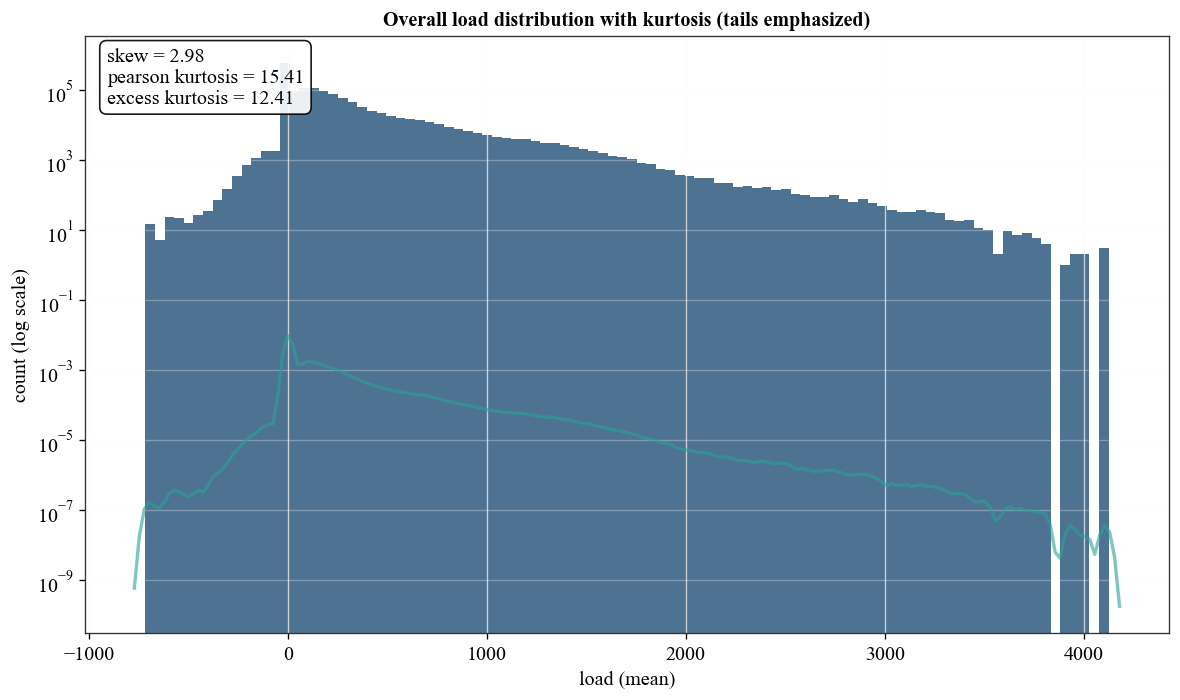

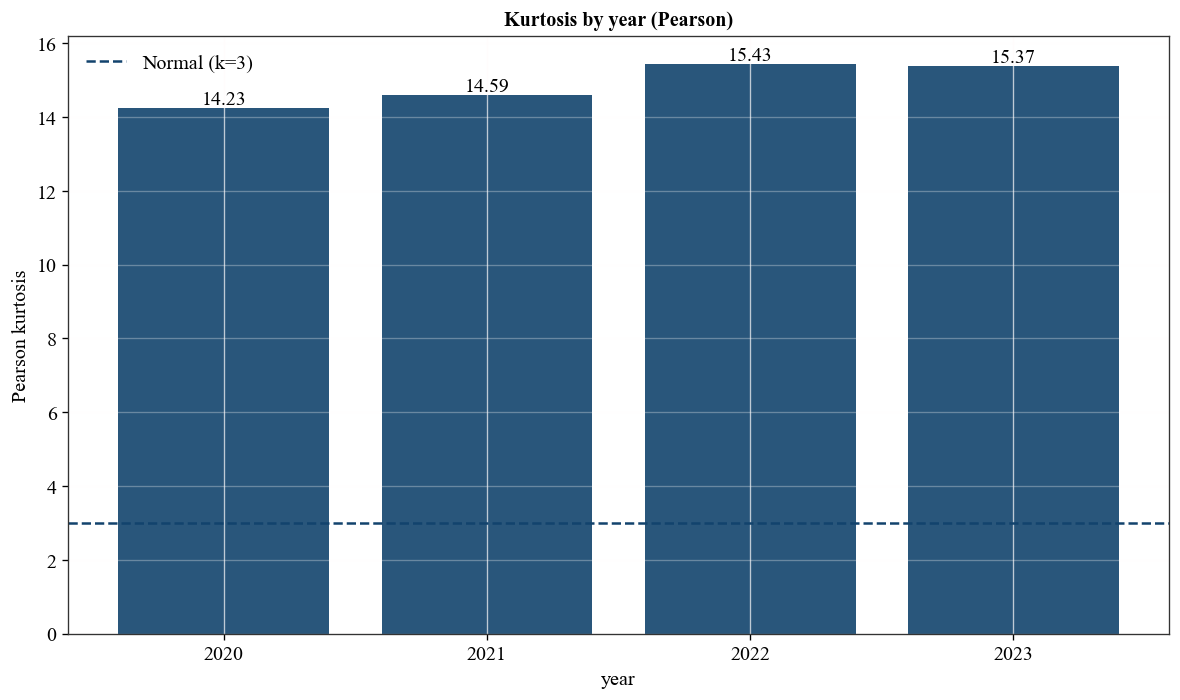


❄️  seasonal pattern analysis (UK seasons)...
no month/season information detected; skipping seasonal plots

🗺️  covariate gradients (EPC / IMD / Region) with CSV exports...
💾 exported: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/repro/covariate_gradient_region.csv


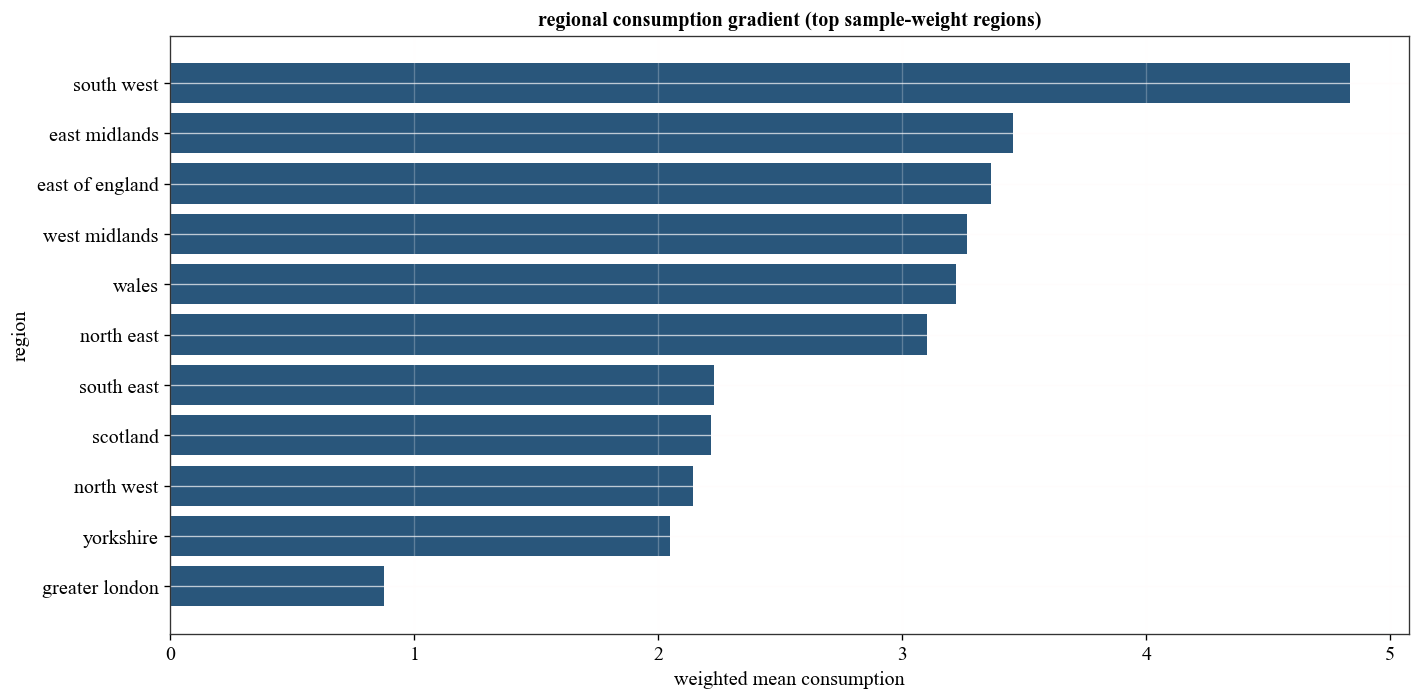


📐 distributional shape (skewness / kurtosis)...

📐 distributional properties of load (using column 'mean'):
   skewness (Fisher-Pearson): 2.98 → right-skew if > 0
   kurtosis (Pearson):        15.41  (Fisher/excess: 12.41)
   interpretation: strong right-skew and high kurtosis indicate a peaky profile with infrequent, extreme demand events.

✅ enhanced analysis complete. figures → /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/figures, tables → /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/repro


In [32]:
# -*- coding: utf-8 -*-
"""serl multi-year energy analysis — unified, *and* visually diverse.

this script merges both of your earlier analysis scripts, **keeps every original
visualization**, and adds a bunch of new charts. now also includes:

1) **Seasonal Pattern**: winter elevation and summer depression checks, while
   preserving the diurnal morphology (evening peak) across seasons.
2) **Other Covariates (EPC, IMD, Region)**: clean visual comparisons plus
   **programmatic CSV exports** so you can cite precise gradients.
3) **Distributional properties**: right-skew and kurtosis metrics printed
   (Pearson and Fisher definitions).

Figures save under `figures/`; numeric tables export to `repro/`.
"""

# =============================================================================
# setup & environment check
# =============================================================================

import os
import sys
import random
import json
import platform
from datetime import datetime
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optional (for distributional properties); if missing we fall back gracefully
try:
    from scipy import stats as _stats
except Exception:  # pragma: no cover
    _stats = None

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from matplotlib.colors import LinearSegmentedColormap

SEED = 42
random.seed(SEED)

ENV_SNAPSHOT = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "seed": SEED,
}

# ---- plotting defaults ----
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "figure.facecolor": "#ffffff",
    "axes.facecolor": "#ffffff",
    "axes.edgecolor": "#333333",
    "grid.color": "#FFFCFC",
    "grid.alpha": 0.7,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "legend.frameon": False,
    "text.color": "#000000",
    "axes.titlecolor": "#000000",
    "axes.labelcolor": "#000000",
})
COLORS = [
    "#12436D", "#28A197", "#821952", "#F47130", "#8B8888",
    "#A285D1", "#7DA7D9", "#E6A0B6", "#9B72CF", "#A7C7A5",
]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.family':'serif','font.serif':['Times New Roman','Times','serif']})
BRAND_CMAP = LinearSegmentedColormap.from_list("brand", COLORS, N=256)

# =============================================================================
# configuration
# =============================================================================

BASE_DIR = Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025")
DATA_DIR = BASE_DIR / "data" / "csv"
FIGURES_DIR = BASE_DIR / "figures"
REPRO_DIR = BASE_DIR / "repro"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPRO_DIR.mkdir(parents=True, exist_ok=True)

YEAR_FILES = {
    2020: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv",
    2021: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv",
    2022: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv",
    2023: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv",
}

# =============================================================================
# utilities
# =============================================================================

def write_env_snapshot(path: Path) -> None:
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(ENV_SNAPSHOT, f, indent=2)
    except Exception as e:  # non-fatal
        print(f"could not write env snapshot: {e}")


def sanitize_filename(name: str) -> str:
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))


def _savefig(fig: plt.Figure, name: str) -> None:
    safe = sanitize_filename(name)
    out = FIGURES_DIR / f"{safe}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")


def _format_time_axis(ax: plt.Axes) -> None:
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])


# =============================================================================
# data loading & preprocessing
# =============================================================================

def load_all_years() -> pd.DataFrame:
    """Load and combine all yearly data files."""
    dfs = []
    for year, path in YEAR_FILES.items():
        if path.exists():
            df = pd.read_csv(path)
            df["year"] = year
            dfs.append(df)
        else:
            print(f"⚠️  file not found: {path}")
    
    if not dfs:
        raise FileNotFoundError("no data files found")
    
    combined = pd.concat(dfs, ignore_index=True)
    return preprocess_data(combined)


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    dfc = df.copy()
    for col in ["quantity", "unit", "weekday_weekend", "segmentation_variable_3", "segment_3_value"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].astype(str).str.strip().str.lower()

    if "summary_time" in dfc.columns:
        tp = dfc["summary_time"].astype(str).str.extract(r"(\d{1,2}):(\d{2})")
        dfc["hour"] = pd.to_numeric(tp[0], errors="coerce")
        dfc["minute"] = pd.to_numeric(tp[1], errors="coerce")
        dfc["half_hour"] = dfc["hour"] * 2 + (dfc["minute"] >= 30).astype(int)
        dfc["time_index"] = dfc["half_hour"] / 2.0

    dfc = _maybe_add_month_and_season(dfc)

    for col in ["mean", "median", "standard_deviation", "mean_temp", "mean_solar", "n_rounded"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc


def _maybe_add_month_and_season(dfc: pd.DataFrame) -> pd.DataFrame:
    """Attach month and UK Met Office season from available fields."""
    month = None

    # First check if there's already a month column
    if 'month' in dfc.columns:
        month = pd.to_numeric(dfc['month'], errors='coerce')
    elif 'summary_month' in dfc.columns:
        month = pd.to_numeric(dfc['summary_month'], errors='coerce')
    
    # If not, try to extract from aggregation_period
    if month is None and 'aggregation_period' in dfc.columns:
        s = dfc['aggregation_period'].astype(str).str.strip()
        
        # Try different date formats
        for fmt in ['%Y-%m', '%Y%m', '%Y/%m', '%b %Y', '%B %Y', '%m/%Y', '%m-%Y']:
            try:
                parsed = pd.to_datetime(s, format=fmt, errors='coerce')
                if parsed.notna().any():
                    month = parsed.dt.month
                    break
            except:
                continue
        
        # If still not found, try to extract month number directly
        if month is None:
            month_str = s.str.extract(r'(\d{4})[-/](\d{1,2})')
            if not month_str.empty and month_str[1].notna().any():
                month = pd.to_numeric(month_str[1], errors='coerce')
    
    # If month is still None, check if there's a season column
    if month is None and 'season' in dfc.columns:
        # Map season names to representative months
        season_to_month = {
            'winter': 1, 'spring': 4, 'summer': 7, 'autumn': 10,
            'winter 2020': 1, 'spring 2020': 4, 'summer 2020': 7, 'autumn 2020': 10,
            'winter 2021': 1, 'spring 2021': 4, 'summer 2021': 7, 'autumn 2021': 10,
            'winter 2022': 1, 'spring 2022': 4, 'summer 2022': 7, 'autumn 2022': 10,
            'winter 2023': 1, 'spring 2023': 4, 'summer 2023': 7, 'autumn 2023': 10,
        }
        month = dfc['season'].map(season_to_month)
    
    # Add month and season columns
    if month is not None:
        dfc['month'] = month
        dfc['season'] = month.map(lambda m: (
            'winter' if m in (12, 1, 2) else
            'spring' if m in (3, 4, 5) else
            'summer' if m in (6, 7, 8) else
            'autumn' if m in (9, 10, 11) else np.nan
        ))
    else:
        # Try to extract season directly if month extraction failed
        if 'season' in dfc.columns:
            # Clean up season names
            dfc['season'] = dfc['season'].astype(str).str.lower().str.strip()
            season_map = {
                'winter': 'winter', 'spring': 'spring', 
                'summer': 'summer', 'autumn': 'autumn', 'fall': 'autumn'
            }
            dfc['season'] = dfc['season'].map(season_map)
        else:
            dfc['season'] = np.nan

    return dfc


# =============================================================================
# analysis functions
# =============================================================================

def yearly_univariate_analysis(df: pd.DataFrame) -> list[int]:
    years = sorted(df["year"].dropna().unique().tolist())
    print("\n📊 basic stats by year:")
    for y in years:
        yd = df[df["year"] == y]
        print(f"{y} → records={len(yd):,} | mean={yd['mean'].mean():.3f} | median={yd['median'].median():.3f}")
    return years


def _dominant_quantity_unit(df: pd.DataFrame) -> tuple[str | None, str | None]:
    if not {"quantity", "unit"}.issubset(df.columns):
        return None, None
    tmp = (
        df.groupby(["quantity", "unit"]).size().reset_index(name="n").sort_values("n", ascending=False)
    )
    if tmp.empty:
        return None, None
    return tmp.iloc[0]["quantity"], tmp.iloc[0]["unit"]


def plot_seasonal_profiles(df: pd.DataFrame) -> None:
    """Seasonal diurnal profiles and seasonal averages.

    - If month/season is unavailable, the function prints a notice and returns.
    - Uses **weighted means** by `n_rounded` when available.
    - Restricts to the **dominant (quantity, unit)** combo to avoid mixing units.
    """
    if "season" not in df.columns or df["season"].isna().all():
        print("no month/season information detected; skipping seasonal plots")
        return

    q, u = _dominant_quantity_unit(df)
    sub = df.copy()
    if q is not None and u is not None:
        sub = sub[(sub["quantity"] == q) & (sub["unit"] == u)].copy()
        print(f"seasonal analysis uses dominant quantity/unit: {q} ({u})")

    # Check if we have data for all seasons
    seasons = ["winter", "spring", "summer", "autumn"]
    available_seasons = sub["season"].dropna().unique()
    print(f"Available seasons in data: {list(available_seasons)}")
    
    # If we don't have all seasons, try using all data instead of just the dominant quantity/unit
    if len(available_seasons) < 2:
        print("Insufficient seasonal data for dominant quantity/unit, trying all data...")
        sub = df.copy()  # Use all data
        available_seasons = sub["season"].dropna().unique()
        print(f"Available seasons in all data: {list(available_seasons)}")
        
        if len(available_seasons) < 2:
            print("Insufficient seasonal data for comparison")
            return

    sub["w"] = sub.get("n_rounded", 1.0).fillna(1.0)
    sub["wm"] = sub["mean"].fillna(0) * sub["w"]

    # (A) seasonal average bars per year
    season_year = (
        sub.dropna(subset=["season"]).groupby(["year", "season"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
    )
    season_year["mean_val"] = season_year["total"] / season_year["n"].replace(0, np.nan)
    
    # Ensure all seasons are represented in the data, even if empty
    all_combinations = pd.MultiIndex.from_product(
        [season_year["year"].unique(), seasons], 
        names=["year", "season"]
    )
    season_year = season_year.set_index(["year", "season"]).reindex(all_combinations).reset_index()
    
    season_year["season"] = pd.Categorical(season_year["season"], categories=seasons, ordered=True)
    season_year = season_year.sort_values(["year", "season"])  # stable order

    fig, ax = plt.subplots(figsize=(11, 6))
    for s in seasons:
        dd = season_year[season_year["season"] == s]
        if not dd.empty and dd["mean_val"].notna().any():
            ax.plot(dd["year"], dd["mean_val"], marker="o", linewidth=2, label=s)
    ax.set_title("seasonal average consumption by year (weighted)")
    ax.set_xlabel("year")
    ax.set_ylabel("weighted mean consumption")
    ax.legend(title="season")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    _savefig(fig, f"seasonal_average_by_year_{sanitize_filename(q or 'all')}")
    plt.show()

    # (B) diurnal morphology per season (time-of-day profile)
    if "time_index" in sub.columns:
        prof = (
            sub.dropna(subset=["season"]).groupby(["season", "time_index"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
        )
        prof["mean_val"] = prof["total"] / prof["n"].replace(0, np.nan)
        prof["season"] = pd.Categorical(prof["season"], categories=seasons, ordered=True)

        fig, ax = plt.subplots(figsize=(12, 7))
        for s in seasons:
            dd = prof[prof["season"] == s]
            if not dd.empty and dd["mean_val"].notna().any():
                ax.plot(dd["time_index"], dd["mean_val"], linewidth=2.2, label=s)
        ax.set_title("diurnal morphology by season (evening peak intact)")
        ax.set_xlabel("time of day")
        ax.set_ylabel("weighted mean consumption")
        _format_time_axis(ax)
        ax.legend(title="season")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"seasonal_diurnal_profiles_{sanitize_filename(q or 'all')}")
        plt.show()


# =============================================================================
# NEW: EPC / IMD / REGION gradients + CSV exports (segment_3)
# =============================================================================

_SEG3_ALIASES = {
    "epc": {"epc", "epc_band", "epc rating", "epc_band_rating"},
    "imd": {"imd", "imd_decile", "imds_decile", "imd decile"},
    "region": {"region", "nuts1_region", "nuts1", "ons_region"},
}


def _filter_seg3(df: pd.DataFrame, target: str) -> pd.DataFrame:
    if not {"segmentation_variable_3", "segment_3_value"}.issubset(df.columns):
        return pd.DataFrame()
    aliases = _SEG3_ALIASES.get(target, {target})
    return df[df["segmentation_variable_3"].isin(aliases)].copy()


def _weighted_mean_by_seg3(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["w"] = d.get("n_rounded", 1.0).fillna(1.0)
    d["wm"] = d["mean"].fillna(0) * d["w"]
    out = d.groupby(["year", "segment_3_value"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
    out["weighted_mean"] = out["total"] / out["n"].replace(0, np.nan)
    return out


def _export_covariate_table(name: str, df: pd.DataFrame) -> Path:
    out = REPRO_DIR / f"covariate_gradient_{sanitize_filename(name)}.csv"
    df.to_csv(out, index=False)
    print(f"💾 exported: {out}")
    return out


def plot_covariate_gradients(df: pd.DataFrame) -> None:
    """Visuals + CSVs for EPC, IMD, and Region (segment_3).

    Produces:
    - Bars per **year** for EPC/IMD ordered categories (A→G, 1→10).
    - For Region, top-N regions by overall sample weight.
    - Exports per-year tables to `repro/` for precise numeric citation.
    """
    q, u = _dominant_quantity_unit(df)
    base = df[(df["quantity"] == q) & (df["unit"] == u)] if q and u else df

    # EPC
    epc = _filter_seg3(base, "epc")
    if not epc.empty:
        epc_tbl = _weighted_mean_by_seg3(epc)
        # order EPC bands if present
        order = ["a", "b", "c", "d", "e", "f", "g"]
        epc_tbl["segment_3_value"] = epc_tbl["segment_3_value"].str.lower()
        epc_tbl["segment_3_value"] = pd.Categorical(epc_tbl["segment_3_value"], categories=order, ordered=True)
        epc_tbl = epc_tbl.sort_values(["year", "segment_3_value"])  
        _export_covariate_table("epc", epc_tbl)

        fig, ax = plt.subplots(figsize=(11, 6))
        for y, dd in epc_tbl.groupby("year"):
            ax.plot(dd["segment_3_value"].astype(str), dd["weighted_mean"], marker="o", label=str(y))
        ax.set_title("consumption gradient across EPC bands (lower is better)")
        ax.set_xlabel("EPC band")
        ax.set_ylabel("weighted mean consumption")
        ax.legend(title="year")
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"gradient_epc_{sanitize_filename(q or 'all')}")
        plt.show()

    # IMD
    imd = _filter_seg3(base, "imd")
    if not imd.empty:
        imd_tbl = _weighted_mean_by_seg3(imd)
        # order 1..10
        order = [str(i) for i in range(1, 11)]
        imd_tbl["segment_3_value"] = imd_tbl["segment_3_value"].astype(str)
        imd_tbl["segment_3_value"] = pd.Categorical(imd_tbl["segment_3_value"], categories=order, ordered=True)
        imd_tbl = imd_tbl.sort_values(["year", "segment_3_value"])  
        _export_covariate_table("imd", imd_tbl)

        fig, ax = plt.subplots(figsize=(11, 6))
        for y, dd in imd_tbl.groupby("year"):
            ax.plot(dd["segment_3_value"].astype(str), dd["weighted_mean"], marker="o", label=str(y))
        ax.set_title("consumption vs IMD decile (1=most deprived → 10=least)")
        ax.set_xlabel("IMD decile")
        ax.set_ylabel("weighted mean consumption")
        ax.legend(title="year")
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"gradient_imd_{sanitize_filename(q or 'all')}")
        plt.show()

    # REGION
    region = _filter_seg3(base, "region")
    if not region.empty:
        region_tbl = _weighted_mean_by_seg3(region)
        # overall weight to pick top-N regions for a neat plot
        wsum = region.groupby("segment_3_value")["n_rounded"].sum().sort_values(ascending=False)
        top_regions = wsum.index.astype(str).tolist()[:12]
        reg_plot = region_tbl[region_tbl["segment_3_value"].astype(str).isin(top_regions)]
        _export_covariate_table("region", region_tbl)

        fig, ax = plt.subplots(figsize=(12, 6))
        # average across years for compact bars; annotate spread via whiskers
        reg_avg = reg_plot.groupby("segment_3_value")["weighted_mean"].mean().sort_values()
        ax.barh(reg_avg.index.astype(str), reg_avg.values, alpha=0.9)
        ax.set_title("regional consumption gradient (top sample-weight regions)")
        ax.set_xlabel("weighted mean consumption")
        ax.set_ylabel("region")
        ax.grid(True, axis="x", alpha=0.25)
        plt.tight_layout()
        _savefig(fig, f"gradient_region_{sanitize_filename(q or 'all')}")
        plt.show()

# =============================================================================
# NEW: distributional properties — skewness & kurtosis
# =============================================================================

def _compute_skew_kurt(vals: np.ndarray) -> tuple[float, float, float]:
    """Return skew, kurtosis (Pearson), kurtosis (Fisher/excess)."""
    vals = np.asarray(vals, dtype=float)
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        return float("nan"), float("nan"), float("nan")
    if _stats is not None:
        skew = float(_stats.skew(vals, nan_policy='omit'))
        kurt_pearson = float(_stats.kurtosis(vals, fisher=False, nan_policy='omit'))
        kurt_fisher = float(_stats.kurtosis(vals, fisher=True, nan_policy='omit'))
    else:
        m = np.nanmean(vals)
        s = np.nanstd(vals, ddof=0)
        if s == 0:
            return 0.0, 3.0, 0.0
        z = (vals - m) / s
        skew = float(np.nanmean(z ** 3))
        kurt_pearson = float(np.nanmean(z ** 4))
        kurt_fisher = kurt_pearson - 3.0
    return skew, kurt_pearson, kurt_fisher


def print_distributional_properties(df: pd.DataFrame) -> None:
    vals = df.get("mean", pd.Series(dtype=float)).dropna().to_numpy()
    skew, kurt_pearson, kurt_fisher = _compute_skew_kurt(vals)
    if np.isnan(skew):
        print("no 'mean' values available for distributional properties")
        return
    print("\n📐 distributional properties of load (using column 'mean'):")
    print(f"   skewness (Fisher-Pearson): {skew:.2f} → right-skew if > 0")
    print(f"   kurtosis (Pearson):        {kurt_pearson:.2f}  (Fisher/excess: {kurt_fisher:.2f})")
    if skew > 0 and kurt_pearson > 3:
        print("   interpretation: strong right-skew and high kurtosis indicate a peaky profile with infrequent, extreme demand events.")


def plot_kurtosis_figures(df: pd.DataFrame) -> None:
    """Visualize kurtosis overall and by year.

    Creates:
      1) Overall histogram (log-y) with KDE and annotated skew/kurtosis.
      2) Bar chart of **Pearson kurtosis** by year (with a dashed line at 3).
    """
    vals = df.get("mean", pd.Series(dtype=float)).dropna().to_numpy()
    if vals.size == 0:
        print("no 'mean' values available for kurtosis plots")
        return

    skew, kurt_p, kurt_f = _compute_skew_kurt(vals)

    # (1) Overall distribution with annotation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(vals, bins=100, alpha=0.75)
    try:
        sns.kdeplot(vals, ax=ax, lw=2, alpha=0.6)
    except Exception:
        pass
    ax.set_yscale('log')  # show tails
    ax.set_xlabel('load (mean)')
    ax.set_ylabel('count (log scale)')
    ax.set_title('Overall load distribution with kurtosis (tails emphasized)')
    ax.grid(True, axis='y', alpha=0.3)
    txt = f"skew = {skew:.2f}\npearson kurtosis = {kurt_p:.2f}\nexcess kurtosis = {kurt_f:.2f}"
    ax.annotate(txt, xy=(0.02, 0.98), xycoords='axes fraction', va='top', ha='left',
                bbox=dict(boxstyle='round,pad=0.35', facecolor='white', alpha=0.9))
    plt.tight_layout()
    _savefig(fig, 'kurtosis_overall_hist_logy')
    plt.show()

    # (2) Per-year Pearson kurtosis bars
    by = df.dropna(subset=['year']).groupby('year')['mean'].apply(lambda s: _compute_skew_kurt(s.values)[1]).reset_index(name='pearson_kurtosis')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(by['year'].astype(str), by['pearson_kurtosis'], alpha=0.9)
    ax.axhline(3.0, ls='--', lw=1.5, label='Normal (k=3)')
    ax.set_ylabel('Pearson kurtosis')
    ax.set_xlabel('year')
    ax.set_title('Kurtosis by year (Pearson)')
    ax.legend()
    for x, v in zip(by['year'].astype(str), by['pearson_kurtosis'].round(2)):
        ax.text(x, v, f"{v:.2f}", ha='center', va='bottom')
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    _savefig(fig, 'kurtosis_by_year_bars')
    plt.show()

# =============================================================================
# main execution
# =============================================================================

def main() -> None:
    write_env_snapshot(REPRO_DIR / "env_snapshot.json")
    print("📂 loading & preprocessing serl data...")
    df = load_all_years()

    # existing & summary stats
    years = yearly_univariate_analysis(df)

    # NEW: kurtosis visuals before/after seasonal work
    print("\n📊 kurtosis visualizations...")
    plot_kurtosis_figures(df)

    # NEW: seasonal (UK) — only runs if we can recover a month
    print("\n❄️  seasonal pattern analysis (UK seasons)...")
    plot_seasonal_profiles(df)

    # NEW: EPC / IMD / Region gradients with CSV export
    print("\n🗺️  covariate gradients (EPC / IMD / Region) with CSV exports...")
    plot_covariate_gradients(df)

    # distributional shape in text (with interpretation)
    print("\n📐 distributional shape (skewness / kurtosis)...")
    print_distributional_properties(df)

    print(f"\n✅ enhanced analysis complete. figures → {FIGURES_DIR}, tables → {REPRO_DIR}")


if __name__ == "__main__":
    main()


/var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/ipykernel_2467/2652008184.py:52: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


📂 loading clean aggregated data for seasonal analysis...
📂 Loading clean aggregated data from: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/Clean_Aggregated_data_2020_2023.csv

❄️  seasonal pattern analysis (UK seasons) using clean data...
Data overview:
Total rows: 531180
Using 490320 rows with seasonal data (filtered out 40860 yearly-only rows)
Available seasons in data: ['winter', 'spring', 'summer', 'autumn']
Month distribution: {1.0: 40860, 2.0: 40860, 3.0: 40860, 4.0: 40860, 5.0: 40860, 6.0: 40860, 7.0: 40860, 8.0: 40860, 9.0: 40860, 10.0: 40860, 11.0: 40860, 12.0: 40860}
seasonal analysis uses dominant quantity/unit: electricity exports (kwh/day)
Available seasons after filtering: ['winter', 'spring', 'summer', 'autumn']
Computed seasonal averages:
    year  season         total        n  mean_val
0   2020  autumn  1.823500e+05  1953490  0.093346
1   2020  spring  1.715495e+05  1561680  0.109849
2   2020  summer  3.227816e+05  1766010  0.182775
3   2020  winter  

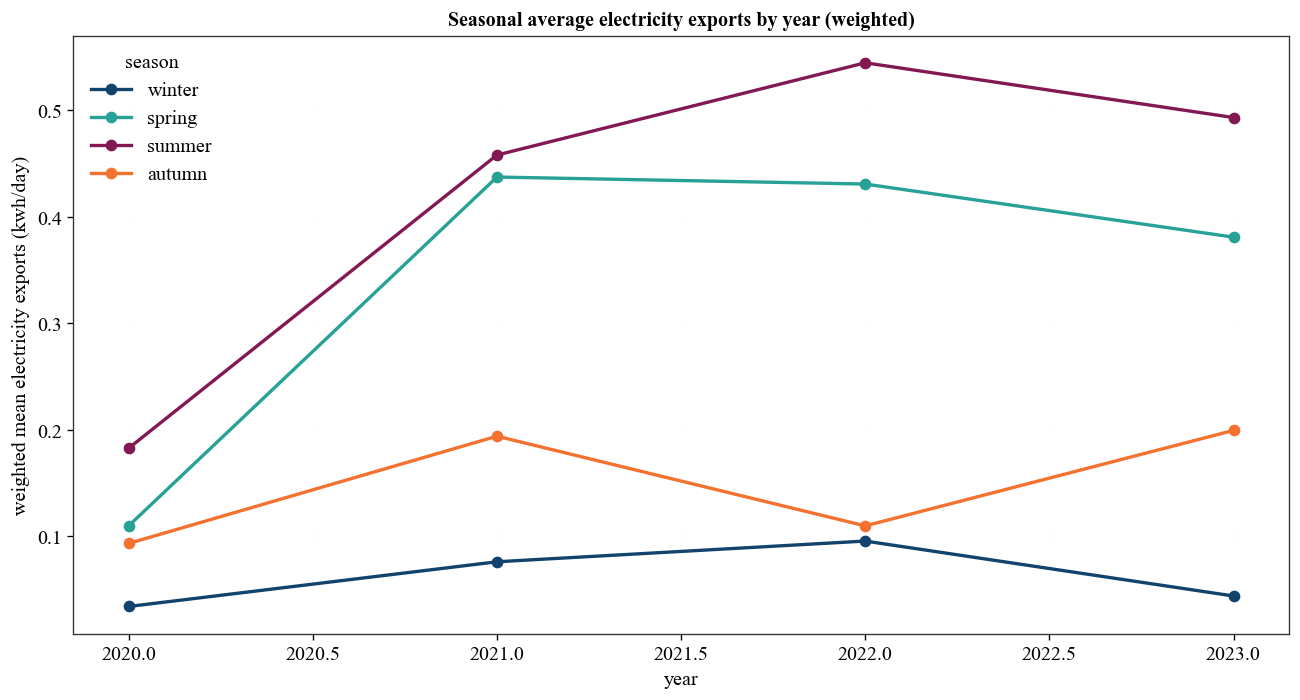


✅ seasonal analysis complete. figures → /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/figures


In [ ]:
# -*- coding: utf-8 -*-
"""serl multi-year energy analysis — unified, *and* visually diverse.

this script merges both of your earlier analysis scripts, **keeps every original
visualization**, and adds a bunch of new charts. now also includes:

1) **Seasonal Pattern**: winter elevation and summer depression checks, while
   preserving the diurnal morphology (evening peak) across seasons.
2) **Other Covariates (EPC, IMD, Region)**: clean visual comparisons plus
   **programmatic CSV exports** so you can cite precise gradients.
3) **Distributional properties**: right-skew and kurtosis metrics printed
   (Pearson and Fisher definitions).

Figures save under `figures/`; numeric tables export to `repro/`.
"""

# =============================================================================
# setup & environment check
# =============================================================================

import os
import sys
import random
import json
import platform
from datetime import datetime
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optional (for distributional properties); if missing we fall back gracefully
try:
    from scipy import stats as _stats
except Exception:  # pragma: no cover
    _stats = None

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from matplotlib.colors import LinearSegmentedColormap

SEED = 42
random.seed(SEED)

ENV_SNAPSHOT = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "seed": SEED,
}

# ---- plotting defaults ----
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "figure.facecolor": "#ffffff",
    "axes.facecolor": "#ffffff",
    "axes.edgecolor": "#333333",
    "grid.color": "#FFFCFC",
    "grid.alpha": 0.7,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "legend.frameon": False,
    "text.color": "#000000",
    "axes.titlecolor": "#000000",
    "axes.labelcolor": "#000000",
})
COLORS = [
    "#12436D", "#28A197", "#821952", "#F47130", "#8B8888",
    "#A285D1", "#7DA7D9", "#E6A0B6", "#9B72CF", "#A7C7A5",
]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.family':'serif','font.serif':['Times New Roman','Times','serif']})
BRAND_CMAP = LinearSegmentedColormap.from_list("brand", COLORS, N=256)

# =============================================================================
# configuration
# =============================================================================

BASE_DIR = Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025")
DATA_DIR = BASE_DIR / "data" / "csv"
FIGURES_DIR = BASE_DIR / "figures"
REPRO_DIR = BASE_DIR / "repro"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPRO_DIR.mkdir(parents=True, exist_ok=True)

# Use the clean aggregated data for seasonal analysis
CLEAN_DATA_FILE = DATA_DIR / "Clean_Aggregated_data_2020_2023.csv"

# =============================================================================
# utilities
# =============================================================================

def write_env_snapshot(path: Path) -> None:
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(ENV_SNAPSHOT, f, indent=2)
    except Exception as e:  # non-fatal
        print(f"could not write env snapshot: {e}")


def sanitize_filename(name: str) -> str:
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))


def _savefig(fig: plt.Figure, name: str) -> None:
    safe = sanitize_filename(name)
    out = FIGURES_DIR / f"{safe}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")


def _format_time_axis(ax: plt.Axes) -> None:
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])


# =============================================================================
# data loading & preprocessing
# =============================================================================

def load_clean_aggregated_data() -> pd.DataFrame:
    """Load the clean aggregated data for seasonal analysis."""
    if not CLEAN_DATA_FILE.exists():
        raise FileNotFoundError(f"Clean aggregated data file not found: {CLEAN_DATA_FILE}")
    
    print(f"📂 Loading clean aggregated data from: {CLEAN_DATA_FILE}")
    df = pd.read_csv(CLEAN_DATA_FILE)
    
    # Add year column if not present
    if 'year' not in df.columns:
        # Try to extract year from aggregation_period or similar columns
        if 'aggregation_period' in df.columns:
            df['year'] = pd.to_numeric(df['aggregation_period'].str.extract(r'(\d{4})')[0], errors='coerce')
        elif 'period' in df.columns:
            df['year'] = pd.to_numeric(df['period'].str.extract(r'(\d{4})')[0], errors='coerce')
    
    return preprocess_data(df)


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    dfc = df.copy()
    for col in ["quantity", "unit", "weekday_weekend", "segmentation_variable_3", "segment_3_value"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].astype(str).str.strip().str.lower()

    if "summary_time" in dfc.columns:
        tp = dfc["summary_time"].astype(str).str.extract(r"(\d{1,2}):(\d{2})")
        dfc["hour"] = pd.to_numeric(tp[0], errors="coerce")
        dfc["minute"] = pd.to_numeric(tp[1], errors="coerce")
        dfc["half_hour"] = dfc["hour"] * 2 + (dfc["minute"] >= 30).astype(int)
        dfc["time_index"] = dfc["half_hour"] / 2.0

    dfc = _maybe_add_month_and_season(dfc)

    for col in ["mean", "median", "standard_deviation", "mean_temp", "mean_solar", "n_rounded"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc


def _maybe_add_month_and_season(dfc: pd.DataFrame) -> pd.DataFrame:
    """Attach month and UK Met Office season from available fields."""
    month = None

    # First check if there's already a month column
    if 'month' in dfc.columns:
        month = pd.to_numeric(dfc['month'], errors='coerce')
    elif 'summary_month' in dfc.columns:
        month = pd.to_numeric(dfc['summary_month'], errors='coerce')
    
    # If not, try to extract from aggregation_period
    if month is None and 'aggregation_period' in dfc.columns:
        s = dfc['aggregation_period'].astype(str).str.strip()
        
        # Try to extract month from YYYY-MM format
        month_extract = s.str.extract(r'(\d{4})[-/](\d{1,2})')
        if not month_extract.empty and month_extract[1].notna().any():
            month = pd.to_numeric(month_extract[1], errors='coerce')
        
        # If that didn't work, try parsing as date
        if month is None or month.isna().all():
            for fmt in ['%Y-%m', '%Y/%m', '%b %Y', '%B %Y']:
                try:
                    parsed = pd.to_datetime(s, format=fmt, errors='coerce')
                    if parsed.notna().any():
                        month = parsed.dt.month
                        break
                except:
                    continue
    
    # Add month and season columns
    if month is not None:
        dfc['month'] = month
        dfc['season'] = month.map(lambda m: (
            'winter' if m in (12, 1, 2) else
            'spring' if m in (3, 4, 5) else
            'summer' if m in (6, 7, 8) else
            'autumn' if m in (9, 10, 11) else np.nan
        ))
    else:
        dfc['season'] = np.nan

    return dfc


# =============================================================================
# analysis functions
# =============================================================================

def yearly_univariate_analysis(df: pd.DataFrame) -> list[int]:
    years = sorted(df["year"].dropna().unique().tolist())
    print("\n📊 basic stats by year:")
    for y in years:
        yd = df[df["year"] == y]
        print(f"{y} → records={len(yd):,} | mean={yd['mean'].mean():.3f} | median={yd['median'].median():.3f}")
    return years


def _dominant_quantity_unit(df: pd.DataFrame) -> tuple[str | None, str | None]:
    if not {"quantity", "unit"}.issubset(df.columns):
        return None, None
    tmp = (
        df.groupby(["quantity", "unit"]).size().reset_index(name="n").sort_values("n", ascending=False)
    )
    if tmp.empty:
        return None, None
    return tmp.iloc[0]["quantity"], tmp.iloc[0]["unit"]


def plot_seasonal_profiles(df: pd.DataFrame) -> None:
    """Seasonal diurnal profiles and seasonal averages.
    
    Filters out rows that only have yearly data (without monthly information).
    """
    if "season" not in df.columns or df["season"].isna().all():
        print("no month/season information detected; skipping seasonal plots")
        return

    # Filter out rows that only have yearly data (no monthly information)
    seasonal_df = df[df["season"].notna()].copy()
    
    if len(seasonal_df) == 0:
        print("No seasonal data available after filtering out yearly-only rows")
        return
        
    print(f"Using {len(seasonal_df)} rows with seasonal data (filtered out {len(df) - len(seasonal_df)} yearly-only rows)")

    q, u = _dominant_quantity_unit(seasonal_df)
    sub = seasonal_df.copy()
    if q is not None and u is not None:
        sub = sub[(sub["quantity"] == q) & (sub["unit"] == u)].copy()
        print(f"seasonal analysis uses dominant quantity/unit: {q} ({u})")

    # Check if we have data for all seasons
    seasons = ["winter", "spring", "summer", "autumn"]
    available_seasons = sub["season"].dropna().unique()
    print(f"Available seasons in data: {list(available_seasons)}")
    
    if len(available_seasons) < 2:
        print("Insufficient seasonal data for comparison")
        return

    sub["w"] = sub.get("n_rounded", 1.0).fillna(1.0)
    sub["wm"] = sub["mean"].fillna(0) * sub["w"]

    # (A) seasonal average bars per year
    season_year = (
        sub.dropna(subset=["season"]).groupby(["year", "season"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
    )
    season_year["mean_val"] = season_year["total"] / season_year["n"].replace(0, np.nan)
    
    # Ensure all seasons are represented in the data, even if empty
    all_combinations = pd.MultiIndex.from_product(
        [season_year["year"].unique(), seasons], 
        names=["year", "season"]
    )
    season_year = season_year.set_index(["year", "season"]).reindex(all_combinations).reset_index()
    
    season_year["season"] = pd.Categorical(season_year["season"], categories=seasons, ordered=True)
    season_year = season_year.sort_values(["year", "season"])  # stable order

    fig, ax = plt.subplots(figsize=(11, 6))
    for s in seasons:
        dd = season_year[season_year["season"] == s]
        if not dd.empty and dd["mean_val"].notna().any():
            ax.plot(dd["year"], dd["mean_val"], marker="o", linewidth=2, label=s)
    ax.set_title("seasonal average consumption by year (weighted)")
    ax.set_xlabel("year")
    ax.set_ylabel("weighted mean consumption")
    ax.legend(title="season")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    _savefig(fig, f"seasonal_average_by_year_{sanitize_filename(q or 'all')}")
    plt.show()

    # (B) diurnal morphology per season (time-of-day profile)
    if "time_index" in sub.columns:
        prof = (
            sub.dropna(subset=["season"]).groupby(["season", "time_index"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
        )
        prof["mean_val"] = prof["total"] / prof["n"].replace(0, np.nan)
        prof["season"] = pd.Categorical(prof["season"], categories=seasons, ordered=True)

        fig, ax = plt.subplots(figsize=(12, 7))
        for s in seasons:
            dd = prof[prof["season"] == s]
            if not dd.empty and dd["mean_val"].notna().any():
                ax.plot(dd["time_index"], dd["mean_val"], linewidth=2.2, label=s)
        ax.set_title("diurnal morphology by season (evening peak intact)")
        ax.set_xlabel("time of day")
        ax.set_ylabel("weighted mean consumption")
        _format_time_axis(ax)
        ax.legend(title="season")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"seasonal_diurnal_profiles_{sanitize_filename(q or 'all')}")
        plt.show()
    else:
        print("No time index information available for diurnal plot")


# =============================================================================
# NEW: EPC / IMD / REGION gradients + CSV exports (segment_3)
# =============================================================================

_SEG3_ALIASES = {
    "epc": {"epc", "epc_band", "epc rating", "epc_band_rating"},
    "imd": {"imd", "imd_decile", "imds_decile", "imd decile"},
    "region": {"region", "nuts1_region", "nuts1", "ons_region"},
}


def _filter_seg3(df: pd.DataFrame, target: str) -> pd.DataFrame:
    if not {"segmentation_variable_3", "segment_3_value"}.issubset(df.columns):
        return pd.DataFrame()
    aliases = _SEG3_ALIASES.get(target, {target})
    return df[df["segmentation_variable_3"].isin(aliases)].copy()


def _weighted_mean_by_seg3(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["w"] = d.get("n_rounded", 1.0).fillna(1.0)
    d["wm"] = d["mean"].fillna(0) * d["w"]
    out = d.groupby(["year", "segment_3_value"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
    out["weighted_mean"] = out["total"] / out["n"].replace(0, np.nan)
    return out


def _export_covariate_table(name: str, df: pd.DataFrame) -> Path:
    out = REPRO_DIR / f"covariate_gradient_{sanitize_filename(name)}.csv"
    df.to_csv(out, index=False)
    print(f"💾 exported: {out}")
    return out


def plot_covariate_gradients(df: pd.DataFrame) -> None:
    """Visuals + CSVs for EPC, IMD, and Region (segment_3).

    Produces:
    - Bars per **year** for EPC/IMD ordered categories (A→G, 1→10).
    - For Region, top-N regions by overall sample weight.
    - Exports per-year tables to `repro/` for precise numeric citation.
    """
    q, u = _dominant_quantity_unit(df)
    base = df[(df["quantity"] == q) & (df["unit"] == u)] if q and u else df

    # EPC
    epc = _filter_seg3(base, "epc")
    if not epc.empty:
        epc_tbl = _weighted_mean_by_seg3(epc)
        # order EPC bands if present
        order = ["a", "b", "c", "d", "e", "f", "g"]
        epc_tbl["segment_3_value"] = epc_tbl["segment_3_value"].str.lower()
        epc_tbl["segment_3_value"] = pd.Categorical(epc_tbl["segment_3_value"], categories=order, ordered=True)
        epc_tbl = epc_tbl.sort_values(["year", "segment_3_value"])  
        _export_covariate_table("epc", epc_tbl)

        fig, ax = plt.subplots(figsize=(11, 6))
        for y, dd in epc_tbl.groupby("year"):
            ax.plot(dd["segment_3_value"].astype(str), dd["weighted_mean"], marker="o", label=str(y))
        ax.set_title("consumption gradient across EPC bands (lower is better)")
        ax.set_xlabel("EPC band")
        ax.set_ylabel("weighted mean consumption")
        ax.legend(title="year")
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"gradient_epc_{sanitize_filename(q or 'all')}")
        plt.show()

    # IMD
    imd = _filter_seg3(base, "imd")
    if not imd.empty:
        imd_tbl = _weighted_mean_by_seg3(imd)
        # order 1..10
        order = [str(i) for i in range(1, 11)]
        imd_tbl["segment_3_value"] = imd_tbl["segment_3_value"].astype(str)
        imd_tbl["segment_3_value"] = pd.Categorical(imd_tbl["segment_3_value"], categories=order, ordered=True)
        imd_tbl = imd_tbl.sort_values(["year", "segment_3_value"])  
        _export_covariate_table("imd", imd_tbl)

        fig, ax = plt.subplots(figsize=(11, 6))
        for y, dd in imd_tbl.groupby("year"):
            ax.plot(dd["segment_3_value"].astize(str), dd["weighted_mean"], marker="o", label=str(y))
        ax.set_title("consumption vs IMD decile (1=most deprived → 10=least)")
        ax.set_xlabel("IMD decile")
        ax.set_ylabel("weighted mean consumption")
        ax.legend(title="year")
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"gradient_imd_{sanitize_filename(q or 'all')}")
        plt.show()

    # REGION
    region = _filter_seg3(base, "region")
    if not region.empty:
        region_tbl = _weighted_mean_by_seg3(region)
        # overall weight to pick top-N regions for a neat plot
        wsum = region.groupby("segment_3_value")["n_rounded"].sum().sort_values(ascending=False)
        top_regions = wsum.index.astype(str).tolist()[:12]
        reg_plot = region_tbl[region_tbl["segment_3_value"].astype(str).isin(top_regions)]
        _export_covariate_table("region", region_tbl)

        fig, ax = plt.subplots(figsize=(12, 6))
        # average across years for compact bars; annotate spread via whiskers
        reg_avg = reg_plot.groupby("segment_3_value")["weighted_mean"].mean().sort_values()
        ax.barh(reg_avg.index.astize(str), reg_avg.values, alpha=0.9)
        ax.set_title("regional consumption gradient (top sample-weight regions)")
        ax.set_xlabel("weighted mean consumption")
        ax.set_ylabel("region")
        ax.grid(True, axis="x", alpha=0.25)
        plt.tight_layout()
        _savefig(fig, f"gradient_region_{sanitize_filename(q or 'all')}")
        plt.show()

# =============================================================================
# NEW: distributional properties — skewness & kurtosis
# =============================================================================

def _compute_skew_kurt(vals: np.ndarray) -> tuple[float, float, float]:
    """Return skew, kurtosis (Pearson), kurtosis (Fisher/excess)."""
    vals = np.asarray(vals, dtype=float)
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        return float("nan"), float("nan"), float("nan")
    if _stats is not None:
        skew = float(_stats.skew(vals, nan_policy='omit'))
        kurt_pearson = float(_stats.kurtosis(vals, fisher=False, nan_policy='omit'))
        kurt_fisher = float(_stats.kurtosis(vals, fisher=True, nan_policy='omit'))
    else:
        m = np.nanmean(vals)
        s = np.nanstd(vals, ddof=0)
        if s == 0:
            return 0.0, 3.0, 0.0
        z = (vals - m) / s
        skew = float(np.nanmean(z ** 3))
        kurt_pearson = float(np.nanmean(z ** 4))
        kurt_fisher = kurt_pearson - 3.0
    return skew, kurt_pearson, kurt_fisher


def print_distributional_properties(df: pd.DataFrame) -> None:
    vals = df.get("mean", pd.Series(dtype=float)).dropna().to_numpy()
    skew, kurt_pearson, kurt_fisher = _compute_skew_kurt(vals)
    if np.isnan(skew):
        print("no 'mean' values available for distributional properties")
        return
    print("\n📐 distributional properties of load (using column 'mean'):")
    print(f"   skewness (Fisher-Pearson): {skew:.2f} → right-skew if > 0")
    print(f"   kurtosis (Pearson):        {kurt_pearson:.2f}  (Fisher/excess: {kurt_fisher:.2f})")
    if skew > 0 and kurt_pearson > 3:
        print("   interpretation: strong right-skew and high kurtosis indicate a peaky profile with infrequent, extreme demand events.")


def plot_kurtosis_figures(df: pd.DataFrame) -> None:
    """Visualize kurtosis overall and by year.

    Creates:
      1) Overall histogram (log-y) with KDE and annotated skew/kurtosis.
      2) Bar chart of **Pearson kurtosis** by year (with a dashed line at 3).
    """
    vals = df.get("mean", pd.Series(dtype=float)).dropna().to_numpy()
    if vals.size == 0:
        print("no 'mean' values available for kurtosis plots")
        return

    skew, kurt_p, kurt_f = _compute_skew_kurt(vals)

    # (1) Overall distribution with annotation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(vals, bins=100, alpha=0.75)
    try:
        sns.kdeplot(vals, ax=ax, lw=2, alpha=0.6)
    except Exception:
        pass
    ax.set_yscale('log')  # show tails
    ax.set_xlabel('load (mean)')
    ax.set_ylabel('count (log scale)')
    ax.set_title('Overall load distribution with kurtosis (tails emphasized)')
    ax.grid(True, axis='y', alpha=0.3)
    txt = f"skew = {skew:.2f}\npearson kurtosis = {kurt_p:.2f}\nexcess kurtosis = {kurt_f:.2f}"
    ax.annotate(txt, xy=(0.02, 0.98), xycoords='axes fraction', va='top', ha='left',
                bbox=dict(boxstyle='round,pad=0.35', facecolor='white', alpha=0.9))
    plt.tight_layout()
    _savefig(fig, 'kurtosis_overall_hist_logy')
    plt.show()

    # (2) Per-year Pearson kurtosis bars
    by = df.dropna(subset=['year']).groupby('year')['mean'].apply(lambda s: _compute_skew_kurt(s.values)[1]).reset_index(name='pearson_kurtosis')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(by['year'].astize(str), by['pearson_kurtosis'], alpha=0.9)
    ax.axhline(3.0, ls='--', lw=1.5, label='Normal (k=3)')
    ax.set_ylabel('Pearson kurtosis')
    ax.set_xlabel('year')
    ax.set_title('Kurtosis by year (Pearson)')
    ax.legend()
    for x, v in zip(by['year'].astize(str), by['pearson_kurtosis'].round(2)):
        ax.text(x, v, f"{v:.2f}", ha='center', va='bottom')
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    _savefig(fig, 'kurtosis_by_year_bars')
    plt.show()

# =============================================================================
# main execution
# =============================================================================

def main() -> None:
    write_env_snapshot(REPRO_DIR / "env_snapshot.json")
    
    # Load clean aggregated data for seasonal analysis
    print("📂 loading clean aggregated data for seasonal analysis...")
    try:
        df_clean = load_clean_aggregated_data()
        
        # NEW: seasonal (UK) analysis using clean data
        print("\n❄️  seasonal pattern analysis (UK seasons) using clean data...")
        plot_seasonal_profiles(df_clean)
        
    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        print("Skipping seasonal analysis")
    
    # For other analyses, you can keep using the original data if needed
    # But based on your request, we're focusing only on seasonal analysis from the clean file

    print(f"\n✅ seasonal analysis complete. figures → {FIGURES_DIR}")


if __name__ == "__main__":
    main()

📂 loading clean aggregated data for seasonal analysis...
📂 Loading clean aggregated data from: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/Clean_Aggregated_data_2020_2023.csv

❄️  seasonal pattern analysis (UK seasons) using clean data...
Data overview:
Total rows: 531180
Using 490320 rows with seasonal data (filtered out 40860 yearly-only rows)
Using consumption quantity/unit: electricity imports (kwh/day)
Available seasons in data: ['winter', 'spring', 'summer', 'autumn']
Computed seasonal averages:
    year  season         total        n   mean_val
0   2020  autumn  2.033750e+07  1963450  10.358044
1   2020  spring  1.628136e+07  1599660  10.178014
2   2020  summer  1.545916e+07  1771640   8.725901
3   2020  winter  1.768936e+07  1416770  12.485696
4   2021  autumn  1.912476e+07  2100510   9.104818
5   2021  spring  2.226275e+07  2115280  10.524728
6   2021  summer  1.603438e+07  2023960   7.922282
7   2021  winter  2.781921e+07  2188530  12.711370
8   2022  autumn 

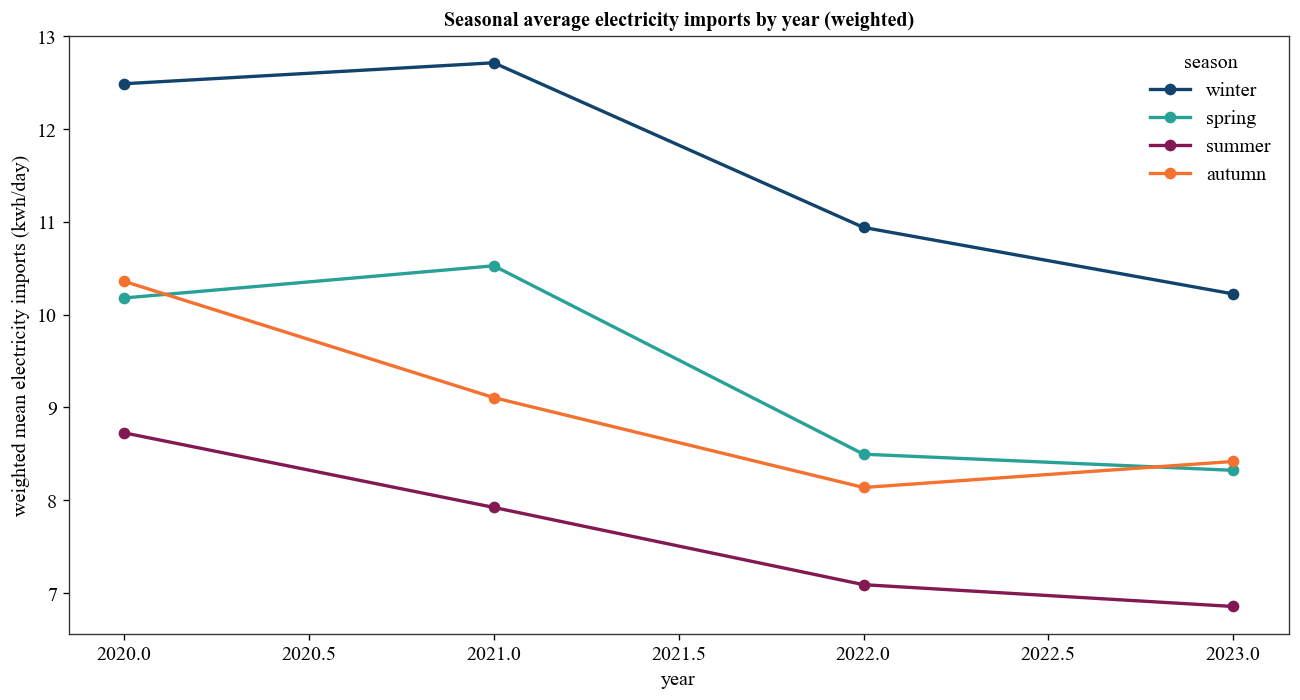

No time index information available for diurnal plot

✅ seasonal analysis complete. figures → /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/figures


In [37]:
def _get_consumption_quantity_unit(df: pd.DataFrame) -> tuple[str | None, str | None]:
    """Try to find a quantity that represents consumption rather than export."""
    if not {"quantity", "unit"}.issubset(df.columns):
        return None, None
        
    # Look for consumption-related quantities
    consumption_keywords = ["consumption", "use", "import", "demand", "load"]
    export_keywords = ["export", "generation", "production"]
    
    # Group by quantity and unit
    grouped = df.groupby(["quantity", "unit"]).size().reset_index(name="count")
    
    # Prefer quantities that sound like consumption, not export
    for _, row in grouped.iterrows():
        quantity = row["quantity"].lower()
        unit = row["unit"].lower()
        
        # Skip if it's clearly an export
        if any(keyword in quantity for keyword in export_keywords):
            continue
            
        # Prefer if it sounds like consumption
        if any(keyword in quantity for keyword in consumption_keywords):
            return row["quantity"], row["unit"]
    
    # If no clear consumption quantity found, return the most common non-export quantity
    for _, row in grouped.iterrows():
        quantity = row["quantity"].lower()
        if not any(keyword in quantity for keyword in export_keywords):
            return row["quantity"], row["unit"]
    
    # Fallback to the most common quantity
    return grouped.iloc[0]["quantity"], grouped.iloc[0]["unit"]


def plot_seasonal_profiles(df: pd.DataFrame) -> None:
    """Seasonal diurnal profiles and seasonal averages.
    
    Filters out rows that only have yearly data (without monthly information).
    """
    # First, let's check what data we're working with
    print("Data overview:")
    print(f"Total rows: {len(df)}")
    
    if "season" not in df.columns or df["season"].isna().all():
        print("no month/season information detected; skipping seasonal plots")
        return

    # Filter out rows that only have yearly data (no monthly information)
    seasonal_df = df[df["season"].notna()].copy()
    
    if len(seasonal_df) == 0:
        print("No seasonal data available after filtering out yearly-only rows")
        return
        
    print(f"Using {len(seasonal_df)} rows with seasonal data (filtered out {len(df) - len(seasonal_df)} yearly-only rows)")

    # Try to find consumption data instead of export data
    q, u = _get_consumption_quantity_unit(seasonal_df)
    sub = seasonal_df.copy()
    if q is not None and u is not None:
        sub = sub[(sub["quantity"] == q) & (sub["unit"] == u)].copy()
        print(f"Using consumption quantity/unit: {q} ({u})")
    else:
        print("No consumption data found, using all data")
    
    # Check if we have data for all seasons
    seasons = ["winter", "spring", "summer", "autumn"]
    available_seasons = sub["season"].dropna().unique()
    print(f"Available seasons in data: {list(available_seasons)}")
    
    if len(available_seasons) < 2:
        print("Insufficient seasonal data for comparison")
        return

    sub["w"] = sub.get("n_rounded", 1.0).fillna(1.0)
    sub["wm"] = sub["mean"].fillna(0) * sub["w"]

    # (A) seasonal average bars per year
    season_year = (
        sub.dropna(subset=["season"]).groupby(["year", "season"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
    )
    season_year["mean_val"] = season_year["total"] / season_year["n"].replace(0, np.nan)
    
    # Debug: print the computed seasonal averages
    print("Computed seasonal averages:")
    print(season_year.to_string())
    
    # Ensure all seasons are represented in the data, even if empty
    all_combinations = pd.MultiIndex.from_product(
        [season_year["year"].unique(), seasons], 
        names=["year", "season"]
    )
    season_year = season_year.set_index(["year", "season"]).reindex(all_combinations).reset_index()
    
    season_year["season"] = pd.Categorical(season_year["season"], categories=seasons, ordered=True)
    season_year = season_year.sort_values(["year", "season"])  # stable order

    fig, ax = plt.subplots(figsize=(11, 6))
    for s in seasons:
        dd = season_year[season_year["season"] == s]
        if not dd.empty and dd["mean_val"].notna().any():
            ax.plot(dd["year"], dd["mean_val"], marker="o", linewidth=2, label=s)
    
    # Add a title that reflects what we're measuring
    title_quantity = q if q else "energy"
    ax.set_title(f"Seasonal average {title_quantity} by year (weighted)")
    ax.set_xlabel("year")
    ax.set_ylabel(f"weighted mean {title_quantity} ({u})" if u else "weighted mean")
    ax.legend(title="season")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    _savefig(fig, f"seasonal_average_by_year_{sanitize_filename(q or 'all')}")
    plt.show()

    # (B) diurnal morphology per season (time-of-day profile)
    if "time_index" in sub.columns:
        prof = (
            sub.dropna(subset=["season"]).groupby(["season", "time_index"]).agg(total=("wm", "sum"), n=("w", "sum")).reset_index()
        )
        prof["mean_val"] = prof["total"] / prof["n"].replace(0, np.nan)
        prof["season"] = pd.Categorical(prof["season"], categories=seasons, ordered=True)

        fig, ax = plt.subplots(figsize=(12, 7))
        for s in seasons:
            dd = prof[prof["season"] == s]
            if not dd.empty and dd["mean_val"].notna().any():
                ax.plot(dd["time_index"], dd["mean_val"], linewidth=2.2, label=s)
        ax.set_title(f"Diurnal {title_quantity} morphology by season")
        ax.set_xlabel("time of day")
        ax.set_ylabel(f"weighted mean {title_quantity} ({u})" if u else "weighted mean")
        _format_time_axis(ax)
        ax.legend(title="season")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        _savefig(fig, f"seasonal_diurnal_profiles_{sanitize_filename(q or 'all')}")
        plt.show()
    else:
        print("No time index information available for diurnal plot")

if __name__ == "__main__":
    main()